$\textbf{We first get the data from the files _ISP1Requirements.csv and BalancePrices.csv and perform some preprocessing}$

$\textbf{Notes Uplift Account }$

* Uplift 1 : Λογφαριασμός Προσαυξήσεων Απωλειών ΕΣΜΗΕ
$$UPLIFT_1 = LOSSES \cdot \frac{MQ_{p,t}}{\sum MQ_{p,t}}$$
* LOSSES είναι το συνολικό κόστος των Απωλειών ΕΣΜΗΕ σε $ όπως προκύπτει απο την εκαθάριση κάθε αγοράς.

* Uplift 2 : Λογαριασμός Προσαυξ΄λησεων Ισχύος Εξισορρόπησης
$$UPLIFT_2 = BALCAP \cdot \frac{MQ_{p,t}}{\sum MQ_{p,t}}$$
* BALCAP είναι η συνολικ΄γ αποζημείωση όλων των Οντοτήτων Υπηρεσιών Εξισορρόπησης για την παραχθείσα Ισχύ για ανοδική και καθοδική ΕΔΣ, αυτόματη ΕΑΣ και χειροκίνητη ΕΑΣ για την Περιοδο εκκαθάρισης Αποκλίσεων t

* Uplift 3 : Λογαριασμός Προσαυξήσεων Οικονομικήες Ουδευτερότητας

$$UPLIFT_3 = NEUTR_t \cdot \frac{MQ_{p,t}}{\sum_p MQ_{p,t}}$$

* Το ποσό για την διασφάλιση της οικονομικής ουδετερότητας του Διαχειριστή του ΕΣΜΗΕ NEUTR για κάθε Περιόδο Εκκαθάρισης Αποκλίσεων t επιβαρύνει και επιμερίζεςται στα Συμβαλλόμενα Μέρη με Ευθύνη Εξισορρόπησης ανάλογα με την μετρούμενη απορρόφηση των πελατών τους  


* Μεθοδολογία Υπολογισμού Απωλειών 

Η μεθοδολογία πρόβλεψης των απωλειών βασίζεται στην πρόβλεψη των εγχύσεψν και απομαστευσεων ισχύος στοτς ζυγούς του Συστήματος.




In [65]:
from urllib.parse import urljoin
import datetime as datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import csv
from csv import reader

In [66]:
def make_dt_index(df, timestamp_col, dt_offset=None):
    df.index = pd.to_datetime(
        df.loc[:, timestamp_col], format='%Y-%m-%dT%H:%M:%S.%f'
    )

    if dt_offset:
        df.index = df.index + dt_offset

    df.drop(timestamp_col, axis=1, inplace=True)

    df.sort_index(inplace=True)

    return df


def check_duplicate_index(df, verbose=True):
    """ checks for duplicates in the index of a dataframe """
    dupes = df[df.index.duplicated()]
    num = dupes.shape[0]
    print('{} index duplicates'.format(num))

    if verbose == True:
        print('duplicates are:')
        print(dupes.head(3))

    return df[df.index.duplicated(keep=False)]


def drop_duplicate_index(df):
    return df[~df.index.duplicated(keep='first')]


def check_duplicate_rows(df, verbose=True):
    duplicated_bools = df.duplicated()
    num = np.sum(duplicated_bools)
    print('{} row duplicates'.format(num))

    if verbose:
        df[duplicated_bools].head(3)

    return df[df.duplicated(keep=False)]


def check_nans(df, verbose=True):
    """ checks for NANs in a dataframe """
    nans = df[df.isnull().any(axis=1)]
    num = nans.shape[0]

    print('{} nan rows'.format(num))
    if verbose:
        print('nan values are:')
        print(nans.head())

    return nans


def check_index_length(df, freq, verbose=True):
    """ compare a DatetimeIndex with the expected length """
    ideal = pd.DatetimeIndex(start=df.index[0],
                             end=df.index[-1],
                             freq=freq)

    ideal_len = ideal.shape[0]
    actual_len = df.shape[0]
    num_missing = ideal_len - actual_len
    print('ideal index len {} actual {} missing {}'.format(
        ideal_len, actual_len, num_missing))

    if ideal.shape[0] != df.shape[0]:
        missing = set(df.index).symmetric_difference(set(ideal))

        if verbose:
            print('missing are:')
            print(missing)

        return missing, ideal

    else:
        return None, df.index


def make_df_fill_dt_index(df, freq, method='ffill'):

    missing, ideal = check_index_length(df, freq)

    ideal_idx_df = pd.DataFrame(index=ideal)

    df = pd.concat([ideal_idx_df, df], axis=1)

    return df.fillna(method=method)


def check_dataframe(df, freq, verbose=False):
    """ wraps together all the checks """
    duplicate_index = check_duplicate_index(df, verbose)

    duplicate_rows = check_duplicate_rows(df, verbose)

    nans = check_nans(df, verbose)

    missing_index, ideal_index = check_index_length(df, freq, verbose)

    return {
        'duplicate_index': duplicate_index,
        'duplicate_rows': duplicate_rows,
        'nans': nans,
        'missing_index': missing_index,
        'ideal_index': ideal_index
    }
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

In [67]:
requirements_data = pd.read_csv('_ISP1Requirements.csv')
balancing_prices_data  = pd.read_csv('BalancePrices.csv')
scada_data  = pd.read_csv('scada.csv')

In [68]:
scada_data.head(50)
columns_data_scada =  scada_data.columns
scada_data[columns_data_scada[0]] = pd.to_datetime(scada_data[columns_data_scada[0]])
scada_data.set_index(columns_data_scada[0], drop=True, inplace=True)
scada_data.index.name = None

In [69]:
scada_data.head()
total_imports = scada_data["TOTAL IMPORTS"]
total_exports = scada_data["TOTAL EXPORTS"]

In [70]:
scada_data.head()

ΑΛΒΑΝΙΑ_IMP  ΒΟΥΛΓΑΡΙΑ_IMP  FYROM_IMP  ΙΤΑΛΙΑ_IMP  \
2021-08-15 00:00:00          0.0          229.0        2.0         0.0   
2021-08-15 01:00:00          0.0          246.0      140.0         0.0   
2021-08-15 02:00:00          0.0          294.0      233.0         0.0   
2021-08-15 03:00:00          0.0          335.0      306.0         0.0   
2021-08-15 04:00:00          0.0          355.0      332.0         0.0   

                     ΤΟΥΡΚΙΑ_IMP  TOTAL IMPORTS  ΑΛΒΑΝΙΑ_EXP  ΒΟΥΛΓΑΡΙΑ_EXP  \
2021-08-15 00:00:00        368.0          599.0        482.0            0.0   
2021-08-15 01:00:00        349.0          735.0        337.0            0.0   
2021-08-15 02:00:00        370.0          897.0        315.0            0.0   
2021-08-15 03:00:00        400.0         1041.0        295.0            0.0   
2021-08-15 04:00:00        409.0         1096.0        293.0            0.0   

                     FYROM_EXP  ΙΤΑΛΙΑ_EXP  ΤΟΥΡΚΙΑ_EXP  TOTAL EXPORTS  \
2021-08-15 00:00:00       51.0         0.0          0.0          533.0   
2021-08-15 01:00:00        0.0         0.0          0.0          337.0   
2021-08-15 02:00:00        0.0         0.0          0.0          315.0   
2021-08-15 03:00:00        0.0         0.0          0.0          295.0   
2021-08-15 04:00:00        0.0         0.0          0.0          293.0   

                     EXPORTS-IMPORTS  
2021-08-15 00:00:00            -66.0  
2021-08-15 01:00:00           -398.0  
2021-08-15 02:00:00           -582.0  
2021-08-15 03:00:00           -746.0  
2021-08-15 04:00:00           -803.0

In [71]:
columns_data = requirements_data.columns

In [72]:
requirements_data[columns_data[0]] = pd.to_datetime(requirements_data[columns_data[0]])
requirements_data.set_index(columns_data[0], drop=True, inplace=True)
requirements_data.index.name = None

In [73]:
requirements_data.head()

RES    Load  Mandatory Hydro  Total FRR
2021-08-15 00:00:00  1750.0  5742.0             50.0      894.0
2021-08-15 00:30:00  1790.0  5575.0             50.0      904.0
2021-08-15 01:00:00  1850.0  5456.0             50.0      924.0
2021-08-15 01:30:00  1910.0  5347.0             50.0      924.0
2021-08-15 02:00:00  1950.0  5251.0             50.0      954.0

In [74]:
balancing_prices_data['Unnamed: 0'] = pd.to_datetime(balancing_prices_data['Unnamed: 0'])
balancing_prices_data.set_index('Unnamed: 0', drop=True, inplace=True)
balancing_prices_data.index.name = None

In [75]:
balancing_prices_data = balancing_prices_data.drop(balancing_prices_data.columns[[9, 10]],axis=1)

In [76]:
requirements_data
requirements_data['Date'] = pd.to_datetime(requirements_data.index)  

In [77]:
balancing_prices_data['Date'] = pd.to_datetime(balancing_prices_data.index)

In [78]:
balancing_prices_data.head(100)

Total Activated Balancing Energy UP (MWh)  \
2021-08-09 00:00:00                                  145.52516   
2021-08-09 00:15:00                                   75.99048   
2021-08-09 00:30:00                                   51.49773   
2021-08-09 00:45:00                                   66.25723   
2021-08-09 01:00:00                                   24.80705   
2021-08-09 01:15:00                                   16.57891   
2021-08-09 01:30:00                                   22.02007   
2021-08-09 01:45:00                                   25.80361   
2021-08-09 02:00:00                                   20.76027   
2021-08-09 02:15:00                                   19.63507   
2021-08-09 02:30:00                                   19.83991   
2021-08-09 02:45:00                                   19.68479   
2021-08-09 03:00:00                                   19.37011   
2021-08-09 03:15:00                                   32.37073   
2021-08-09 03:30:00                                   38.00099   
2021-08-09 03:45:00                                   45.29575   
2021-08-09 04:00:00                                   28.23013   
2021-08-09 04:15:00                                   42.73321   
2021-08-09 04:30:00                                   45.39458   
2021-08-09 04:45:00                                   42.19149   
2021-08-09 05:00:00                                   35.01889   
2021-08-09 05:15:00                                   43.99497   
2021-08-09 05:30:00                                   42.37165   
2021-08-09 05:45:00                                   45.92615   
2021-08-09 06:00:00                                   62.47616   
2021-08-09 06:15:00                                   76.49625   
2021-08-09 06:30:00                                   97.89786   
2021-08-09 06:45:00                                  121.98525   
2021-08-09 07:00:00                                  110.47891   
2021-08-09 07:15:00                                  112.98997   
2021-08-09 07:30:00                                   92.08505   
2021-08-09 07:45:00                                  102.34886   
2021-08-09 08:00:00                                  114.80045   
2021-08-09 08:15:00                                  119.38725   
2021-08-09 08:30:00                                   72.17014   
2021-08-09 08:45:00                                   75.39081   
2021-08-09 09:00:00                                  108.12671   
2021-08-09 09:15:00                                   85.27338   
2021-08-09 09:30:00                                   83.54521   
2021-08-09 09:45:00                                   84.14080   
2021-08-09 10:00:00                                   70.41568   
2021-08-09 10:15:00                                   44.15307   
2021-08-09 10:30:00                                   61.91348   
2021-08-09 10:45:00                                   70.38132   
2021-08-09 11:00:00                                   87.10536   
2021-08-09 11:15:00                                   88.50477   
2021-08-09 11:30:00                                   95.55727   
2021-08-09 11:45:00                                  104.14773   
2021-08-09 12:00:00                                  106.28326   
2021-08-09 12:15:00                                  117.07940   
2021-08-09 12:30:00                                  126.67359   
2021-08-09 12:45:00                                  177.40822   
2021-08-09 13:00:00                                  191.19066   
2021-08-09 13:15:00                                  216.10292   
2021-08-09 13:30:00                                  164.22030   
2021-08-09 13:45:00                                  167.23159   
2021-08-09 14:00:00                                  168.56880   
2021-08-09 14:15:00                                  182.68073   
2021-08-09 14:30:00                                  199.13956   
2021-08-09 14:45:00                                  225.9619

In [79]:
#greater than the start date and smaller than the end date
start_date = '2021-08-15 00:00:00'
end_date   = '2022-04-17 23:45:00'
mask = (requirements_data['Date'] >= start_date) & (requirements_data['Date'] <= end_date)

In [80]:
requirements_data_new = requirements_data.loc[mask]

In [81]:
requirements_data_hourly =  requirements_data_new.resample('H', on='Date', closed='right').mean().reset_index()

In [82]:
mask_2 = (balancing_prices_data['Date'] >= start_date) & (balancing_prices_data['Date'] <= end_date)

In [83]:
balancing_prices_data_new = balancing_prices_data.loc[mask_2]

In [84]:
balancing_prices_hourly = balancing_prices_data_new.resample('H', on='Date', closed='right').mean().reset_index()

In [85]:
balancing_prices_hourly['Date'] = pd.to_datetime(balancing_prices_hourly['Date'])
balancing_prices_hourly.set_index('Date', drop=True, inplace=True)
balancing_prices_hourly.index.name = None

In [86]:
requirements_data_hourly['Date'] = pd.to_datetime(requirements_data_hourly['Date'])
requirements_data_hourly.set_index('Date', drop=True, inplace=True)
requirements_data_hourly.index.name = None

In [87]:
balancing_prices_hourly =  balancing_prices_hourly.iloc[1: , :]

In [88]:
requirements_data_hourly =requirements_data_hourly.iloc[1: , :]

In [89]:
requirements_data_hourly.head()

RES    Load  Mandatory Hydro  Total FRR
2021-08-15 00:00:00  1820.0  5515.5             50.0      914.0
2021-08-15 01:00:00  1930.0  5299.0             50.0      939.0
2021-08-15 02:00:00  2000.0  5127.5             50.0      949.0
2021-08-15 03:00:00  2035.0  5038.0             63.0      939.0
2021-08-15 04:00:00  2055.0  4951.5             76.0     1079.0

In [90]:
balancing_prices_hourly.head(50)

Total Activated Balancing Energy UP (MWh)  \
2021-08-15 00:00:00                                  64.696300   
2021-08-15 01:00:00                                  47.823965   
2021-08-15 02:00:00                                  37.976322   
2021-08-15 03:00:00                                  36.129990   
2021-08-15 04:00:00                                  34.597000   
2021-08-15 05:00:00                                  23.384867   
2021-08-15 06:00:00                                  56.135750   
2021-08-15 07:00:00                                  62.005892   
2021-08-15 08:00:00                                  32.436923   
2021-08-15 09:00:00                                  31.486835   
2021-08-15 10:00:00                                  38.603487   
2021-08-15 11:00:00                                  43.670228   
2021-08-15 12:00:00                                  39.672798   
2021-08-15 13:00:00                                  55.539810   
2021-08-15 14:00:00                                  76.910937   
2021-08-15 15:00:00                                 115.233335   
2021-08-15 16:00:00                                 140.417470   
2021-08-15 17:00:00                                 132.697350   
2021-08-15 18:00:00                                 122.292862   
2021-08-15 19:00:00                                  71.581340   
2021-08-15 20:00:00                                  31.235560   
2021-08-15 21:00:00                                  43.759552   
2021-08-15 22:00:00                                  46.465165   
2021-08-15 23:00:00                                  43.754770   
2021-08-16 00:00:00                                  14.284785   
2021-08-16 01:00:00                                  26.605528   
2021-08-16 02:00:00                                  68.675700   
2021-08-16 03:00:00                                  78.568782   
2021-08-16 04:00:00                                  89.041165   
2021-08-16 05:00:00                                  70.240287   
2021-08-16 06:00:00                                  34.878080   
2021-08-16 07:00:00                                  34.131830   
2021-08-16 08:00:00                                  22.975915   
2021-08-16 09:00:00                                  33.643535   
2021-08-16 10:00:00                                  38.553425   
2021-08-16 11:00:00                                  62.127308   
2021-08-16 12:00:00                                  63.696287   
2021-08-16 13:00:00                                  58.750933   
2021-08-16 14:00:00                                  65.986845   
2021-08-16 15:00:00                                  72.925900   
2021-08-16 16:00:00                                  75.051018   
2021-08-16 17:00:00                                 109.881187   
2021-08-16 18:00:00                                 146.329070   
2021-08-16 19:00:00                                 152.553685   
2021-08-16 20:00:00                                 174.622543   
2021-08-16 21:00:00                                  97.498503   
2021-08-16 22:00:00                                 103.914363   
2021-08-16 23:00:00                                 126.147207   
2021-08-17 00:00:00                                 102.352847   
2021-08-17 01:00:00                                 103.720825   

                     Total Activated Balancing Energy Down (MWh)  \
2021-08-15 00:00:00                                   162.704473   
2021-08-15 01:00:00                                   117.162650   
2021-08-15 02:00:00                                    56.592600   
2021-08-15 03:00:00                                   105.814593   
2021-08-15 04:00:00                                    90.711290   
2021-08-15 05:00:00                                    88.882660   
2021-08-15 06:00:00                                   116.949175   
2021-08-15 07:00:00                                   131.068113   
2021-08-15 08:00:00                       

$\textbf{Now we are going to add the Load Forecast from the entsoe api and some other exogenous features}$

In [91]:
from entsoe import EntsoePandasClient
import pandas as pd
api_key="7d2255de-e63f-4766-805a-0c0a1f6e7fa3"
client = EntsoePandasClient(api_key=api_key)
country_code = 'GR'

In [92]:
start = pd.Timestamp('20211030', tz='UTC')
end = pd.Timestamp('20211101', tz='UTC')
load_forecast = client.query_load(country_code, start=start, end = end)
load_forecast
generation_forecast = client.query_generation_forecast(country_code, start=start, end = end)
generation_forecast

2021-10-30 03:00:00+03:00    2054.0
2021-10-30 04:00:00+03:00    2032.0
2021-10-30 05:00:00+03:00    1848.0
2021-10-30 06:00:00+03:00    1839.0
2021-10-30 07:00:00+03:00    2380.0
2021-10-30 08:00:00+03:00    3306.0
2021-10-30 09:00:00+03:00    3323.0
2021-10-30 10:00:00+03:00    3064.0
2021-10-30 11:00:00+03:00    2980.0
2021-10-30 12:00:00+03:00    2533.0
2021-10-30 13:00:00+03:00    2596.0
2021-10-30 14:00:00+03:00    2457.0
2021-10-30 15:00:00+03:00    2455.0
2021-10-30 16:00:00+03:00    2875.0
2021-10-30 17:00:00+03:00    3475.0
2021-10-30 18:00:00+03:00    3661.0
2021-10-30 19:00:00+03:00    4365.0
2021-10-30 20:00:00+03:00    4543.0
2021-10-30 21:00:00+03:00    4262.0
2021-10-30 22:00:00+03:00    3877.0
2021-10-30 23:00:00+03:00    3413.0
2021-10-31 00:00:00+03:00    2871.0
2021-10-31 01:00:00+03:00    2119.0
2021-10-31 02:00:00+03:00    1852.0
2021-10-31 03:00:00+03:00    1720.0
2021-10-31 03:00:00+02:00    1850.0
2021-10-31 04:00:00+02:00    1922.0
2021-10-31 05:00:00+02:00   

In [93]:
load_forecast = load_forecast.iloc[21:5925,:]

In [94]:
load_forecast = load_forecast.set_index(balancing_prices_hourly.index)

ValueError: Length mismatch: Expected 26 rows, received array of length 5904

In [95]:
combined_dataframes = pd.concat([balancing_prices_hourly, requirements_data_hourly], axis=1, join="inner")

In [96]:
combined_dataframes.head()

Total Activated Balancing Energy UP (MWh)  \
2021-08-15 00:00:00                                  64.696300   
2021-08-15 01:00:00                                  47.823965   
2021-08-15 02:00:00                                  37.976322   
2021-08-15 03:00:00                                  36.129990   
2021-08-15 04:00:00                                  34.597000   

                     Total Activated Balancing Energy Down (MWh)  \
2021-08-15 00:00:00                                   162.704473   
2021-08-15 01:00:00                                   117.162650   
2021-08-15 02:00:00                                    56.592600   
2021-08-15 03:00:00                                   105.814593   
2021-08-15 04:00:00                                    90.711290   

                     Total Activated Balancing Energy (MWh)  \
2021-08-15 00:00:00                              -98.008173   
2021-08-15 01:00:00                              -69.338685   
2021-08-15 02:00:00                              -18.616278   
2021-08-15 03:00:00                              -69.684602   
2021-08-15 04:00:00                              -56.114290   

                     Imbalance Price  (€/MWh)  mFRR Price UP (€/MWh)  \
2021-08-15 00:00:00                 38.036567               141.3900   
2021-08-15 01:00:00                 23.803718                86.9275   
2021-08-15 02:00:00                 25.178707                27.8250   
2021-08-15 03:00:00                  0.010000                28.5925   
2021-08-15 04:00:00                 17.827500                28.5925   

                     mFRR Price Down (€/MWh)  Uplift Account 1 (€/MWh)  \
2021-08-15 00:00:00                  40.7625                  2.738548   
2021-08-15 01:00:00                  26.3325                  2.375837   
2021-08-15 02:00:00                   0.0100                  2.143069   
2021-08-15 03:00:00                   0.0100                  2.043232   
2021-08-15 04:00:00                  17.8275                  2.227400   

                     Uplift Account 2 (€/MWh)  Uplift Account 3 (€/MWh)  \
2021-08-15 00:00:00                  0.662670                  5.481142   
2021-08-15 01:00:00                  1.098814                  2.754350   
2021-08-15 02:00:00                  1.201918                  3.213499   
2021-08-15 03:00:00                  1.117085                  3.079745   
2021-08-15 04:00:00                  1.156230                  2.383576   

                        RES    Load  Mandatory Hydro  Total FRR  
2021-08-15 00:00:00  1820.0  5515.5             50.0      914.0  
2021-08-15 01:00:00  1930.0  5299.0             50.0      939.0  
2021-08-15 02:00:00  2000.0  5127.5             50.0      949.0  
2021-08-15 03:00:00  2035.0  5038.0             63.0      939.0  
2021-08-15 04:00:00  2055.0  4951.5             76.0     1079.0

In [97]:
check_nans(combined_dataframes)
features = combined_dataframes.columns

0 nan rows
nan values are:
Empty DataFrame
Columns: [Total Activated Balancing Energy UP (MWh), Total Activated Balancing Energy Down (MWh), Total Activated Balancing Energy (MWh), Imbalance Price  (€/MWh), mFRR Price UP (€/MWh), mFRR Price Down (€/MWh), Uplift Account 1 (€/MWh), Uplift Account 2 (€/MWh), Uplift Account 3 (€/MWh), RES, Load, Mandatory Hydro, Total FRR]
Index: []


In [98]:
Imbalance_price = combined_dataframes[features[3]]

combined_dataframes_new = combined_dataframes.drop(features[3],axis=1)

In [99]:
combined_dataframes_new["Imbalance_price"] = Imbalance_price

In [100]:
combined_dataframes_new.head(50)



Total Activated Balancing Energy UP (MWh)  \
2021-08-15 00:00:00                                  64.696300   
2021-08-15 01:00:00                                  47.823965   
2021-08-15 02:00:00                                  37.976322   
2021-08-15 03:00:00                                  36.129990   
2021-08-15 04:00:00                                  34.597000   
2021-08-15 05:00:00                                  23.384867   
2021-08-15 06:00:00                                  56.135750   
2021-08-15 07:00:00                                  62.005892   
2021-08-15 08:00:00                                  32.436923   
2021-08-15 09:00:00                                  31.486835   
2021-08-15 10:00:00                                  38.603487   
2021-08-15 11:00:00                                  43.670228   
2021-08-15 12:00:00                                  39.672798   
2021-08-15 13:00:00                                  55.539810   
2021-08-15 14:00:00                                  76.910937   
2021-08-15 15:00:00                                 115.233335   
2021-08-15 16:00:00                                 140.417470   
2021-08-15 17:00:00                                 132.697350   
2021-08-15 18:00:00                                 122.292862   
2021-08-15 19:00:00                                  71.581340   
2021-08-15 20:00:00                                  31.235560   
2021-08-15 21:00:00                                  43.759552   
2021-08-15 22:00:00                                  46.465165   
2021-08-15 23:00:00                                  43.754770   
2021-08-16 00:00:00                                  14.284785   
2021-08-16 01:00:00                                  26.605528   
2021-08-16 02:00:00                                  68.675700   
2021-08-16 03:00:00                                  78.568782   
2021-08-16 04:00:00                                  89.041165   
2021-08-16 05:00:00                                  70.240287   
2021-08-16 06:00:00                                  34.878080   
2021-08-16 07:00:00                                  34.131830   
2021-08-16 08:00:00                                  22.975915   
2021-08-16 09:00:00                                  33.643535   
2021-08-16 10:00:00                                  38.553425   
2021-08-16 11:00:00                                  62.127308   
2021-08-16 12:00:00                                  63.696287   
2021-08-16 13:00:00                                  58.750933   
2021-08-16 14:00:00                                  65.986845   
2021-08-16 15:00:00                                  72.925900   
2021-08-16 16:00:00                                  75.051018   
2021-08-16 17:00:00                                 109.881187   
2021-08-16 18:00:00                                 146.329070   
2021-08-16 19:00:00                                 152.553685   
2021-08-16 20:00:00                                 174.622543   
2021-08-16 21:00:00                                  97.498503   
2021-08-16 22:00:00                                 103.914363   
2021-08-16 23:00:00                                 126.147207   
2021-08-17 00:00:00                                 102.352847   
2021-08-17 01:00:00                                 103.720825   

                     Total Activated Balancing Energy Down (MWh)  \
2021-08-15 00:00:00                                   162.704473   
2021-08-15 01:00:00                                   117.162650   
2021-08-15 02:00:00                                    56.592600   
2021-08-15 03:00:00                                   105.814593   
2021-08-15 04:00:00                                    90.711290   
2021-08-15 05:00:00                                    88.882660   
2021-08-15 06:00:00                                   116.949175   
2021-08-15 07:00:00                                   131.068113   
2021-08-15 08:00:00                       

In [101]:
def df_info(df):
    len_df = len(df)
    sample = []
    p_nan = []
    corrSP = []
    all_uniq = []
    feature = features[3]
    for i in df.columns:
        head_col = str(list(df[i].head(5)))
        sample.append(head_col)
        all_nan = df[i].isna().sum() #.sum()
        if all_nan == len_df:
            p_nan.append(100)
        elif all_nan == 0:
            p_nan.append(0)
        else:
            p_nan.append(round(all_nan / len_df * 100, 2))
         
        if df[i].nunique() <= 5:
            all_uniq.append(str(list(set(df[i]))))
        else:
            all_uniq.append("Several")
 
    if "Imbalance_price" in df:
        corrSP = df.corr(method='pearson').Imbalance_price
    else:
        corrSP = np.nan

    list_of_numerics = df.select_dtypes(include = ['float','int']).columns
    outl = df.apply(lambda x: sum(
                     (x<(x.quantile(0.05) - 1.5 * (x.quantile(0.95)-x.quantile(0.05)))) |
                     (x>(x.quantile(0.95) + 1.5 * (x.quantile(0.95)-x.quantile(0.05))))
                     if x.name in list_of_numerics else '') )

    df_resume = pd.DataFrame({ 
                        'type': list(df.dtypes),
                        'Sample': sample,
                        "% of NaN": p_nan,
                        "Corr_with_y": corrSP,
                        'Duplicates' : (df.duplicated()).sum(),
                        'Amount Uniques' : df.nunique(),
                        'Uniques' : all_uniq,                        
                        'Outliers' : outl } , index = df.columns)
    
    return df_resume

pd.set_option('max_rows', None)


In [102]:
###### Statistics for 
df_info(combined_dataframes_new)

type  \
Total Activated Balancing Energy UP (MWh)    float64   
Total Activated Balancing Energy Down (MWh)  float64   
Total Activated Balancing Energy (MWh)       float64   
mFRR Price UP (€/MWh)                        float64   
mFRR Price Down (€/MWh)                      float64   
Uplift Account 1 (€/MWh)                     float64   
Uplift Account 2 (€/MWh)                     float64   
Uplift Account 3 (€/MWh)                     float64   
RES                                          float64   
Load                                         float64   
Mandatory Hydro                              float64   
Total FRR                                    float64   
Imbalance_price                              float64   

                                                                                        Sample  \
Total Activated Balancing Energy UP (MWh)    [64.6963, 47.823965, 37.976322499999995, 36.12...   
Total Activated Balancing Energy Down (MWh)  [162.7044725, 117.16265, 56.592600000000004, 1...   
Total Activated Balancing Energy (MWh)       [-98.00817250000001, -69.33868500000001, -18.6...   
mFRR Price UP (€/MWh)                        [141.39, 86.92750000000001, 27.825, 28.5925, 2...   
mFRR Price Down (€/MWh)                                [40.7625, 26.3325, 0.01, 0.01, 17.8275]   
Uplift Account 1 (€/MWh)                     [2.7385476725, 2.3758374875, 2.143069245000000...   
Uplift Account 2 (€/MWh)                     [0.662670305, 1.0988136525, 1.2019179125, 1.11...   
Uplift Account 3 (€/MWh)                     [5.48114178, 2.7543496524999997, 3.21349915, 3...   
RES                                                   [1820.0, 1930.0, 2000.0, 2035.0, 2055.0]   
Load                                                  [5515.5, 5299.0, 5127.5, 5038.0, 4951.5]   
Mandatory Hydro                                                 [50.0, 50.0, 50.0, 63.0, 76.0]   
Total FRR                                                 [914.0, 939.0, 949.0, 939.0, 1079.0]   
Imbalance_price                              [38.0365670475, 23.803718415, 25.17870695, 0.0...   

                                             % of NaN  Corr_with_y  \
Total Activated Balancing Energy UP (MWh)           0     0.592970   
Total Activated Balancing Energy Down (MWh)         0    -0.372177   
Total Activated Balancing Energy (MWh)              0     0.671568   
mFRR Price UP (€/MWh)                               0     0.768857   
mFRR Price Down (€/MWh)                             0     0.395989   
Uplift Account 1 (€/MWh)                            0     0.690137   
Uplift Account 2 (€/MWh)                            0     0.263268   
Uplift Account 3 (€/MWh)                            0     0.290910   
RES                                                 0    -0.081067   
Load                                                0     0.220631   
Mandatory Hydro                                     0     0.150217   
Total FRR                                           0     0.080078   
Imbalance_price                                     0     1.000000   

                                             Duplicates  Amount Uniques  \
Total Activated Balancing Energy UP (MWh)             0            5904   
Total Activated Balancing Energy Down (MWh)           0            5904   
Total Activated Balancing Energy (MWh)                0            5904   
mFRR Price UP (€/MWh)                                 0            5034   
mFRR Price Down (€/MWh)                               0            4711   
Uplift Account 1 (€/MWh)                              0            5904   
Uplift Account 2 (€/MWh)                              0            5904   
Uplift Account 3 (€/MWh)                              0            5904   
RES                                                   0             857   
Load                                                  0            4219   
Mandatory Hydro                                       0            1573   
Total FRR

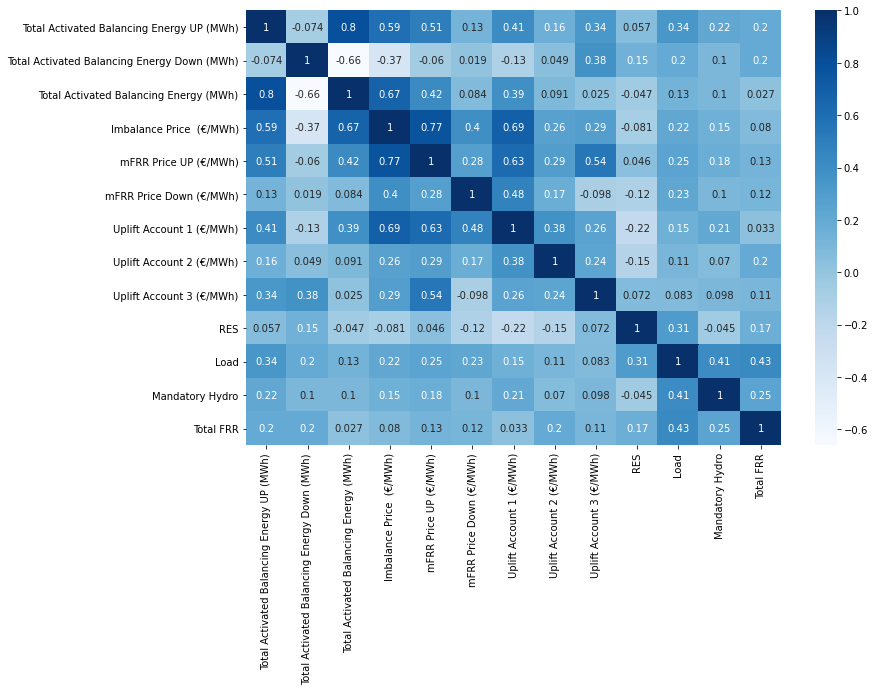

In [103]:
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(combined_dataframes.corr(), cmap='Blues', annot=True)
plt.show()

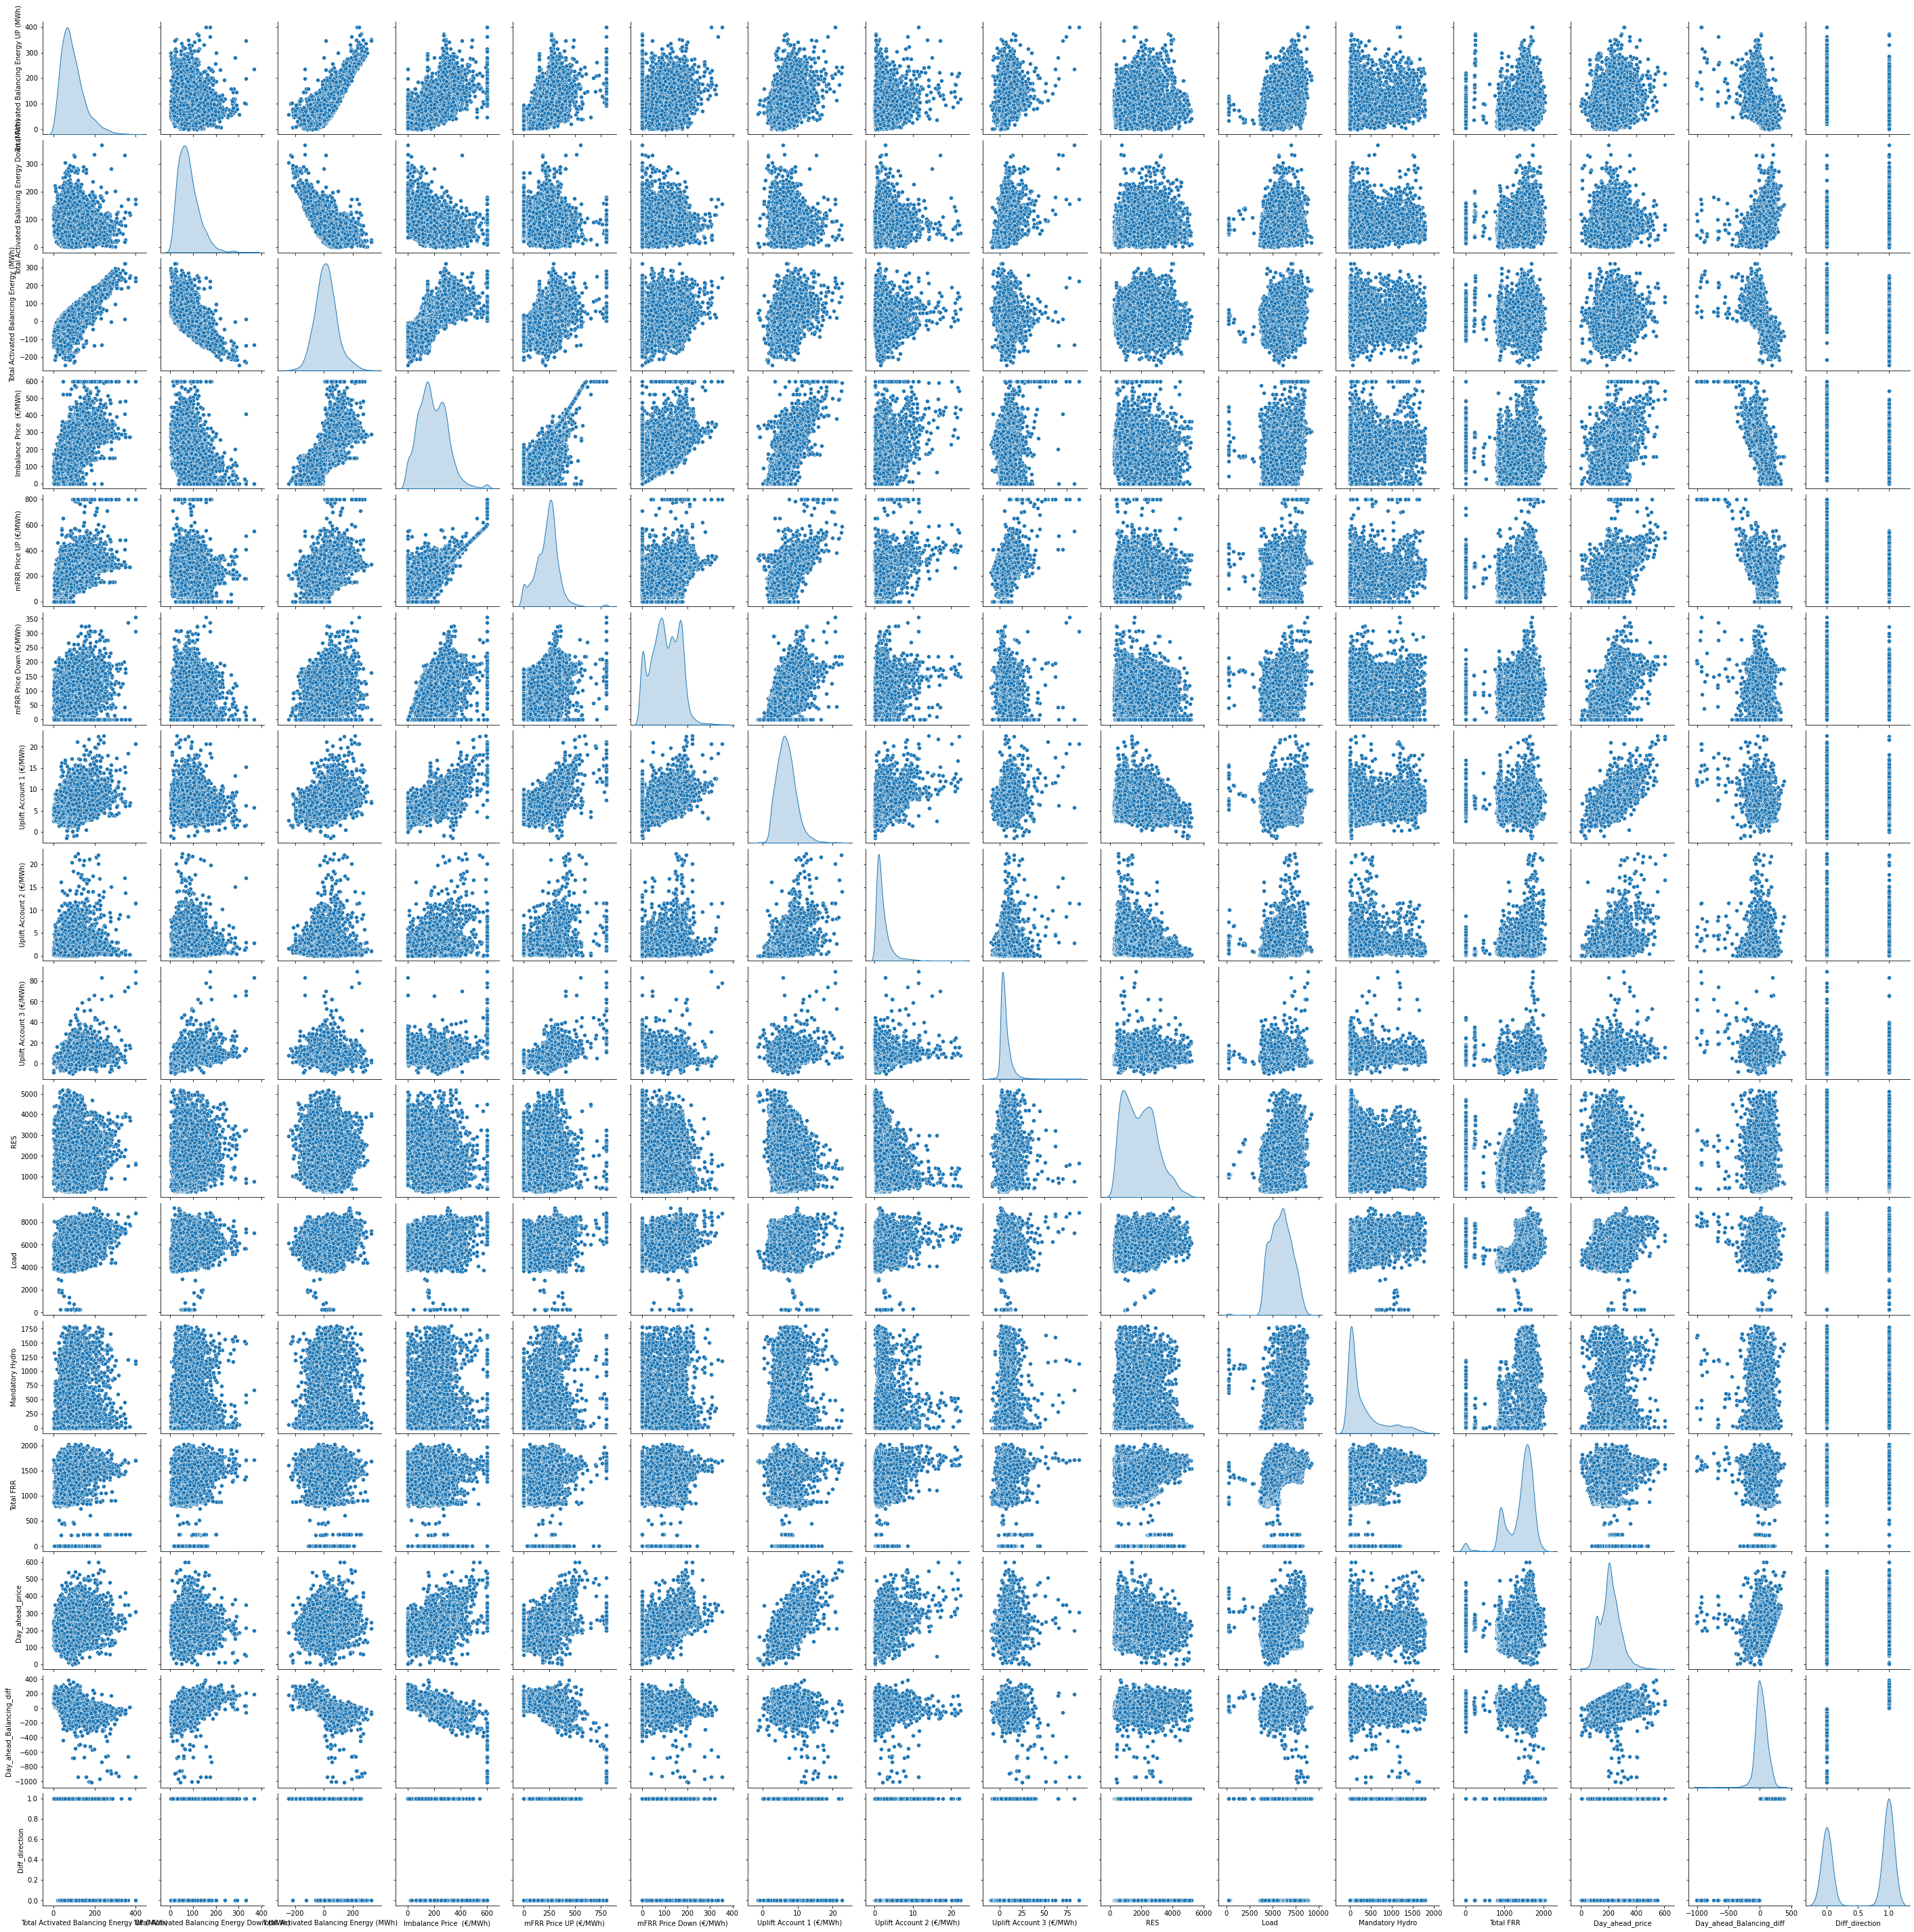

In [134]:
sns.pairplot(data=combined_dataframes, diag_kind='kde')

$\textbf{Now we are going to add the Day Ahead Prices}$

In [104]:
start = pd.Timestamp('20210814', tz='UTC')
end = pd.Timestamp('20220418', tz='UTC')
day_ahead_prices =client.query_day_ahead_prices(country_code, start= start, end = end)

In [105]:
len(day_ahead_prices)
day_ahead_prices.head()

2021-08-14 03:00:00+03:00    94.98
2021-08-14 04:00:00+03:00    92.89
2021-08-14 05:00:00+03:00    86.18
2021-08-14 06:00:00+03:00    86.18
2021-08-14 07:00:00+03:00    86.81
Freq: 60T, dtype: float64

In [106]:
day_ahead_prices = day_ahead_prices.iloc[21:5925 ,]

In [107]:
len(day_ahead_prices)
#len(combined_dataframes)
combined_dataframes.head()

Total Activated Balancing Energy UP (MWh)  \
2021-08-15 00:00:00                                  64.696300   
2021-08-15 01:00:00                                  47.823965   
2021-08-15 02:00:00                                  37.976322   
2021-08-15 03:00:00                                  36.129990   
2021-08-15 04:00:00                                  34.597000   

                     Total Activated Balancing Energy Down (MWh)  \
2021-08-15 00:00:00                                   162.704473   
2021-08-15 01:00:00                                   117.162650   
2021-08-15 02:00:00                                    56.592600   
2021-08-15 03:00:00                                   105.814593   
2021-08-15 04:00:00                                    90.711290   

                     Total Activated Balancing Energy (MWh)  \
2021-08-15 00:00:00                              -98.008173   
2021-08-15 01:00:00                              -69.338685   
2021-08-15 02:00:00                              -18.616278   
2021-08-15 03:00:00                              -69.684602   
2021-08-15 04:00:00                              -56.114290   

                     Imbalance Price  (€/MWh)  mFRR Price UP (€/MWh)  \
2021-08-15 00:00:00                 38.036567               141.3900   
2021-08-15 01:00:00                 23.803718                86.9275   
2021-08-15 02:00:00                 25.178707                27.8250   
2021-08-15 03:00:00                  0.010000                28.5925   
2021-08-15 04:00:00                 17.827500                28.5925   

                     mFRR Price Down (€/MWh)  Uplift Account 1 (€/MWh)  \
2021-08-15 00:00:00                  40.7625                  2.738548   
2021-08-15 01:00:00                  26.3325                  2.375837   
2021-08-15 02:00:00                   0.0100                  2.143069   
2021-08-15 03:00:00                   0.0100                  2.043232   
2021-08-15 04:00:00                  17.8275                  2.227400   

                     Uplift Account 2 (€/MWh)  Uplift Account 3 (€/MWh)  \
2021-08-15 00:00:00                  0.662670                  5.481142   
2021-08-15 01:00:00                  1.098814                  2.754350   
2021-08-15 02:00:00                  1.201918                  3.213499   
2021-08-15 03:00:00                  1.117085                  3.079745   
2021-08-15 04:00:00                  1.156230                  2.383576   

                        RES    Load  Mandatory Hydro  Total FRR  
2021-08-15 00:00:00  1820.0  5515.5             50.0      914.0  
2021-08-15 01:00:00  1930.0  5299.0             50.0      939.0  
2021-08-15 02:00:00  2000.0  5127.5             50.0      949.0  
2021-08-15 03:00:00  2035.0  5038.0             63.0      939.0  
2021-08-15 04:00:00  2055.0  4951.5             76.0     1079.0

In [108]:
combined_dataframes["Day_ahead_price"] = day_ahead_prices.values
Imbalance_Day_ahead_prices = combined_dataframes[[combined_dataframes.columns[3],"Day_ahead_price"]]
Imbalance_Day_ahead_prices.to_csv('prices_before.csv')

In [109]:
combined_dataframes.head()
check_nans(combined_dataframes)

0 nan rows
nan values are:
Empty DataFrame
Columns: [Total Activated Balancing Energy UP (MWh), Total Activated Balancing Energy Down (MWh), Total Activated Balancing Energy (MWh), Imbalance Price  (€/MWh), mFRR Price UP (€/MWh), mFRR Price Down (€/MWh), Uplift Account 1 (€/MWh), Uplift Account 2 (€/MWh), Uplift Account 3 (€/MWh), RES, Load, Mandatory Hydro, Total FRR, Day_ahead_price]
Index: []


Empty DataFrame
Columns: [Total Activated Balancing Energy UP (MWh), Total Activated Balancing Energy Down (MWh), Total Activated Balancing Energy (MWh), Imbalance Price  (€/MWh), mFRR Price UP (€/MWh), mFRR Price Down (€/MWh), Uplift Account 1 (€/MWh), Uplift Account 2 (€/MWh), Uplift Account 3 (€/MWh), RES, Load, Mandatory Hydro, Total FRR, Day_ahead_price]
Index: []

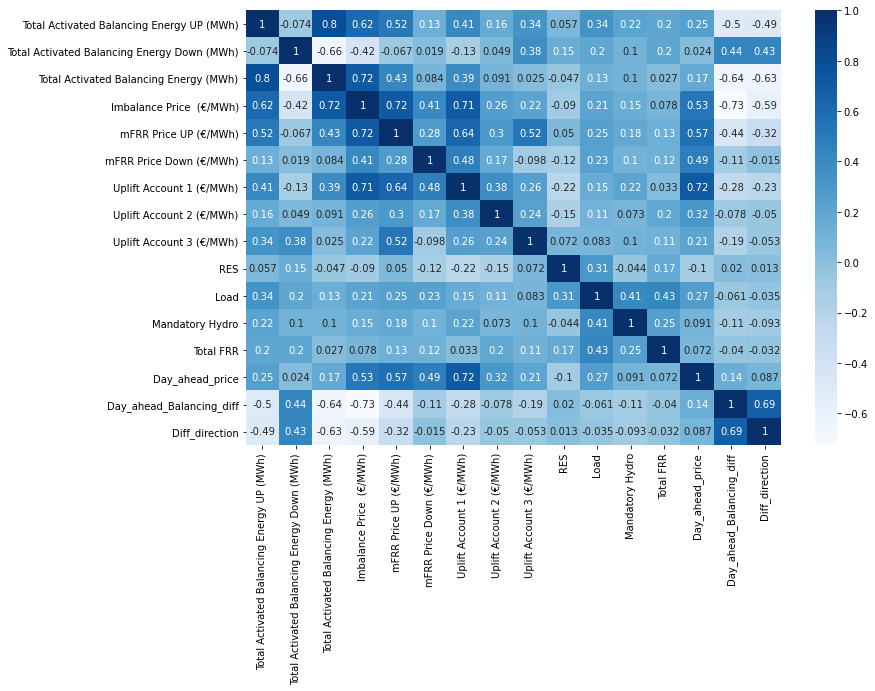

In [141]:
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(combined_dataframes.corr(), cmap='Blues', annot=True)
plt.show()

In [110]:
def df_info_2(df):
    len_df = len(df)
    sample = []
    p_nan = []
    corrSP = []
    all_uniq = []
    feature = features[3]
    for i in df.columns:
        head_col = str(list(df[i].head(5)))
        sample.append(head_col)
        all_nan = df[i].isna().sum() #.sum()
        if all_nan == len_df:
            p_nan.append(100)
        elif all_nan == 0:
            p_nan.append(0)
        else:
            p_nan.append(round(all_nan / len_df * 100, 2))
         
        if df[i].nunique() <= 5:
            all_uniq.append(str(list(set(df[i]))))
        else:
            all_uniq.append("Several")
 
    if "Day_ahead_price" in df:
        corrSP = df.corr(method='pearson').Day_ahead_price
        
    else:
        corrSP = np.nan

    list_of_numerics = df.select_dtypes(include = ['float','int']).columns
    outl = df.apply(lambda x: sum(
                     (x<(x.quantile(0.05) - 1.5 * (x.quantile(0.95)-x.quantile(0.05)))) |
                     (x>(x.quantile(0.95) + 1.5 * (x.quantile(0.95)-x.quantile(0.05))))
                     if x.name in list_of_numerics else '') )

    df_resume = pd.DataFrame({ 
                        'type': list(df.dtypes),
                        'Sample': sample,
                        "% of NaN": p_nan,
                        "Corr_with_y": corrSP,
                        'Duplicates' : (df.duplicated()).sum(),
                        'Amount Uniques' : df.nunique(),
                        'Uniques' : all_uniq,                        
                        'Outliers' : outl } , index = df.columns)
    df_resume = df_resume.sort_values(by = "Corr_with_y")
    
    return df_resume

pd.set_option('max_rows', None)


In [111]:
df_info_2(combined_dataframes)

type  \
RES                                          float64   
Total Activated Balancing Energy Down (MWh)  float64   
Total FRR                                    float64   
Mandatory Hydro                              float64   
Total Activated Balancing Energy (MWh)       float64   
Uplift Account 3 (€/MWh)                     float64   
Total Activated Balancing Energy UP (MWh)    float64   
Load                                         float64   
Uplift Account 2 (€/MWh)                     float64   
mFRR Price Down (€/MWh)                      float64   
Imbalance Price  (€/MWh)                     float64   
mFRR Price UP (€/MWh)                        float64   
Uplift Account 1 (€/MWh)                     float64   
Day_ahead_price                              float64   

                                                                                        Sample  \
RES                                                   [1820.0, 1930.0, 2000.0, 2035.0, 2055.0]   
Total Activated Balancing Energy Down (MWh)  [162.7044725, 117.16265, 56.592600000000004, 1...   
Total FRR                                                 [914.0, 939.0, 949.0, 939.0, 1079.0]   
Mandatory Hydro                                                 [50.0, 50.0, 50.0, 63.0, 76.0]   
Total Activated Balancing Energy (MWh)       [-98.00817250000001, -69.33868500000001, -18.6...   
Uplift Account 3 (€/MWh)                     [5.48114178, 2.7543496524999997, 3.21349915, 3...   
Total Activated Balancing Energy UP (MWh)    [64.6963, 47.823965, 37.976322499999995, 36.12...   
Load                                                  [5515.5, 5299.0, 5127.5, 5038.0, 4951.5]   
Uplift Account 2 (€/MWh)                     [0.662670305, 1.0988136525, 1.2019179125, 1.11...   
mFRR Price Down (€/MWh)                                [40.7625, 26.3325, 0.01, 0.01, 17.8275]   
Imbalance Price  (€/MWh)                     [38.0365670475, 23.803718415, 25.17870695, 0.0...   
mFRR Price UP (€/MWh)                        [141.39, 86.92750000000001, 27.825, 28.5925, 2...   
Uplift Account 1 (€/MWh)                     [2.7385476725, 2.3758374875, 2.143069245000000...   
Day_ahead_price                                             [95.16, 103.16, 91.91, 77.0, 83.8]   

                                             % of NaN  Corr_with_y  \
RES                                                 0    -0.102659   
Total Activated Balancing Energy Down (MWh)         0     0.023675   
Total FRR                                           0     0.072386   
Mandatory Hydro                                     0     0.089390   
Total Activated Balancing Energy (MWh)              0     0.171823   
Uplift Account 3 (€/MWh)                            0     0.205866   
Total Activated Balancing Energy UP (MWh)           0     0.247444   
Load                                                0     0.270865   
Uplift Account 2 (€/MWh)                            0     0.316798   
mFRR Price Down (€/MWh)                             0     0.485212   
Imbalance Price  (€/MWh)                            0     0.493490   
mFRR Price UP (€/MWh)                               0     0.545677   
Uplift Account 1 (€/MWh)                            0     0.722581   
Day_ahead_price                                     0     1.000000   

                                             Duplicates  Amount Uniques  \
RES                                                   0             857   
Total Activated Balancing Energy Down (MWh)           0            5904   
Total FRR                                             0             475   
Mandatory Hydro                                       0            1573   
Total Activated Balancing Energy (MWh)                0            5904   
Uplift Account 3 (€/MWh)                              0            5904   
Total Activated Balancing Energy UP (MWh)             0            5904   
Load                                                  0            4219   
Uplift Acc

In [112]:
combined_dataframes.head()

Total Activated Balancing Energy UP (MWh)  \
2021-08-15 00:00:00                                  64.696300   
2021-08-15 01:00:00                                  47.823965   
2021-08-15 02:00:00                                  37.976322   
2021-08-15 03:00:00                                  36.129990   
2021-08-15 04:00:00                                  34.597000   

                     Total Activated Balancing Energy Down (MWh)  \
2021-08-15 00:00:00                                   162.704473   
2021-08-15 01:00:00                                   117.162650   
2021-08-15 02:00:00                                    56.592600   
2021-08-15 03:00:00                                   105.814593   
2021-08-15 04:00:00                                    90.711290   

                     Total Activated Balancing Energy (MWh)  \
2021-08-15 00:00:00                              -98.008173   
2021-08-15 01:00:00                              -69.338685   
2021-08-15 02:00:00                              -18.616278   
2021-08-15 03:00:00                              -69.684602   
2021-08-15 04:00:00                              -56.114290   

                     Imbalance Price  (€/MWh)  mFRR Price UP (€/MWh)  \
2021-08-15 00:00:00                 38.036567               141.3900   
2021-08-15 01:00:00                 23.803718                86.9275   
2021-08-15 02:00:00                 25.178707                27.8250   
2021-08-15 03:00:00                  0.010000                28.5925   
2021-08-15 04:00:00                 17.827500                28.5925   

                     mFRR Price Down (€/MWh)  Uplift Account 1 (€/MWh)  \
2021-08-15 00:00:00                  40.7625                  2.738548   
2021-08-15 01:00:00                  26.3325                  2.375837   
2021-08-15 02:00:00                   0.0100                  2.143069   
2021-08-15 03:00:00                   0.0100                  2.043232   
2021-08-15 04:00:00                  17.8275                  2.227400   

                     Uplift Account 2 (€/MWh)  Uplift Account 3 (€/MWh)  \
2021-08-15 00:00:00                  0.662670                  5.481142   
2021-08-15 01:00:00                  1.098814                  2.754350   
2021-08-15 02:00:00                  1.201918                  3.213499   
2021-08-15 03:00:00                  1.117085                  3.079745   
2021-08-15 04:00:00                  1.156230                  2.383576   

                        RES    Load  Mandatory Hydro  Total FRR  \
2021-08-15 00:00:00  1820.0  5515.5             50.0      914.0   
2021-08-15 01:00:00  1930.0  5299.0             50.0      939.0   
2021-08-15 02:00:00  2000.0  5127.5             50.0      949.0   
2021-08-15 03:00:00  2035.0  5038.0             63.0      939.0   
2021-08-15 04:00:00  2055.0  4951.5             76.0     1079.0   

                     Day_ahead_price  
2021-08-15 00:00:00            95.16  
2021-08-15 01:00:00           103.16  
2021-08-15 02:00:00            91.91  
2021-08-15 03:00:00            77.00  
2021-08-15 04:00:00            83.80

$\textbf{Uplift Account seems to have positive correlation with both Day ahead Prices and Imbalance Prices}$

$$UPLIFT_1 = LOSSES_t \cdot \frac{MQ_{p,t}}{\sum_p MQ_{p,t}}$$

* LOSSES : το συνολικό κόστος των Απωλειών ΕΣΜΗΕ, σε €, όπως προκύπτει από την εκκαθάριση της Αγοράς Επόμενης Ημέρας, την εκκαθάριση της Ενδοημερήσιας Αγοράς και την Εκκαθάριση Αποκλίσεων για τις Απώλειες αυτές, για την Περίοδο Εκκαθάρισης Αποκλίσεων t,
* MQ :η απορρόφηση (υπολογιζόμενη στο Όριο Συστήματος ΜεταφοράςΔικτύου Διανομής) σε MWh που αντιστοιχεί στους καταναλωτές του Διασυνδεδεμένου Συστήματος ανά Συμβαλλόμενο Μέρος με Ευθύνη Εξισορρόπησης p για την Περίοδο Εκκαθάρισης Αποκλίσεων t.

* 

$\textbf{We add now a new column with the difference between the Day Ahead price and the Balancing Price}$

$$\psi = \lambda^D - \lambda^B$$

In [113]:
def df_info_3(df):
    len_df = len(df)
    sample = []
    p_nan = []
    corrSP = []
    all_uniq = []
    feature = features[3]
    for i in df.columns:
        head_col = str(list(df[i].head(5)))
        sample.append(head_col)
        all_nan = df[i].isna().sum() #.sum()
        if all_nan == len_df:
            p_nan.append(100)
        elif all_nan == 0:
            p_nan.append(0)
        else:
            p_nan.append(round(all_nan / len_df * 100, 2))
         
        if df[i].nunique() <= 5:
            all_uniq.append(str(list(set(df[i]))))
        else:
            all_uniq.append("Several")
 
    if "Day_ahead_Balancing_diff" in df:
        corrSP = df.corr(method='pearson').Day_ahead_Balancing_diff
        
    else:
        corrSP = np.nan

    list_of_numerics = df.select_dtypes(include = ['float','int']).columns
    outl = df.apply(lambda x: sum(
                     (x<(x.quantile(0.05) - 1.5 * (x.quantile(0.95)-x.quantile(0.05)))) |
                     (x>(x.quantile(0.95) + 1.5 * (x.quantile(0.95)-x.quantile(0.05))))
                     if x.name in list_of_numerics else '') )

    df_resume = pd.DataFrame({ 
                        'type': list(df.dtypes),
                        'Sample': sample,
                        "% of NaN": p_nan,
                        "Corr_with_y": corrSP,
                        'Duplicates' : (df.duplicated()).sum(),
                        'Amount Uniques' : df.nunique(),
                        'Uniques' : all_uniq,                        
                        'Outliers' : outl } , index = df.columns)
    df_resume = df_resume.sort_values(by = "Corr_with_y")
    
    return df_resume

pd.set_option('max_rows', None)


In [116]:
combined_dataframes.head()
combined_dataframes["Day_ahead_Balancing_diff"] = combined_dataframes.iloc[:,13].values - combined_dataframes.iloc[:,3].values

In [120]:
combined_dataframes.tail(410)

Total Activated Balancing Energy UP (MWh)  \
2022-03-31 22:00:00                                 130.199523   
2022-03-31 23:00:00                                  31.116537   
2022-04-01 00:00:00                                  10.838615   
2022-04-01 01:00:00                                  13.096750   
2022-04-01 02:00:00                                   9.632842   
2022-04-01 03:00:00                                  14.145820   
2022-04-01 04:00:00                                  15.538080   
2022-04-01 05:00:00                                  48.812817   
2022-04-01 06:00:00                                  72.890918   
2022-04-01 07:00:00                                  64.064175   
2022-04-01 08:00:00                                  56.577710   
2022-04-01 09:00:00                                  26.700970   
2022-04-01 10:00:00                                  29.442085   
2022-04-01 11:00:00                                  31.030695   
2022-04-01 12:00:00                                  65.736312   
2022-04-01 13:00:00                                  53.994042   
2022-04-01 14:00:00                                  41.128467   
2022-04-01 15:00:00                                  52.760900   
2022-04-01 16:00:00                                  75.915800   
2022-04-01 17:00:00                                 128.674753   
2022-04-01 18:00:00                                 129.435100   
2022-04-01 19:00:00                                 158.193888   
2022-04-01 20:00:00                                 145.288252   
2022-04-01 21:00:00                                 109.398860   
2022-04-01 22:00:00                                  36.866255   
2022-04-01 23:00:00                                  10.216695   
2022-04-02 00:00:00                                  14.256835   
2022-04-02 01:00:00                                  53.397130   
2022-04-02 02:00:00                                  47.626487   
2022-04-02 03:00:00                                  35.636310   
2022-04-02 04:00:00                                  11.922450   
2022-04-02 05:00:00                                  30.322000   
2022-04-02 06:00:00                                  21.300750   
2022-04-02 07:00:00                                  34.047250   
2022-04-02 08:00:00                                  27.648500   
2022-04-02 09:00:00                                  44.471452   
2022-04-02 10:00:00                                  80.067030   
2022-04-02 11:00:00                                  75.669193   
2022-04-02 12:00:00                                  69.564212   
2022-04-02 13:00:00                                  70.329750   
2022-04-02 14:00:00                                  68.959203   
2022-04-02 15:00:00                                  80.448235   
2022-04-02 16:00:00                                  73.855575   
2022-04-02 17:00:00                                  68.935290   
2022-04-02 18:00:00                                  77.659247   
2022-04-02 19:00:00                                  78.611925   
2022-04-02 20:00:00                                  79.512653   
2022-04-02 21:00:00                                  70.122838   
2022-04-02 22:00:00                                  31.223028   
2022-04-02 23:00:00                                  10.400617   
2022-04-03 00:00:00                                   5.845395   
2022-04-03 01:00:00                                  17.044820   
2022-04-03 02:00:00                                  45.021330   
2022-04-03 03:00:00                                  43.537900   
2022-04-03 04:00:00                                  26.402648   
2022-04-03 05:00:00                                  10.497122   
2022-04-03 06:00:00                                  23.948562   
2022-04-03 07:00:00                                   0.014600   
2022-04-03 08:00:00                                  37.033000   
2022-04-03 09:00:00                                 108.27225

In [146]:
df_info_3(combined_dataframes)

type  \
Imbalance Price  (€/MWh)                            float64   
Total Activated Balancing Energy (MWh)              float64   
Total Activated Balancing Energy UP (MWh)           float64   
mFRR Price UP (€/MWh)                               float64   
Uplift Account 1 (€/MWh)                            float64   
Mandatory Hydro                                     float64   
mFRR Price Down (€/MWh)                             float64   
Uplift Account 3 (€/MWh)                            float64   
Uplift Account 2 (€/MWh)                            float64   
Total FRR                                           float64   
Load                                                float64   
RES                                                 float64   
Day_ahead_price                                     float64   
Total Activated Balancing Energy Down (MWh)         float64   
Diff_direction                                        int64   
Day_ahead_Balancing_diff                            float64   
Date                                         datetime64[ns]   

                                                                                        Sample  \
Imbalance Price  (€/MWh)                     [38.0365670475, 23.803718415, 25.17870695, 0.0...   
Total Activated Balancing Energy (MWh)       [-98.00817250000001, -69.33868500000001, -18.6...   
Total Activated Balancing Energy UP (MWh)    [64.6963, 47.823965, 37.976322499999995, 36.12...   
mFRR Price UP (€/MWh)                        [141.39, 86.92750000000001, 27.825, 28.5925, 2...   
Uplift Account 1 (€/MWh)                     [2.7385476725, 2.3758374875, 2.143069245000000...   
Mandatory Hydro                                                 [50.0, 50.0, 50.0, 63.0, 76.0]   
mFRR Price Down (€/MWh)                                [40.7625, 26.3325, 0.01, 0.01, 17.8275]   
Uplift Account 3 (€/MWh)                     [5.48114178, 2.7543496524999997, 3.21349915, 3...   
Uplift Account 2 (€/MWh)                     [0.662670305, 1.0988136525, 1.2019179125, 1.11...   
Total FRR                                                 [914.0, 939.0, 949.0, 939.0, 1079.0]   
Load                                                  [5515.5, 5299.0, 5127.5, 5038.0, 4951.5]   
RES                                                   [1820.0, 1930.0, 2000.0, 2035.0, 2055.0]   
Day_ahead_price                                             [95.16, 103.16, 91.91, 77.0, 83.8]   
Total Activated Balancing Energy Down (MWh)  [162.7044725, 117.16265, 56.592600000000004, 1...   
Diff_direction                                                                 [1, 1, 1, 1, 1]   
Day_ahead_Balancing_diff                     [57.123432952499996, 79.356281585, 66.73129305...   
Date                                         [Timestamp('2021-08-15 00:00:00'), Timestamp('...   

                                             % of NaN  Corr_with_y  \
Imbalance Price  (€/MWh)                            0    -0.735806   
Total Activated Balancing Energy (MWh)              0    -0.692059   
Total Activated Balancing Energy UP (MWh)           0    -0.515076   
mFRR Price UP (€/MWh)                               0    -0.376419   
Uplift Account 1 (€/MWh)                            0    -0.248538   
Mandatory Hydro                                     0    -0.097527   
mFRR Price Down (€/MWh)                             0    -0.091212   
Uplift Account 3 (€/MWh)                            0    -0.090896   
Uplift Account 2 (€/MWh)                            0    -0.052580   
Total FRR                                           0    -0.032126   
Load                                                0    -0.029799   
RES                                                 0     0.022125   
Day_ahead_price                                     0     0.187262   
Total Activated Balancing Energy Down (MWh)         0     0.502749   
Diff_direction                                      0     0.755878   
Day_ahead_Balancing_diff           

In [147]:
features  = combined_dataframes.columns

In [148]:
features[3]

'Imbalance Price  (€/MWh)'

$\textbf{We are going to check for some outliers in the data}$

Boxplot, IQR, qutliner for Total activated balancing energy up (mwh)


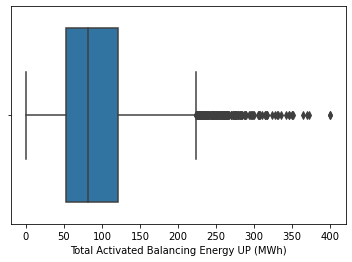

IQR For Total activated balancing energy up (mwh) Column :  68.00474374999999
There are 204 outliers out of 5904 data points.
There are many outliners in Total activated balancing energy up (mwh) columns
Boxplot, IQR, qutliner for Total activated balancing energy down (mwh)


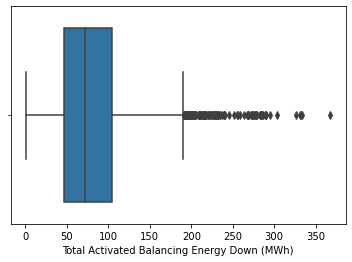

IQR For Total activated balancing energy down (mwh) Column :  57.50277062499999
There are 133 outliers out of 5904 data points.
There are many outliners in Total activated balancing energy down (mwh) columns
Boxplot, IQR, qutliner for Total activated balancing energy (mwh)


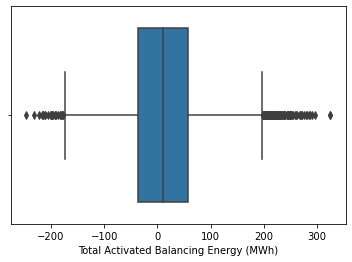

IQR For Total activated balancing energy (mwh) Column :  93.37087541666666
There are 139 outliers out of 5904 data points.
There are many outliners in Total activated balancing energy (mwh) columns
Boxplot, IQR, qutliner for Imbalance price  (€/mwh)


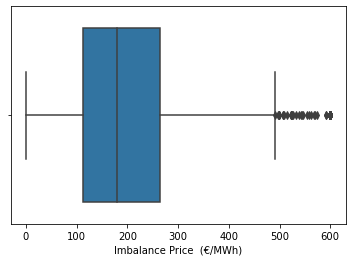

IQR For Imbalance price  (€/mwh) Column :  151.492796376875
There are 66 outliers out of 5904 data points.
There are many outliners in Imbalance price  (€/mwh) columns
Boxplot, IQR, qutliner for Mfrr price up (€/mwh)


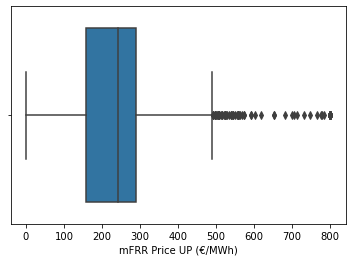

IQR For Mfrr price up (€/mwh) Column :  133.37062500000002
There are 81 outliers out of 5904 data points.
There are many outliners in Mfrr price up (€/mwh) columns
Boxplot, IQR, qutliner for Mfrr price down (€/mwh)


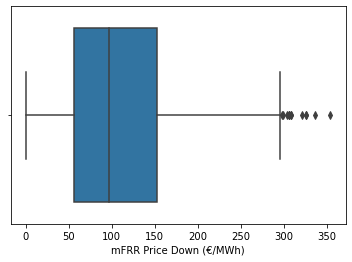

IQR For Mfrr price down (€/mwh) Column :  96.74124999999997
There are 13 outliers out of 5904 data points.
There are many outliners in Mfrr price down (€/mwh) columns
Boxplot, IQR, qutliner for Uplift account 1 (€/mwh)


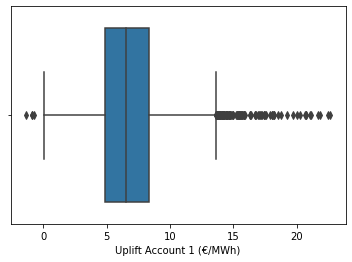

IQR For Uplift account 1 (€/mwh) Column :  3.505742676249998
There are 116 outliers out of 5904 data points.
There are many outliners in Uplift account 1 (€/mwh) columns
Boxplot, IQR, qutliner for Uplift account 2 (€/mwh)


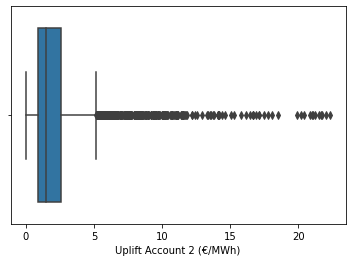

IQR For Uplift account 2 (€/mwh) Column :  1.7167358975
There are 395 outliers out of 5904 data points.
There are many outliners in Uplift account 2 (€/mwh) columns
Boxplot, IQR, qutliner for Uplift account 3 (€/mwh)


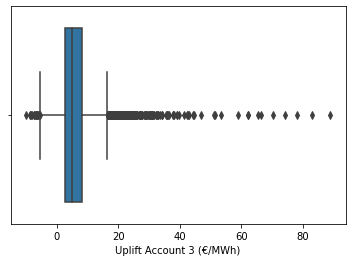

IQR For Uplift account 3 (€/mwh) Column :  5.504303299375
There are 325 outliers out of 5904 data points.
There are many outliners in Uplift account 3 (€/mwh) columns
Boxplot, IQR, qutliner for Res


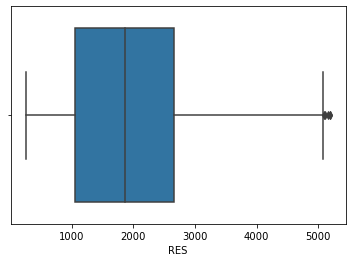

IQR For Res Column :  1610.0
There are 5 outliers out of 5904 data points.
There are many outliners in Res columns
Boxplot, IQR, qutliner for Load


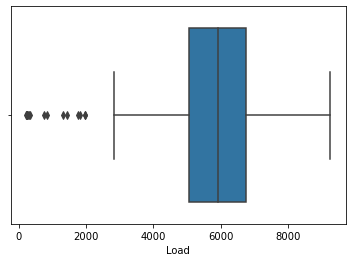

IQR For Load Column :  1709.75
There are 23 outliers out of 5904 data points.
There are many outliners in Load columns
Boxplot, IQR, qutliner for Mandatory hydro


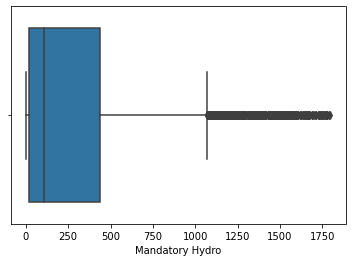

IQR For Mandatory hydro Column :  420.0
There are 598 outliers out of 5904 data points.
There are many outliners in Mandatory hydro columns
Boxplot, IQR, qutliner for Total frr


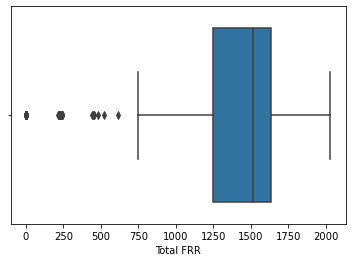

IQR For Total frr Column :  392.0
There are 168 outliers out of 5904 data points.
There are many outliners in Total frr columns
Boxplot, IQR, qutliner for Day_ahead_price


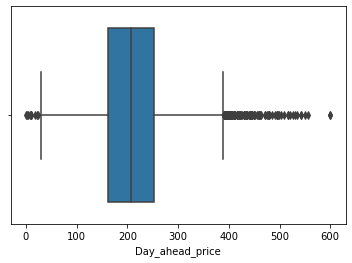

IQR For Day_ahead_price Column :  90.9325
There are 136 outliers out of 5904 data points.
There are many outliners in Day_ahead_price columns
Boxplot, IQR, qutliner for Day_ahead_balancing_diff


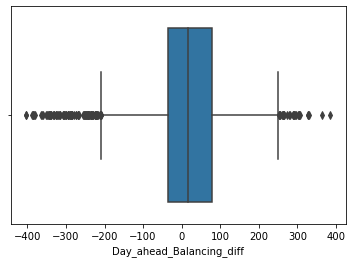

IQR For Day_ahead_balancing_diff Column :  114.85491436624999
There are 119 outliers out of 5904 data points.
There are many outliners in Day_ahead_balancing_diff columns
Boxplot, IQR, qutliner for Diff_direction


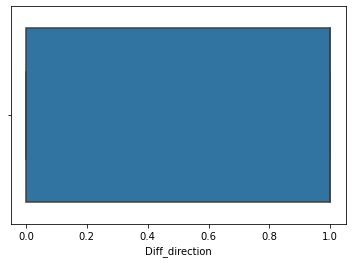

IQR For Diff_direction Column :  1.0
There are 0 outliers out of 5904 data points.
Boxplot, IQR, qutliner for Date


TypeError: Horizontal orientation requires numeric `x` variable.

In [149]:
%matplotlib inline
from scipy import stats
n = combined_dataframes[features[0]].count()
new_df = combined_dataframes.copy()

for name in features: # this was "for name in names"
    print(f"Boxplot, IQR, qutliner for {name.capitalize()}")
    sns.boxplot(x=combined_dataframes[name])
    q1 = combined_dataframes[name].quantile(0.25)
    q3 = combined_dataframes[name].quantile(0.75)
    lower = q1 - 1.5 * stats.iqr(combined_dataframes[name],axis=0)
    upper = q3 + 1.5 * stats.iqr(combined_dataframes[name],axis=0)
    n_outliers = combined_dataframes[combined_dataframes[name] > upper][name].count() + combined_dataframes[combined_dataframes[name] < lower][name].count()
    plt.show()
    print(f"IQR For {name.capitalize()} Column : ",stats.iqr(combined_dataframes[name],axis=0))
    print(f"There are {n_outliers} outliers out of {n} data points.")
    if n_outliers != 0:
        p = n/n_outliers
        if p > 0.1:
            print(f"There are many outliners in {name.capitalize()} columns")
    
    new_df = new_df[new_df[name] < upper]
    new_df = new_df[new_df[name] > lower]

$\textbf{All the prices of the Balancing Market prices that are >= 600 will be replaced with 600}$

In [150]:
combined_dataframes[features[3]].loc[combined_dataframes[features[3]]>= 600 ] = 600

C:\Users\USER\anaconda3\lib\site-packages\pandas\core\indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [151]:
combined_dataframes[features[4]].loc[combined_dataframes[features[4]]>=800] = 800

C:\Users\USER\anaconda3\lib\site-packages\pandas\core\indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [152]:
combined_dataframes[features[11]].loc[combined_dataframes[features[11]]>= 1800] = 1500

C:\Users\USER\anaconda3\lib\site-packages\pandas\core\indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Boxplot, IQR, qutliner for Total activated balancing energy up (mwh)


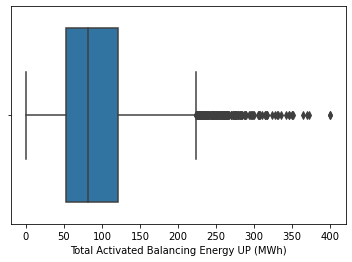

IQR For Total activated balancing energy up (mwh) Column :  68.00474374999999
There are 204 outliers out of 5904 data points.
There are many outliners in Total activated balancing energy up (mwh) columns
Boxplot, IQR, qutliner for Total activated balancing energy down (mwh)


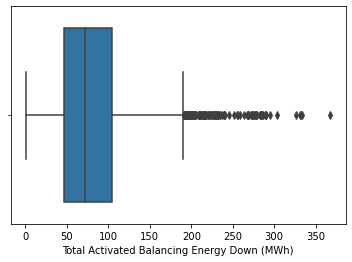

IQR For Total activated balancing energy down (mwh) Column :  57.50277062499999
There are 133 outliers out of 5904 data points.
There are many outliners in Total activated balancing energy down (mwh) columns
Boxplot, IQR, qutliner for Total activated balancing energy (mwh)


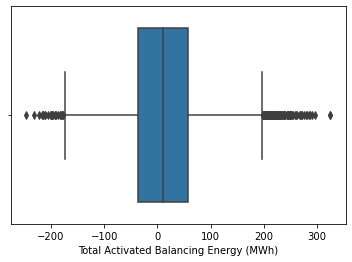

IQR For Total activated balancing energy (mwh) Column :  93.37087541666666
There are 139 outliers out of 5904 data points.
There are many outliners in Total activated balancing energy (mwh) columns
Boxplot, IQR, qutliner for Imbalance price  (€/mwh)


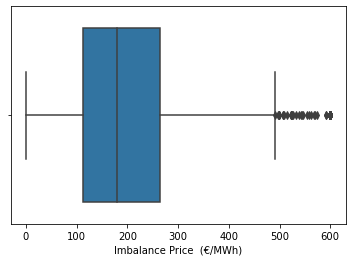

IQR For Imbalance price  (€/mwh) Column :  151.492796376875
There are 66 outliers out of 5904 data points.
There are many outliners in Imbalance price  (€/mwh) columns
Boxplot, IQR, qutliner for Mfrr price up (€/mwh)


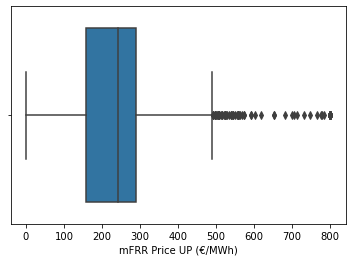

IQR For Mfrr price up (€/mwh) Column :  133.37062500000002
There are 81 outliers out of 5904 data points.
There are many outliners in Mfrr price up (€/mwh) columns
Boxplot, IQR, qutliner for Mfrr price down (€/mwh)


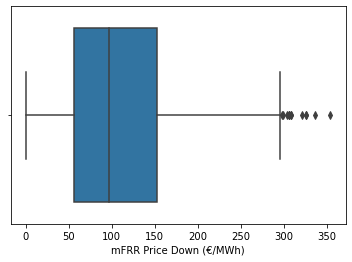

IQR For Mfrr price down (€/mwh) Column :  96.74124999999997
There are 13 outliers out of 5904 data points.
There are many outliners in Mfrr price down (€/mwh) columns
Boxplot, IQR, qutliner for Uplift account 1 (€/mwh)


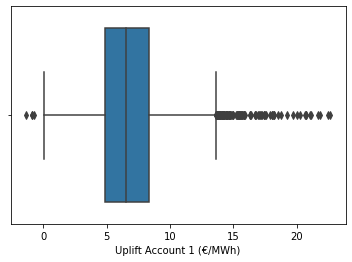

IQR For Uplift account 1 (€/mwh) Column :  3.505742676249998
There are 116 outliers out of 5904 data points.
There are many outliners in Uplift account 1 (€/mwh) columns
Boxplot, IQR, qutliner for Uplift account 2 (€/mwh)


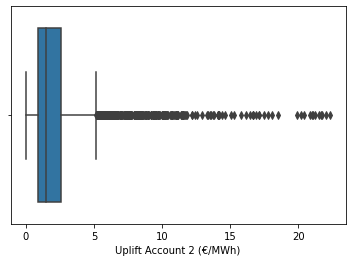

IQR For Uplift account 2 (€/mwh) Column :  1.7167358975
There are 395 outliers out of 5904 data points.
There are many outliners in Uplift account 2 (€/mwh) columns
Boxplot, IQR, qutliner for Uplift account 3 (€/mwh)


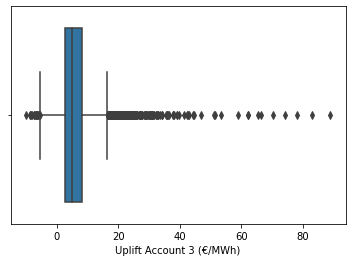

IQR For Uplift account 3 (€/mwh) Column :  5.504303299375
There are 325 outliers out of 5904 data points.
There are many outliners in Uplift account 3 (€/mwh) columns
Boxplot, IQR, qutliner for Res


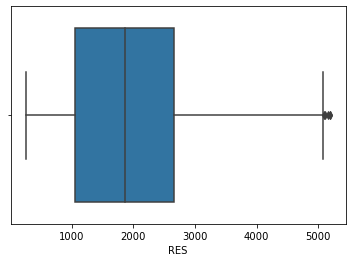

IQR For Res Column :  1610.0
There are 5 outliers out of 5904 data points.
There are many outliners in Res columns
Boxplot, IQR, qutliner for Load


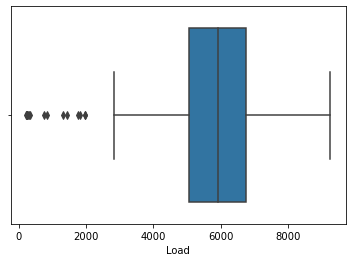

IQR For Load Column :  1709.75
There are 23 outliers out of 5904 data points.
There are many outliners in Load columns
Boxplot, IQR, qutliner for Mandatory hydro


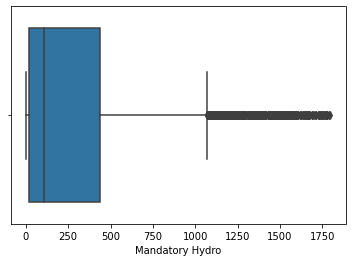

IQR For Mandatory hydro Column :  420.0
There are 598 outliers out of 5904 data points.
There are many outliners in Mandatory hydro columns
Boxplot, IQR, qutliner for Total frr


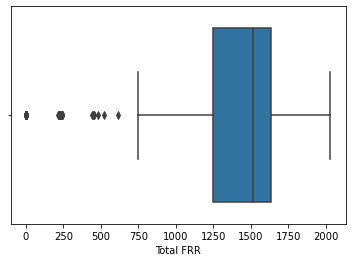

IQR For Total frr Column :  392.0
There are 168 outliers out of 5904 data points.
There are many outliners in Total frr columns
Boxplot, IQR, qutliner for Day_ahead_price


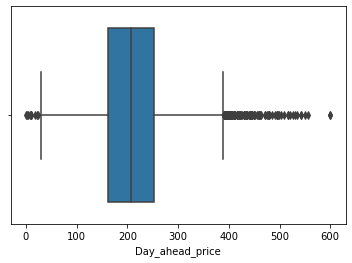

IQR For Day_ahead_price Column :  90.9325
There are 136 outliers out of 5904 data points.
There are many outliners in Day_ahead_price columns
Boxplot, IQR, qutliner for Day_ahead_balancing_diff


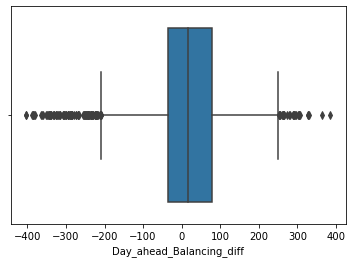

IQR For Day_ahead_balancing_diff Column :  114.85491436624999
There are 119 outliers out of 5904 data points.
There are many outliners in Day_ahead_balancing_diff columns
Boxplot, IQR, qutliner for Diff_direction


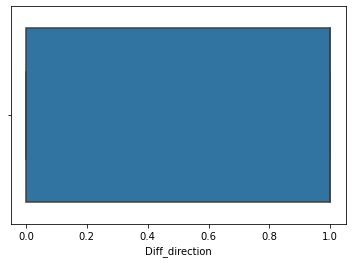

IQR For Diff_direction Column :  1.0
There are 0 outliers out of 5904 data points.
Boxplot, IQR, qutliner for Date


TypeError: Horizontal orientation requires numeric `x` variable.

In [153]:
%matplotlib inline
from scipy import stats
n = combined_dataframes[features[0]].count()
new_df = combined_dataframes.copy()

for name in features: # this was "for name in names"
    print(f"Boxplot, IQR, qutliner for {name.capitalize()}")
    sns.boxplot(x=combined_dataframes[name])
    q1 = combined_dataframes[name].quantile(0.25)
    q3 = combined_dataframes[name].quantile(0.75)
    lower = q1 - 1.5 * stats.iqr(combined_dataframes[name],axis=0)
    upper = q3 + 1.5 * stats.iqr(combined_dataframes[name],axis=0)
    n_outliers = combined_dataframes[combined_dataframes[name] > upper][name].count() + combined_dataframes[combined_dataframes[name] < lower][name].count()
    plt.show()
    print(f"IQR For {name.capitalize()} Column : ",stats.iqr(combined_dataframes[name],axis=0))
    print(f"There are {n_outliers} outliers out of {n} data points.")
    if n_outliers != 0:
        p = n/n_outliers
        if p > 0.1:
            print(f"There are many outliners in {name.capitalize()} columns")
    
    new_df = new_df[new_df[name] < upper]
    new_df = new_df[new_df[name] > lower]

In [154]:
column_names = ['Activated_energy_up','Activated_energy_down','Activated_balancing_energy','Imbalance_price','mFRR_up','mFRR_down','Uplift_account_1','Uplift_account_2','Uplift_account_3','RES','Load','Mandatory_hydro','Total_FRR','Forecasted_load','Day_ahead_price','Day_ahead_Balancing_diff']

In [155]:
combined_dataframes["Diff_direction"] = [1 if int(x) >= 0 else 0 for x in combined_dataframes[features[14]]]

In [156]:
combined_dataframes.head(50)

Total Activated Balancing Energy UP (MWh)  \
2021-08-15 00:00:00                                  64.696300   
2021-08-15 01:00:00                                  47.823965   
2021-08-15 02:00:00                                  37.976322   
2021-08-15 03:00:00                                  36.129990   
2021-08-15 04:00:00                                  34.597000   
2021-08-15 05:00:00                                  23.384867   
2021-08-15 06:00:00                                  56.135750   
2021-08-15 07:00:00                                  62.005892   
2021-08-15 08:00:00                                  32.436923   
2021-08-15 09:00:00                                  31.486835   
2021-08-15 10:00:00                                  38.603487   
2021-08-15 11:00:00                                  43.670228   
2021-08-15 12:00:00                                  39.672798   
2021-08-15 13:00:00                                  55.539810   
2021-08-15 14:00:00                                  76.910937   
2021-08-15 15:00:00                                 115.233335   
2021-08-15 16:00:00                                 140.417470   
2021-08-15 17:00:00                                 132.697350   
2021-08-15 18:00:00                                 122.292862   
2021-08-15 19:00:00                                  71.581340   
2021-08-15 20:00:00                                  31.235560   
2021-08-15 21:00:00                                  43.759552   
2021-08-15 22:00:00                                  46.465165   
2021-08-15 23:00:00                                  43.754770   
2021-08-16 00:00:00                                  14.284785   
2021-08-16 01:00:00                                  26.605528   
2021-08-16 02:00:00                                  68.675700   
2021-08-16 03:00:00                                  78.568782   
2021-08-16 04:00:00                                  89.041165   
2021-08-16 05:00:00                                  70.240287   
2021-08-16 06:00:00                                  34.878080   
2021-08-16 07:00:00                                  34.131830   
2021-08-16 08:00:00                                  22.975915   
2021-08-16 09:00:00                                  33.643535   
2021-08-16 10:00:00                                  38.553425   
2021-08-16 11:00:00                                  62.127308   
2021-08-16 12:00:00                                  63.696287   
2021-08-16 13:00:00                                  58.750933   
2021-08-16 14:00:00                                  65.986845   
2021-08-16 15:00:00                                  72.925900   
2021-08-16 16:00:00                                  75.051018   
2021-08-16 17:00:00                                 109.881187   
2021-08-16 18:00:00                                 146.329070   
2021-08-16 19:00:00                                 152.553685   
2021-08-16 20:00:00                                 174.622543   
2021-08-16 21:00:00                                  97.498503   
2021-08-16 22:00:00                                 103.914363   
2021-08-16 23:00:00                                 126.147207   
2021-08-17 00:00:00                                 102.352847   
2021-08-17 01:00:00                                 103.720825   

                     Total Activated Balancing Energy Down (MWh)  \
2021-08-15 00:00:00                                   162.704473   
2021-08-15 01:00:00                                   117.162650   
2021-08-15 02:00:00                                    56.592600   
2021-08-15 03:00:00                                   105.814593   
2021-08-15 04:00:00                                    90.711290   
2021-08-15 05:00:00                                    88.882660   
2021-08-15 06:00:00                                   116.949175   
2021-08-15 07:00:00                                   131.068113   
2021-08-15 08:00:00                       

In [ ]:
features  = combined_dataframes.columns

In [ ]:
combined_dataframes["Date"] = combined_dataframes.index
combined_dataframes.to_csv('All_data.csv',index=True, encoding='utf-8')

$\textbf{We are going to choose the right model in order to predict the Day Ahead Balancing Difference}$

Regression Model 

Classification Model

$\textbf{1) We are first going to create a classification Model}$

In [157]:
y = combined_dataframes['Diff_direction']
y.value_counts()

1    3408
0    2496
Name: Diff_direction, dtype: int64

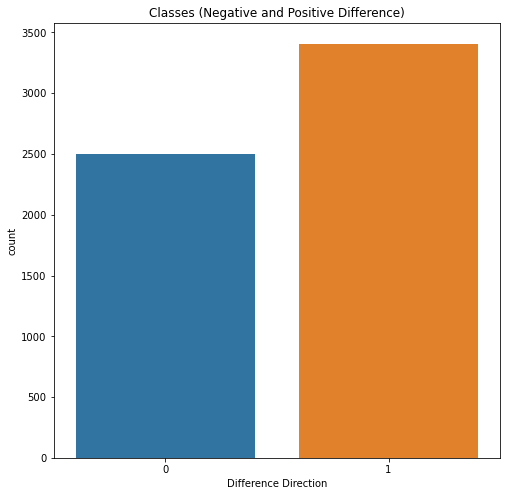

In [158]:
plt.figure(figsize=(8, 8))
sns.countplot(data=combined_dataframes, x='Diff_direction')
plt.title('Classes (Negative and Positive Difference)')
plt.xlabel("Difference Direction")
plt.show()

In [159]:
combined_dataframes.head()
#combined_dataframes = combined_dataframes.drop("Date",axis=1)


Total Activated Balancing Energy UP (MWh)  \
2021-08-15 00:00:00                                  64.696300   
2021-08-15 01:00:00                                  47.823965   
2021-08-15 02:00:00                                  37.976322   
2021-08-15 03:00:00                                  36.129990   
2021-08-15 04:00:00                                  34.597000   

                     Total Activated Balancing Energy Down (MWh)  \
2021-08-15 00:00:00                                   162.704473   
2021-08-15 01:00:00                                   117.162650   
2021-08-15 02:00:00                                    56.592600   
2021-08-15 03:00:00                                   105.814593   
2021-08-15 04:00:00                                    90.711290   

                     Total Activated Balancing Energy (MWh)  \
2021-08-15 00:00:00                              -98.008173   
2021-08-15 01:00:00                              -69.338685   
2021-08-15 02:00:00                              -18.616278   
2021-08-15 03:00:00                              -69.684602   
2021-08-15 04:00:00                              -56.114290   

                     Imbalance Price  (€/MWh)  mFRR Price UP (€/MWh)  \
2021-08-15 00:00:00                 38.036567               141.3900   
2021-08-15 01:00:00                 23.803718                86.9275   
2021-08-15 02:00:00                 25.178707                27.8250   
2021-08-15 03:00:00                  0.010000                28.5925   
2021-08-15 04:00:00                 17.827500                28.5925   

                     mFRR Price Down (€/MWh)  Uplift Account 1 (€/MWh)  \
2021-08-15 00:00:00                  40.7625                  2.738548   
2021-08-15 01:00:00                  26.3325                  2.375837   
2021-08-15 02:00:00                   0.0100                  2.143069   
2021-08-15 03:00:00                   0.0100                  2.043232   
2021-08-15 04:00:00                  17.8275                  2.227400   

                     Uplift Account 2 (€/MWh)  Uplift Account 3 (€/MWh)  \
2021-08-15 00:00:00                  0.662670                  5.481142   
2021-08-15 01:00:00                  1.098814                  2.754350   
2021-08-15 02:00:00                  1.201918                  3.213499   
2021-08-15 03:00:00                  1.117085                  3.079745   
2021-08-15 04:00:00                  1.156230                  2.383576   

                        RES    Load  Mandatory Hydro  Total FRR  \
2021-08-15 00:00:00  1820.0  5515.5             50.0      914.0   
2021-08-15 01:00:00  1930.0  5299.0             50.0      939.0   
2021-08-15 02:00:00  2000.0  5127.5             50.0      949.0   
2021-08-15 03:00:00  2035.0  5038.0             63.0      939.0   
2021-08-15 04:00:00  2055.0  4951.5             76.0     1079.0   

                     Day_ahead_price  Day_ahead_Balancing_diff  \
2021-08-15 00:00:00            95.16                 57.123433   
2021-08-15 01:00:00           103.16                 79.356282   
2021-08-15 02:00:00            91.91                 66.731293   
2021-08-15 03:00:00            77.00                 76.990000   
2021-08-15 04:00:00            83.80                 65.972500   

                     Diff_direction                Date  
2021-08-15 00:00:00               1 2021-08-15 00:00:00  
2021-08-15 01:00:00               1 2021-08-15 01:00:00  
2021-08-15 02:00:00               1 2021-08-15 02:00:00  
2021-08-15 03:00:00               1 2021-08-15 03:00:00  
2021-08-15 04:00:00               1 2021-08-15 04:00:00

In [94]:
x = combined_dataframes.drop([features[3],features[13],features[14],features[15],"Date"], axis=1)
x.head(100)

Total Activated Balancing Energy UP (MWh)  \
2021-08-15 00:00:00                                  64.696300   
2021-08-15 01:00:00                                  47.823965   
2021-08-15 02:00:00                                  37.976322   
2021-08-15 03:00:00                                  36.129990   
2021-08-15 04:00:00                                  34.597000   
2021-08-15 05:00:00                                  23.384867   
2021-08-15 06:00:00                                  56.135750   
2021-08-15 07:00:00                                  62.005892   
2021-08-15 08:00:00                                  32.436923   
2021-08-15 09:00:00                                  31.486835   
2021-08-15 10:00:00                                  38.603487   
2021-08-15 11:00:00                                  43.670228   
2021-08-15 12:00:00                                  39.672798   
2021-08-15 13:00:00                                  55.539810   
2021-08-15 14:00:00                                  76.910937   
2021-08-15 15:00:00                                 115.233335   
2021-08-15 16:00:00                                 140.417470   
2021-08-15 17:00:00                                 132.697350   
2021-08-15 18:00:00                                 122.292862   
2021-08-15 19:00:00                                  71.581340   
2021-08-15 20:00:00                                  31.235560   
2021-08-15 21:00:00                                  43.759552   
2021-08-15 22:00:00                                  46.465165   
2021-08-15 23:00:00                                  43.754770   
2021-08-16 00:00:00                                  14.284785   
2021-08-16 01:00:00                                  26.605528   
2021-08-16 02:00:00                                  68.675700   
2021-08-16 03:00:00                                  78.568782   
2021-08-16 04:00:00                                  89.041165   
2021-08-16 05:00:00                                  70.240287   
2021-08-16 06:00:00                                  34.878080   
2021-08-16 07:00:00                                  34.131830   
2021-08-16 08:00:00                                  22.975915   
2021-08-16 09:00:00                                  33.643535   
2021-08-16 10:00:00                                  38.553425   
2021-08-16 11:00:00                                  62.127308   
2021-08-16 12:00:00                                  63.696287   
2021-08-16 13:00:00                                  58.750933   
2021-08-16 14:00:00                                  65.986845   
2021-08-16 15:00:00                                  72.925900   
2021-08-16 16:00:00                                  75.051018   
2021-08-16 17:00:00                                 109.881187   
2021-08-16 18:00:00                                 146.329070   
2021-08-16 19:00:00                                 152.553685   
2021-08-16 20:00:00                                 174.622543   
2021-08-16 21:00:00                                  97.498503   
2021-08-16 22:00:00                                 103.914363   
2021-08-16 23:00:00                                 126.147207   
2021-08-17 00:00:00                                 102.352847   
2021-08-17 01:00:00                                 103.720825   
2021-08-17 02:00:00                                  77.870902   
2021-08-17 03:00:00                                  73.393180   
2021-08-17 04:00:00                                  67.051213   
2021-08-17 05:00:00                                  74.816285   
2021-08-17 06:00:00                                  81.145027   
2021-08-17 07:00:00                                  71.166612   
2021-08-17 08:00:00                                  36.785637   
2021-08-17 09:00:00                                  31.828213   
2021-08-17 10:00:00                                  32.978278   
2021-08-17 11:00:00                                  43.62552

In [95]:
combined_dataframes.head()

Total Activated Balancing Energy UP (MWh)  \
2021-08-15 00:00:00                                  64.696300   
2021-08-15 01:00:00                                  47.823965   
2021-08-15 02:00:00                                  37.976322   
2021-08-15 03:00:00                                  36.129990   
2021-08-15 04:00:00                                  34.597000   

                     Total Activated Balancing Energy Down (MWh)  \
2021-08-15 00:00:00                                   162.704473   
2021-08-15 01:00:00                                   117.162650   
2021-08-15 02:00:00                                    56.592600   
2021-08-15 03:00:00                                   105.814593   
2021-08-15 04:00:00                                    90.711290   

                     Total Activated Balancing Energy (MWh)  \
2021-08-15 00:00:00                              -98.008173   
2021-08-15 01:00:00                              -69.338685   
2021-08-15 02:00:00                              -18.616278   
2021-08-15 03:00:00                              -69.684602   
2021-08-15 04:00:00                              -56.114290   

                     Imbalance Price  (€/MWh)  mFRR Price UP (€/MWh)  \
2021-08-15 00:00:00                 38.036567               141.3900   
2021-08-15 01:00:00                 23.803718                86.9275   
2021-08-15 02:00:00                 25.178707                27.8250   
2021-08-15 03:00:00                  0.010000                28.5925   
2021-08-15 04:00:00                 17.827500                28.5925   

                     mFRR Price Down (€/MWh)  Uplift Account 1 (€/MWh)  \
2021-08-15 00:00:00                  40.7625                  2.738548   
2021-08-15 01:00:00                  26.3325                  2.375837   
2021-08-15 02:00:00                   0.0100                  2.143069   
2021-08-15 03:00:00                   0.0100                  2.043232   
2021-08-15 04:00:00                  17.8275                  2.227400   

                     Uplift Account 2 (€/MWh)  Uplift Account 3 (€/MWh)  \
2021-08-15 00:00:00                  0.662670                  5.481142   
2021-08-15 01:00:00                  1.098814                  2.754350   
2021-08-15 02:00:00                  1.201918                  3.213499   
2021-08-15 03:00:00                  1.117085                  3.079745   
2021-08-15 04:00:00                  1.156230                  2.383576   

                        RES    Load  Mandatory Hydro  Total FRR  \
2021-08-15 00:00:00  1820.0  5515.5             50.0      914.0   
2021-08-15 01:00:00  1930.0  5299.0             50.0      939.0   
2021-08-15 02:00:00  2000.0  5127.5             50.0      949.0   
2021-08-15 03:00:00  2035.0  5038.0             63.0      939.0   
2021-08-15 04:00:00  2055.0  4951.5             76.0     1079.0   

                     Day_ahead_price  Day_ahead_Balancing_diff  \
2021-08-15 00:00:00            95.16                 57.123433   
2021-08-15 01:00:00           103.16                 79.356282   
2021-08-15 02:00:00            91.91                 66.731293   
2021-08-15 03:00:00            77.00                 76.990000   
2021-08-15 04:00:00            83.80                 65.972500   

                     Diff_direction                Date  
2021-08-15 00:00:00               1 2021-08-15 00:00:00  
2021-08-15 01:00:00               1 2021-08-15 01:00:00  
2021-08-15 02:00:00               1 2021-08-15 02:00:00  
2021-08-15 03:00:00               1 2021-08-15 03:00:00  
2021-08-15 04:00:00               1 2021-08-15 04:00:00

In [68]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,y_test = train_test_split(x,y, test_size=0.25)

In [69]:
X_train.head()
X_test.head()

Total Activated Balancing Energy UP (MWh)  \
2021-11-02 03:00:00                                  25.884393   
2022-01-16 09:00:00                                  99.966410   
2022-01-29 21:00:00                                  96.547475   
2021-10-12 03:00:00                                  20.854990   
2021-12-08 09:00:00                                  50.025340   

                     Total Activated Balancing Energy Down (MWh)  \
2021-11-02 03:00:00                                    83.440870   
2022-01-16 09:00:00                                    48.845633   
2022-01-29 21:00:00                                   111.853862   
2021-10-12 03:00:00                                    96.620840   
2021-12-08 09:00:00                                   171.177717   

                     Total Activated Balancing Energy (MWh)  \
2021-11-02 03:00:00                              -57.556477   
2022-01-16 09:00:00                               51.120778   
2022-01-29 21:00:00                              -15.306388   
2021-10-12 03:00:00                              -75.765850   
2021-12-08 09:00:00                             -121.152378   

                     mFRR Price UP (€/MWh)  mFRR Price Down (€/MWh)  \
2021-11-02 03:00:00               234.2275                   0.0000   
2022-01-16 09:00:00               252.0000                 106.0050   
2022-01-29 21:00:00               316.9250                 160.9175   
2021-10-12 03:00:00               154.0000                  44.8300   
2021-12-08 09:00:00               271.9750                 167.4825   

                     Uplift Account 1 (€/MWh)  Uplift Account 2 (€/MWh)  \
2021-11-02 03:00:00                  2.510656                  3.784583   
2022-01-16 09:00:00                  7.776898                  3.085880   
2022-01-29 21:00:00                  7.021152                  2.130855   
2021-10-12 03:00:00                  4.549856                  0.994452   
2021-12-08 09:00:00                  7.249470                  1.024963   

                     Uplift Account 3 (€/MWh)     RES    Load  \
2021-11-02 03:00:00                  5.964252  1540.0  4226.0   
2022-01-16 09:00:00                  7.316955  2605.0  7052.5   
2022-01-29 21:00:00                 11.700307  2615.0  6792.0   
2021-10-12 03:00:00                  2.863162   970.0  4070.0   
2021-12-08 09:00:00                  3.622611  2810.0  7176.5   

                     Mandatory Hydro  Total FRR  
2021-11-02 03:00:00              0.0      884.0  
2022-01-16 09:00:00           1101.0     1461.0  
2022-01-29 21:00:00            280.0     1741.0  
2021-10-12 03:00:00              0.0      914.0  
2021-12-08 09:00:00            363.0     1494.0

In [70]:
num_columns = X_train.columns

$\textbf{a) Logistic Regression Classification}$

In [178]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        print("_______________________________________________")
        print(f"ROV CURVE SCORE \n {roc_auc_score(y_train,pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")      
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")
        print("_______________________________________________")
        print(f"ROC CURVE SCORE :\n {roc_auc_score(y_test,pred)}\n")

In [72]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

# cat_columns = []


ct = make_column_transformer(
    (MinMaxScaler(), num_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [73]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)

print_score(lr_clf, X_train, y_train, X_test, y_test, train=True)
print_score(lr_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 83.88%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.815934     0.854678  0.838753     0.835306      0.838368
recall        0.796674     0.869345  0.838753     0.833009      0.838753
f1-score      0.806189     0.861949  0.838753     0.834069      0.838476
support    1864.000000  2564.000000  0.838753  4428.000000   4428.000000
_______________________________________________
Confusion Matrix: 
 [[1485  379]
 [ 335 2229]]

_______________________________________________
ROV CURVE SCORE 
 0.8330092967667205

Test Result:
Accuracy Score: 82.99%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.809756    0.844367  0.829946     0.827062      0.829547
recall       0.787975    0.861374  0.829946     0.824675      0.829946
f1-score     0.798717    

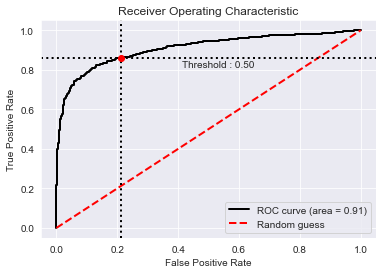

In [74]:
from plot_metric.functions import BinaryClassification
logistic_prob = lr_clf.predict_proba(X=X_test)[:,1]
bc = BinaryClassification(y_test, logistic_prob, labels=["Class 1", "Class 1"])

bc.plot_roc_curve()
plt.show()

$\textbf{b) Linear Discriminant Analysis}$

In [75]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
linear_discriminator = LDA(solver='lsqr', shrinkage='auto')
lda_fit_train = linear_discriminator.fit(X_train, y_train)

In [76]:
lda_train_score = linear_discriminator.score(X_train,y_train)
lda_test_score  = linear_discriminator.score(X_test,y_test)

In [77]:
print("LDA Score Train Dataset: ", lda_train_score)
print("LDA Score Test Dataset:" , lda_test_score)

LDA Score Train Dataset:  0.8328816621499548
LDA Score Test Dataset: 0.8197831978319783


In [78]:
from sklearn.linear_model import LogisticRegression

print_score(linear_discriminator, X_train, y_train, X_test, y_test, train=True)
print_score(linear_discriminator, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 83.29%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.823360     0.839033  0.832882     0.831197      0.832436
recall        0.767704     0.880265  0.832882     0.823985      0.832882
f1-score      0.794559     0.859155  0.832882     0.826857      0.831963
support    1864.000000  2564.000000  0.832882  4428.000000   4428.000000
_______________________________________________
Confusion Matrix: 
 [[1431  433]
 [ 307 2257]]

_______________________________________________
ROV CURVE SCORE 
 0.8239845366346843

Test Result:
Accuracy Score: 81.98%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.823322    0.817582  0.819783     0.820452      0.820040
recall       0.737342    0.881517  0.819783     0.809429      0.819783
f1-score     0.777963    

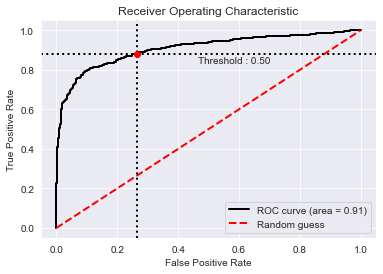

In [79]:
from plot_metric.functions import BinaryClassification
linear_discriminant_prob = linear_discriminator.predict_proba(X=X_test)[:,1]
bc_linear_discriminator = BinaryClassification(y_test, linear_discriminant_prob, labels=["Class 1", "Class 1"])

bc_linear_discriminator.plot_roc_curve()
plt.show()

$\textbf{Neural Network Classification}$

In [171]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

clf1 = MLPClassifier(
    hidden_layer_sizes=(3),
    activation="relu",
    verbose=True,
    max_iter=1000
)
clf2 = MLPClassifier(
    hidden_layer_sizes=(10),
    activation="logistic",
    verbose=False,
    max_iter=10000
)

clf3 = MLPClassifier(
    hidden_layer_sizes=(50,25),
    activation="tanh",
    verbose=False,
    max_iter=10000
)

In [81]:
# Fitting MinMax Scaler to features
clf1.fit(X_train, y_train.values.ravel())
clf2.fit(X_train, y_train.values.ravel())
clf3.fit(X_train, y_train.values.ravel())

# ROC Curve
fpr1, tpr1, threshold1 = roc_curve(y_test.values, clf1.predict_proba(X_test)[:,1])
fpr2, tpr2, threshold2 = roc_curve(y_test.values, clf2.predict_proba(X_test)[:,1])
fpr3, tpr3, threshold3 = roc_curve(y_test.values, clf3.predict_proba(X_test)[:,1])

Iteration 1, loss = 0.75895196
Iteration 2, loss = 0.73453536
Iteration 3, loss = 0.70781934
Iteration 4, loss = 0.67771157
Iteration 5, loss = 0.64350470
Iteration 6, loss = 0.60695903
Iteration 7, loss = 0.57085356
Iteration 8, loss = 0.53747636
Iteration 9, loss = 0.50806867
Iteration 10, loss = 0.48378279
Iteration 11, loss = 0.46381174
Iteration 12, loss = 0.44833538
Iteration 13, loss = 0.43612399
Iteration 14, loss = 0.42642493
Iteration 15, loss = 0.41903662
Iteration 16, loss = 0.41290092
Iteration 17, loss = 0.40788170
Iteration 18, loss = 0.40391552
Iteration 19, loss = 0.40066267
Iteration 20, loss = 0.39806093
Iteration 21, loss = 0.39591767
Iteration 22, loss = 0.39378601
Iteration 23, loss = 0.39215669
Iteration 24, loss = 0.39070116
Iteration 25, loss = 0.38946834
Iteration 26, loss = 0.38801841
Iteration 27, loss = 0.38690220
Iteration 28, loss = 0.38579140
Iteration 29, loss = 0.38467257
Iteration 30, loss = 0.38358335
Iteration 31, loss = 0.38267344
Iteration 32, los

0.8529810298102981
0.8502710027100271
0.8541102077687444
0.8455284552845529
0.9966124661246613
0.8265582655826558


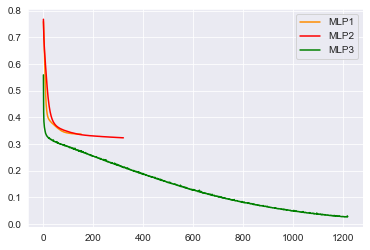

In [82]:
print(clf1.score(X_train, y_train.values.ravel()))
print(clf1.score(X_test, y_test.values.ravel()))
print(clf2.score(X_train, y_train.values.ravel()))
print(clf2.score(X_test, y_test.values.ravel()))
print(clf3.score(X_train, y_train.values.ravel()))
print(clf3.score(X_test, y_test.values.ravel()))


roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)

plt.plot(clf1.loss_curve_,color="darkorange",label="MLP1")
plt.plot(clf2.loss_curve_,color="red",label="MLP2")
plt.plot(clf3.loss_curve_,color="green",label="MLP3")

#pyplot.plot(clf4.loss_curve_,color="purple" , label = "MLP4")
plt.legend(loc="upper right")
plt.show()

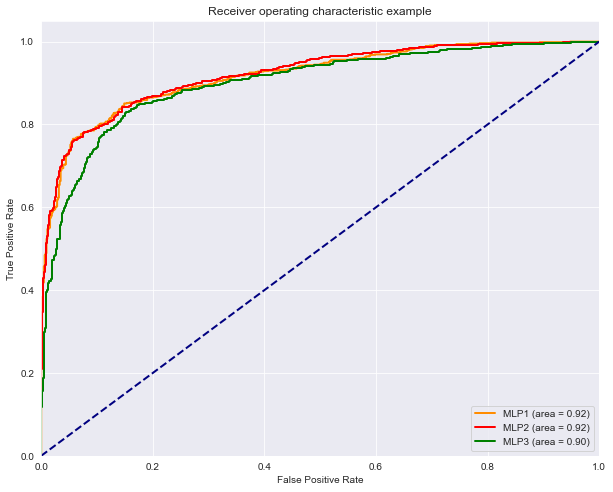

In [83]:
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(
    fpr1,
    tpr1,
    color="darkorange",
    lw=lw,
    label="MLP1 (area = %0.2f)" % roc_auc1,
)
plt.plot(
    fpr2,
    tpr2,
    color="red",
    lw=lw,
    label="MLP2 (area = %0.2f)" % roc_auc2,
)
plt.plot(
    fpr3,
    tpr3,
    color="green",
    lw=lw,
    label="MLP3 (area = %0.2f)" % roc_auc3,
)

# We want bigger AUC to justify which clasifier outpermorms

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

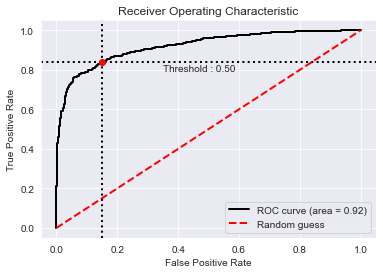

In [84]:
from plot_metric.functions import BinaryClassification
MLP2_classification_prob = clf2.predict_proba(X=X_test)[:,1]
bc_MLP2 = BinaryClassification(y_test, MLP2_classification_prob, labels=["Class 1", "Class 1"])

bc_MLP2.plot_roc_curve()
plt.show()

In [85]:
from sklearn.linear_model import LogisticRegression

print_score(clf2, X_train, y_train, X_test, y_test, train=True)
print_score(clf2, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 85.41%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.794773     0.906012   0.85411     0.850392      0.859185
recall        0.880901     0.834633   0.85411     0.857767      0.854110
f1-score      0.835623     0.868859   0.85411     0.852241      0.854868
support    1864.000000  2564.000000   0.85411  4428.000000   4428.000000
_______________________________________________
Confusion Matrix: 
 [[1642  222]
 [ 424 2140]]

_______________________________________________
ROV CURVE SCORE 
 0.8577673364445308

Test Result:
Accuracy Score: 84.55%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.800595    0.883085  0.845528     0.841840      0.847764
recall       0.851266    0.841232  0.845528     0.846249      0.845528
f1-score     0.825153    

$\textbf{Boosted Decision Trees Classification}$

In [86]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve ,KFold

In [87]:
GradientBoosting = GradientBoostingClassifier( min_samples_leaf = 70, min_samples_split = 1000,learning_rate= 0.01 , n_estimators =60 , max_depth = 3)
gradient_fit = GradientBoosting.fit(X_train, y_train)

C:\Users\USER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


   CrossVal_Score_Means  CrossValerrors                    Algo
0              0.844168        0.017792  RandomForestClassifier
1              0.855010        0.016787      AdaBoostClassifier
2              0.857948        0.014069       Gradient Boosting
3              0.800144        0.014364  DecisionTreeClassifier


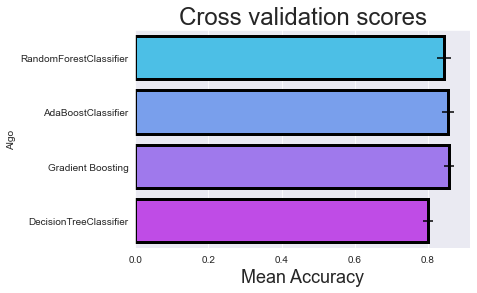

<Figure size 1080x504 with 0 Axes>

In [88]:
kfold = StratifiedKFold(n_splits=8,shuffle=True, random_state=42)

rs = 15
clrs = []

clrs.append(AdaBoostClassifier(random_state=rs))
clrs.append(GradientBoostingClassifier(random_state=rs))
clrs.append(RandomForestClassifier(random_state=rs))
clrs.append(DecisionTreeClassifier(random_state = rs))

cv_results = []
for clr in clrs :
    cv_results.append(cross_val_score(clr, X_train, y_train , scoring = 'accuracy', cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_df = pd.DataFrame({"CrossVal_Score_Means":cv_means,"CrossValerrors": cv_std,"Algo":["RandomForestClassifier","AdaBoostClassifier","Gradient Boosting",'DecisionTreeClassifier']})
g = sns.barplot("CrossVal_Score_Means","Algo",data = cv_df,orient = "h",**{'xerr':cv_std},palette='cool',edgecolor="black",linewidth=3)
g.set_xlabel("Mean Accuracy",fontsize = 18)
g = g.set_title("Cross validation scores",fontsize = 24)
plt.figure(figsize = (15,7))
print(cv_df)

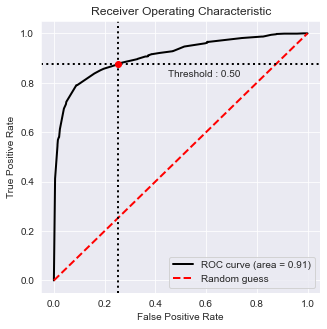

In [89]:
gradient_boost_roc = gradient_fit.predict_proba(X=X_test)
bc = BinaryClassification(y_test, gradient_boost_roc[:,1], labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

In [90]:
from sklearn.linear_model import LogisticRegression

print_score(gradient_fit, X_train, y_train, X_test, y_test, train=True)
print_score(gradient_fit, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 82.97%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.822300     0.834442   0.82972     0.828371      0.829331
recall        0.759657     0.880655   0.82972     0.820156      0.829720
f1-score      0.789738     0.856926   0.82972     0.823332      0.828643
support    1864.000000  2564.000000   0.82972  4428.000000   4428.000000
_______________________________________________
Confusion Matrix: 
 [[1416  448]
 [ 306 2258]]

_______________________________________________
ROV CURVE SCORE 
 0.8201559392847817

Test Result:
Accuracy Score: 82.05%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.816926    0.822742  0.820461     0.819834      0.820252
recall       0.748418    0.874408  0.820461     0.811413      0.820461
f1-score     0.781173    

$\textbf{Feature Selection}$

* Back propagation to see the importance of each feature based on the ROC AUC Metric Score  

In [91]:
##### Create a list of 11 random colors
from random import randint
color = []
n = 12
for i in range(n):
    color.append('#%06X' % randint(0, 0xFFFFFF))

In [92]:
x = combined_dataframes.drop([features[3],features[13],features[14],features[15],"Date"], axis=1)
x.head()

y = combined_dataframes['Diff_direction']
y.value_counts()

1    3408
0    2496
Name: Diff_direction, dtype: int64

In [93]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,y_test = train_test_split(x,y, test_size=0.25)

1) Logistic Regression 

In [94]:
header_list = [
    'Total Activated Balancing Energy UP (MWh)',
    'Total Activated Balancing Energy Down (MWh)',
    'Total Activated Balancing Energy (MWh)',
    'mFRR Price UP (€/MWh)',
    'mFRR Price Down (€/MWh)',
    'Uplift Account 1 (€/MWh)',
    'Uplift Account 2 (€/MWh)',
    'Uplift Account 3 (€/MWh)',
    'RES',
    'Load',
    'Mandatory Hydro',
    'Total FRR'    
]
cols=header_list
X_train_df = pd.DataFrame(X_train, columns=cols)

['Total Activated Balancing Energy UP (MWh)', 'Total Activated Balancing Energy Down (MWh)', 'Total Activated Balancing Energy (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro', 'Total FRR']
['Total Activated Balancing Energy Down (MWh)', 'Total Activated Balancing Energy (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro', 'Total FRR']


C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


['Total Activated Balancing Energy Down (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro', 'Total FRR']
['Total Activated Balancing Energy Down (MWh)', 'mFRR Price UP (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro', 'Total FRR']
['Total Activated Balancing Energy Down (MWh)', 'mFRR Price UP (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro', 'Total FRR']


C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


['Total Activated Balancing Energy Down (MWh)', 'mFRR Price UP (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'Load', 'Mandatory Hydro', 'Total FRR']


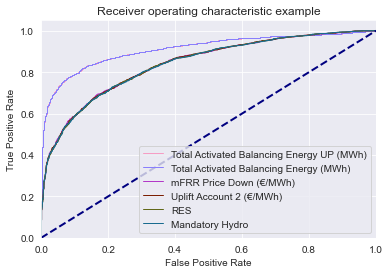

<Figure size 432x288 with 0 Axes>

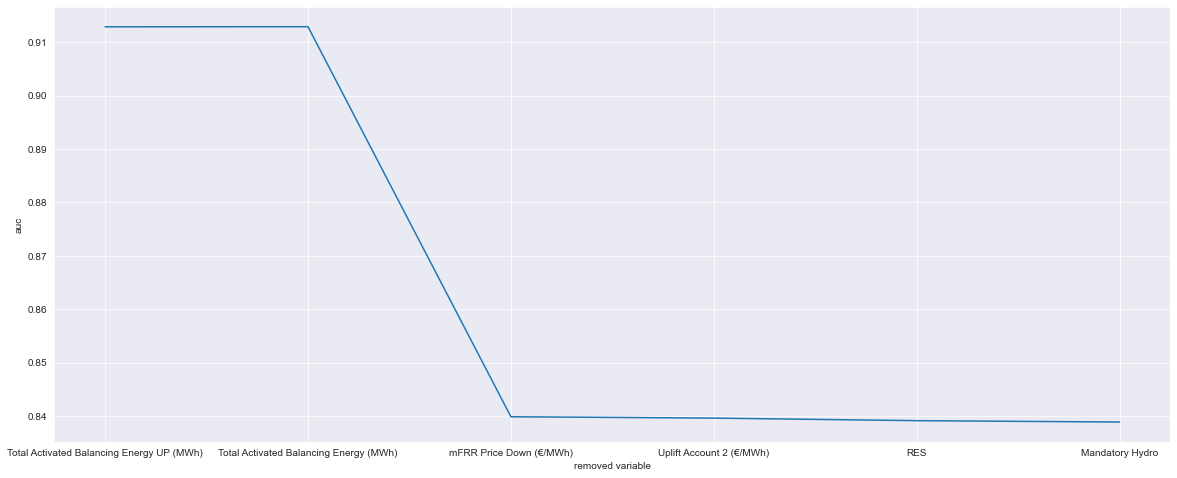

In [95]:
x = []
y = []

plt.figure()
count = 0
color_list = color
for k in cols:
    vars1 = cols.copy()
    cols.remove(k)
    print(vars1)
    lr_clf.fit(X_train_df[vars1].values,y_train.values.ravel())
    fpr, tpr, threshold = roc_curve(y_train, lr_clf.predict_proba(X_train_df[vars1])[:,1])
    roc_auc = auc(fpr, tpr)
    x.append(k)
    y.append(roc_auc)
    
   
    plt.plot(
    fpr,
    tpr,
    color=color_list[count],
    lw=1,
    label=k
    )
    count+=1


plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()


plot1 = plt.figure(1)
plt.figure(figsize=(20, 8))
plt.ylabel('auc')
plt.xlabel('removed variable')
plt.plot(x, y)
plt.show()

2) Neural Network with Logistic Activation Function 

In [96]:
header_list = [
    'Total Activated Balancing Energy UP (MWh)',
    'Total Activated Balancing Energy Down (MWh)',
    'Total Activated Balancing Energy (MWh)',
    'mFRR Price UP (€/MWh)',
    'mFRR Price Down (€/MWh)',
    'Uplift Account 1 (€/MWh)',
    'Uplift Account 2 (€/MWh)',
    'Uplift Account 3 (€/MWh)',
    'RES',
    'Load',
    'Mandatory Hydro',
    'Total FRR'    
]
cols=header_list
X_train_df = pd.DataFrame(X_train, columns=cols)

['Total Activated Balancing Energy UP (MWh)', 'Total Activated Balancing Energy Down (MWh)', 'Total Activated Balancing Energy (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro', 'Total FRR']


C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


['Total Activated Balancing Energy Down (MWh)', 'Total Activated Balancing Energy (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro', 'Total FRR']


C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


['Total Activated Balancing Energy Down (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro', 'Total FRR']


C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


['Total Activated Balancing Energy Down (MWh)', 'mFRR Price UP (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro', 'Total FRR']


C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


['Total Activated Balancing Energy Down (MWh)', 'mFRR Price UP (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro', 'Total FRR']


C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


['Total Activated Balancing Energy Down (MWh)', 'mFRR Price UP (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'Load', 'Mandatory Hydro', 'Total FRR']


C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


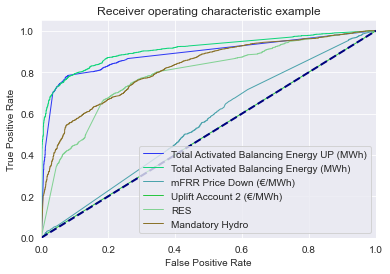

<Figure size 432x288 with 0 Axes>

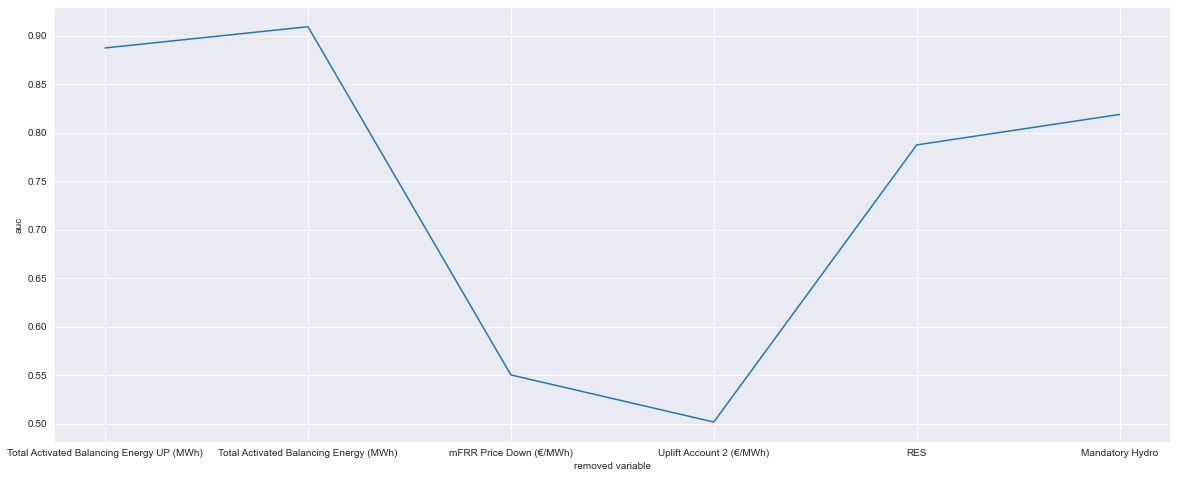

In [318]:
x = []
y = []

plt.figure()
count = 0
color_list = color
for k in cols:
    vars1 = cols.copy()
    cols.remove(k)
    print(vars1)
    clf2.fit(X_train_df[vars1].values,y_train.values.ravel())
    fpr, tpr, threshold = roc_curve(y_train, clf2.predict_proba(X_train_df[vars1])[:,1])
    roc_auc = auc(fpr, tpr)
    x.append(k)
    y.append(roc_auc)
    
   
    plt.plot(
    fpr,
    tpr,
    color=color_list[count],
    lw=1,
    label=k
    )
    count+=1


plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()


plot1 = plt.figure(1)
plt.figure(figsize=(20, 8))
plt.ylabel('auc')
plt.xlabel('removed variable')
plt.plot(x, y)
plt.show()

3) Linear Discriminator 

In [294]:
header_list = [
    'Total Activated Balancing Energy UP (MWh)',
    'Total Activated Balancing Energy Down (MWh)',
    'Total Activated Balancing Energy (MWh)',
    'mFRR Price UP (€/MWh)',
    'mFRR Price Down (€/MWh)',
    'Uplift Account 1 (€/MWh)',
    'Uplift Account 2 (€/MWh)',
    'Uplift Account 3 (€/MWh)',
    'RES',
    'Load',
    'Mandatory Hydro'
]
cols=header_list
X_train_df = pd.DataFrame(X_train, columns=cols)

['Total Activated Balancing Energy UP (MWh)', 'Total Activated Balancing Energy Down (MWh)', 'Total Activated Balancing Energy (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro']
['Total Activated Balancing Energy Down (MWh)', 'Total Activated Balancing Energy (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro']
['Total Activated Balancing Energy Down (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro']
['Total Activated Balancing Energy Down (MWh)', 'mFRR Price UP (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro']
['Total Activated Balancin

C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LinearDiscriminantAnalysis was fitted without feature names
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LinearDiscriminantAnalysis was fitted without feature names
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LinearDiscriminantAnalysis was fitted without feature names
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LinearDiscriminantAnalysis was fitted without feature names
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LinearDiscriminantAnalysis was fitted without feature names
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LinearDis

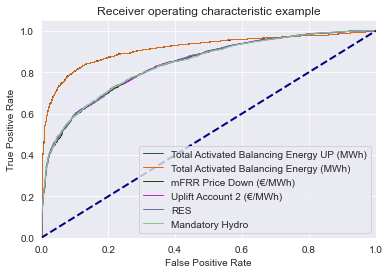

<Figure size 432x288 with 0 Axes>

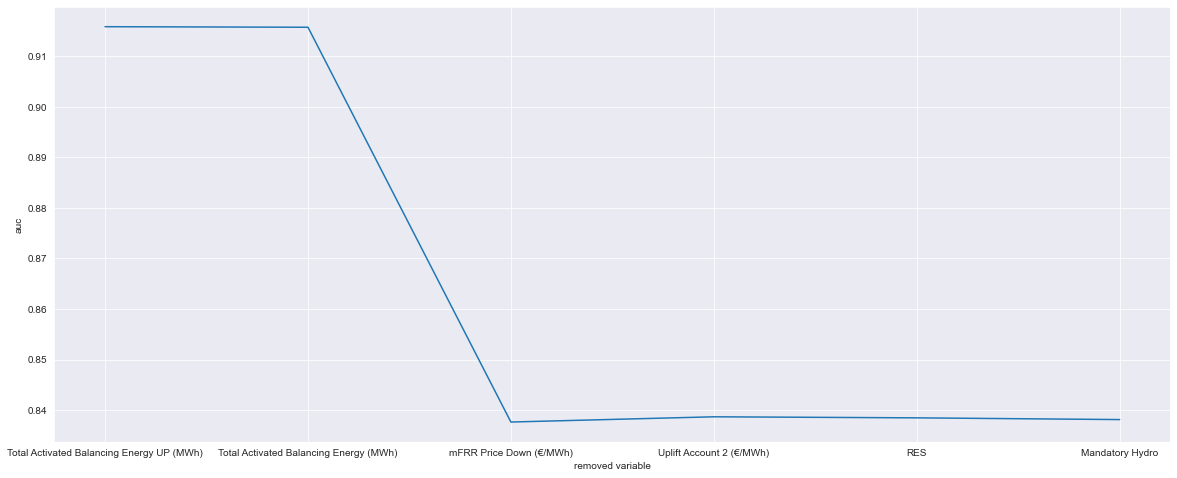

In [295]:


x = []
y = []


plt.figure()
count = 0
color_list = color
for k in cols:
    vars1 = cols.copy()
    cols.remove(k)
    print(vars1)
    lda_fit_train.fit(X_train_df[vars1].values,y_train.values.ravel())
    fpr, tpr, threshold = roc_curve(y_train, lda_fit_train.predict_proba(X_train_df[vars1])[:,1])
    roc_auc = auc(fpr, tpr)
    x.append(k)
    y.append(roc_auc)

    plt.plot(
    fpr,
    tpr,
    color=color_list[count],
    lw=1,
    label=k
    )
    count+=1

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

plot1 = plt.figure(1)
plt.figure(figsize=(20, 8))
plt.ylabel('auc')
plt.xlabel('removed variable')
plt.plot(x, y)
plt.show()

4) Gradient Boosting

In [296]:
header_list = [
    'Total Activated Balancing Energy UP (MWh)',
    'Total Activated Balancing Energy Down (MWh)',
    'Total Activated Balancing Energy (MWh)',
    'mFRR Price UP (€/MWh)',
    'mFRR Price Down (€/MWh)',
    'Uplift Account 1 (€/MWh)',
    'Uplift Account 2 (€/MWh)',
    'Uplift Account 3 (€/MWh)',
    'RES',
    'Load',
    'Mandatory Hydro'
]
cols=header_list
X_train_df = pd.DataFrame(X_train, columns=cols)

['Total Activated Balancing Energy UP (MWh)', 'Total Activated Balancing Energy Down (MWh)', 'Total Activated Balancing Energy (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro']


C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


['Total Activated Balancing Energy Down (MWh)', 'Total Activated Balancing Energy (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro']


C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


['Total Activated Balancing Energy Down (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro']


C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


['Total Activated Balancing Energy Down (MWh)', 'mFRR Price UP (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro']


C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


['Total Activated Balancing Energy Down (MWh)', 'mFRR Price UP (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro']


C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


['Total Activated Balancing Energy Down (MWh)', 'mFRR Price UP (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'Load', 'Mandatory Hydro']


C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


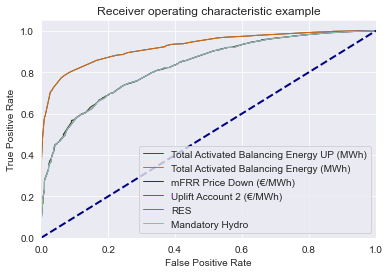

<Figure size 432x288 with 0 Axes>

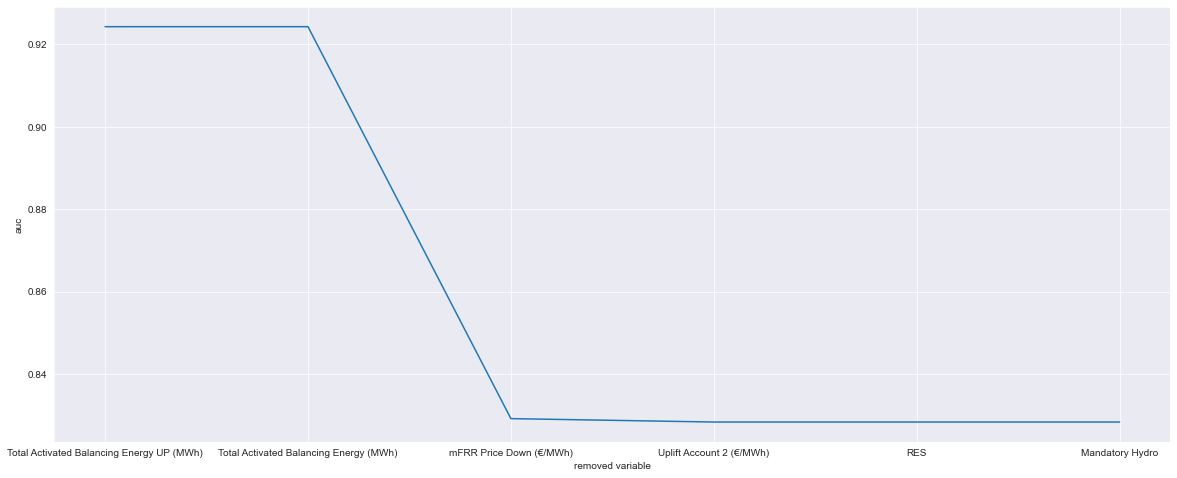

In [297]:


x = []
y = []


plt.figure()
count = 0
color_list = color
for k in cols:
    vars1 = cols.copy()
    cols.remove(k)
    print(vars1)
    GradientBoosting.fit(X_train_df[vars1].values,y_train.values.ravel())
    fpr, tpr, threshold = roc_curve(y_train, GradientBoosting.predict_proba(X_train_df[vars1])[:,1])
    roc_auc = auc(fpr, tpr)
    x.append(k)
    y.append(roc_auc)

    plt.plot(
    fpr,
    tpr,
    color=color_list[count],
    lw=1,
    label=k
    )
    count+=1

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

plot1 = plt.figure(1)
plt.figure(figsize=(20, 8))
plt.ylabel('auc')
plt.xlabel('removed variable')
plt.plot(x, y)
plt.show()

**mlxtend - Sequential Feature Selection**

In [191]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

best combination (ROC_AUC: 0.910): (0, 2, 3, 5, 7)

all subsets:
 {11: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10), 'cv_scores': array([0.91322768, 0.9072973 , 0.92029933, 0.90626698, 0.90091689]), 'avg_score': 0.9096016379575163, 'feature_names': ('Total Activated Balancing Energy UP (MWh)', 'Total Activated Balancing Energy Down (MWh)', 'Total Activated Balancing Energy (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro')}, 10: {'feature_idx': (0, 1, 2, 3, 5, 6, 7, 8, 9, 10), 'cv_scores': array([0.91375923, 0.90749532, 0.92110186, 0.90684697, 0.90166357]), 'avg_score': 0.9101733906622307, 'feature_names': ('Total Activated Balancing Energy UP (MWh)', 'Total Activated Balancing Energy Down (MWh)', 'Total Activated Balancing Energy (MWh)', 'mFRR Price UP (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'L

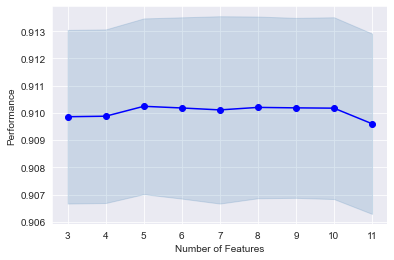

In [192]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

header_list = [
    'Total Activated Balancing Energy UP (MWh)',
    'Total Activated Balancing Energy Down (MWh)',
    'Total Activated Balancing Energy (MWh)',
    'mFRR Price UP (€/MWh)',
    'mFRR Price Down (€/MWh)',
    'Uplift Account 1 (€/MWh)',
    'Uplift Account 2 (€/MWh)',
    'Uplift Account 3 (€/MWh)',
    'RES',
    'Load',
    'Mandatory Hydro'
]

cols=header_list
X_train_df = pd.DataFrame(X_train, columns=cols)


sfs1 = SFS(estimator=lda_fit_train, 
           k_features=(3, 11),
           forward=False, 
           floating=False, 
           scoring='roc_auc',
           cv=5)


sfs1 = sfs1.fit(X_train, y_train, custom_feature_names=header_list)

print('best combination (ROC_AUC: %.3f): %s\n' % (sfs1.k_score_, sfs1.k_feature_idx_))
print('all subsets:\n', sfs1.subsets_)
plot_sfs(sfs1.get_metric_dict(), kind='std_err');

In [197]:
header_list = [
    'Total Activated Balancing Energy UP (MWh)',
    'Total Activated Balancing Energy Down (MWh)',
    'Total Activated Balancing Energy (MWh)',
    'mFRR Price UP (€/MWh)',
    'mFRR Price Down (€/MWh)',
    'Uplift Account 1 (€/MWh)',
    'Uplift Account 2 (€/MWh)',
    'Uplift Account 3 (€/MWh)',
    'RES',
    'Load',
    'Mandatory Hydro'
]


best combination (ROC_AUC: 0.915): (0, 1, 5, 7)

all subsets:
 {11: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10), 'cv_scores': array([0.89926417, 0.88853163, 0.89793791, 0.89150086, 0.89459888]), 'avg_score': 0.8943666915580014, 'feature_names': ('Total Activated Balancing Energy UP (MWh)', 'Total Activated Balancing Energy Down (MWh)', 'Total Activated Balancing Energy (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro')}, 10: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 9, 10), 'cv_scores': array([0.90012142, 0.8936673 , 0.90983777, 0.89286722, 0.89550481]), 'avg_score': 0.8983997068468931, 'feature_names': ('Total Activated Balancing Energy UP (MWh)', 'Total Activated Balancing Energy Down (MWh)', 'Total Activated Balancing Energy (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Accou

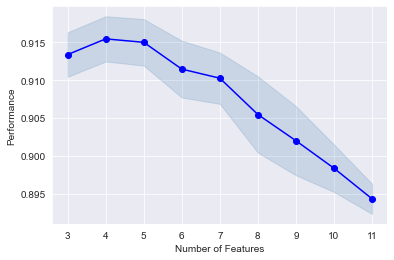

In [198]:
sfs2 = SFS(estimator=clf3, 
           k_features=(3, 11),
           forward=False, 
           floating=False, 
           scoring='roc_auc',
           cv=5)


sfs2 = sfs2.fit(X_train, y_train, custom_feature_names=header_list)

print('best combination (ROC_AUC: %.3f): %s\n' % (sfs2.k_score_, sfs2.k_feature_idx_))
print('all subsets:\n', sfs2.subsets_)
plot_sfs(sfs2.get_metric_dict(), kind='std_err');

best combination (ROC_AUC: 0.911): (1, 2, 3, 6, 7, 9, 10)

all subsets:
 {11: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10), 'cv_scores': array([0.91885322, 0.90469689, 0.92118003, 0.89765863, 0.90890056]), 'avg_score': 0.9102578663697912, 'feature_names': ('Total Activated Balancing Energy UP (MWh)', 'Total Activated Balancing Energy Down (MWh)', 'Total Activated Balancing Energy (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro')}, 10: {'feature_idx': (0, 1, 2, 3, 4, 6, 7, 8, 9, 10), 'cv_scores': array([0.91866561, 0.90448062, 0.92060419, 0.90019542, 0.90890056]), 'avg_score': 0.9105692807761578, 'feature_names': ('Total Activated Balancing Energy UP (MWh)', 'Total Activated Balancing Energy Down (MWh)', 'Total Activated Balancing Energy (MWh)', 'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)', 'Uplift Account 2 (€/MWh)', 'Uplift Account 3 (€/MWh)', 'RE

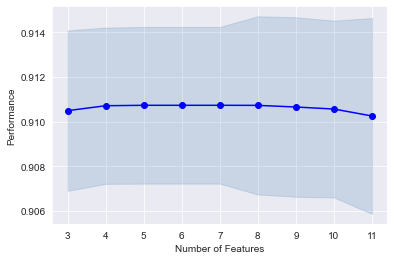

In [196]:
header_list = [
    'Total Activated Balancing Energy UP (MWh)',
    'Total Activated Balancing Energy Down (MWh)',
    'Total Activated Balancing Energy (MWh)',
    'mFRR Price UP (€/MWh)',
    'mFRR Price Down (€/MWh)',
    'Uplift Account 1 (€/MWh)',
    'Uplift Account 2 (€/MWh)',
    'Uplift Account 3 (€/MWh)',
    'RES',
    'Load',
    'Mandatory Hydro'
]

sfs3 = SFS(estimator=gradient_fit, 
           k_features=(3, 11),
           forward=False, 
           floating=False, 
           scoring='roc_auc',
           cv=5)


sfs3 = sfs3.fit(X_train, y_train, custom_feature_names=header_list)

print('best combination (ROC_AUC: %.3f): %s\n' % (sfs3.k_score_, sfs3.k_feature_idx_))
print('all subsets:\n', sfs3.subsets_)
plot_sfs(sfs3.get_metric_dict(), kind='std_err');

$\textbf{Classification Analysis with features that have been published before the clearing of the Day Ahead Market}$

In [160]:
Uplift_accounts = [features[6],features[7],features[8]]

x = combined_dataframes.drop([features[0],features[1],features[2],features[3],features[4],features[5],features[6],features[7],features[8],features[13],features[14],features[15],"Date"], axis=1)
x.head()



RES    Load  Mandatory Hydro  Total FRR
2021-08-15 00:00:00  1820.0  5515.5             50.0      914.0
2021-08-15 01:00:00  1930.0  5299.0             50.0      939.0
2021-08-15 02:00:00  2000.0  5127.5             50.0      949.0
2021-08-15 03:00:00  2035.0  5038.0             63.0      939.0
2021-08-15 04:00:00  2055.0  4951.5             76.0     1079.0

In [161]:
y = combined_dataframes['Diff_direction']
y.value_counts()

1    3408
0    2496
Name: Diff_direction, dtype: int64

In [88]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,y_test = train_test_split(x,y, test_size=0.25)

In [89]:
X_train.head()

RES    Load  Mandatory Hydro  Total FRR
2021-10-24 08:00:00  1825.0  5027.0            191.5     1764.0
2022-01-16 09:00:00  2605.0  7052.5           1101.0     1461.0
2021-10-02 10:00:00  4230.0  6018.0             52.0     1474.0
2022-03-27 09:00:00  2595.0  5104.5             31.0     1306.0
2022-01-25 08:00:00  3415.0  8711.0            599.0     1596.0

In [90]:
X_test.head()

RES    Load  Mandatory Hydro  Total FRR
2021-10-23 16:00:00   680.0  5447.0            270.0     1784.0
2022-04-04 14:00:00  1930.0  5486.0             13.0     1536.0
2021-11-27 08:00:00  3150.0  5910.0             82.0     1354.0
2021-09-24 22:00:00   520.0  4813.0             53.0     1604.0
2021-08-30 05:00:00   740.0  5361.5            135.0     1489.0

$\textbf{Logistic Regression}$

In [91]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        print("_______________________________________________")
        print(f"ROV CURVE SCORE \n {roc_auc_score(y_train,pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")      
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")
        print("_______________________________________________")
        print(f"ROC CURVE SCORE :\n {roc_auc_score(y_test,pred)}\n")

In [92]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

# cat_columns = []
num_columns = X_train.columns

ct = make_column_transformer(
    (MinMaxScaler(), num_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [93]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)

print_score(lr_clf, X_train, y_train, X_test, y_test, train=True)
print_score(lr_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 58.13%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.514039     0.589155  0.581301     0.551597      0.557483
recall        0.127477     0.912144  0.581301     0.519810      0.581301
f1-score      0.204292     0.715906  0.581301     0.460099      0.500191
support    1867.000000  2561.000000  0.581301  4428.000000   4428.000000
_______________________________________________
Confusion Matrix: 
 [[ 238 1629]
 [ 225 2336]]

_______________________________________________
ROV CURVE SCORE 
 0.5198104650387011

Test Result:
Accuracy Score: 57.99%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.530612    0.585403  0.579946     0.558007      0.562054
recall       0.124006    0.918536  0.579946     0.521271      0.579946
f1-score     0.201031    

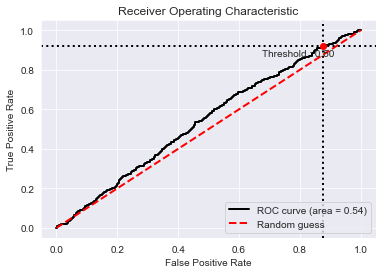

In [94]:
from plot_metric.functions import BinaryClassification
logistic_prob = lr_clf.predict_proba(X=X_test)[:,1]
bc = BinaryClassification(y_test, logistic_prob, labels=["Class 1", "Class 1"])

bc.plot_roc_curve()
plt.show()

$\textbf{Neural Networks Classifier}$

In [515]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

clf1 = MLPClassifier(
    hidden_layer_sizes=(3),
    activation="relu",
    verbose=True,
    max_iter=1000
)
clf2 = MLPClassifier(
    hidden_layer_sizes=(10),
    activation="logistic",
    verbose=False,
    max_iter=10000
)

clf3 = MLPClassifier(
    hidden_layer_sizes=(50,25),
    activation="tanh",
    verbose=False,
    max_iter=10000
)

In [516]:
# Fitting MinMax Scaler to features
clf1.fit(X_train, y_train.values.ravel())
clf2.fit(X_train, y_train.values.ravel())
clf3.fit(X_train, y_train.values.ravel())

# ROC Curve
fpr1, tpr1, threshold1 = roc_curve(y_test.values, clf1.predict_proba(X_test)[:,1])
fpr2, tpr2, threshold2 = roc_curve(y_test.values, clf2.predict_proba(X_test)[:,1])
fpr3, tpr3, threshold3 = roc_curve(y_test.values, clf3.predict_proba(X_test)[:,1])

Iteration 1, loss = 0.76386765
Iteration 2, loss = 0.73954931
Iteration 3, loss = 0.72156230
Iteration 4, loss = 0.70882588
Iteration 5, loss = 0.70012341
Iteration 6, loss = 0.69418083
Iteration 7, loss = 0.68992666
Iteration 8, loss = 0.68712092
Iteration 9, loss = 0.68501494
Iteration 10, loss = 0.68326922
Iteration 11, loss = 0.68180760
Iteration 12, loss = 0.68078566
Iteration 13, loss = 0.67982500
Iteration 14, loss = 0.67907058
Iteration 15, loss = 0.67845486
Iteration 16, loss = 0.67792561
Iteration 17, loss = 0.67747478
Iteration 18, loss = 0.67704554
Iteration 19, loss = 0.67677481
Iteration 20, loss = 0.67648056
Iteration 21, loss = 0.67620268
Iteration 22, loss = 0.67587968
Iteration 23, loss = 0.67560482
Iteration 24, loss = 0.67546785
Iteration 25, loss = 0.67530488
Iteration 26, loss = 0.67504230
Iteration 27, loss = 0.67483975
Iteration 28, loss = 0.67474504
Iteration 29, loss = 0.67452015
Iteration 30, loss = 0.67432529
Iteration 31, loss = 0.67418796
Iteration 32, los

0.5871725383920506
0.5718157181571816
0.583107497741644
0.5657181571815718
0.6648599819331527
0.5840108401084011


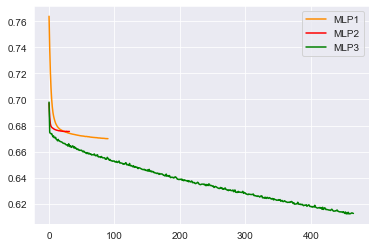

In [517]:
print(clf1.score(X_train, y_train.values.ravel()))
print(clf1.score(X_test, y_test.values.ravel()))
print(clf2.score(X_train, y_train.values.ravel()))
print(clf2.score(X_test, y_test.values.ravel()))
print(clf3.score(X_train, y_train.values.ravel()))
print(clf3.score(X_test, y_test.values.ravel()))


roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)

plt.plot(clf1.loss_curve_,color="darkorange",label="MLP1")
plt.plot(clf2.loss_curve_,color="red",label="MLP2")
plt.plot(clf3.loss_curve_,color="green",label="MLP3")

#pyplot.plot(clf4.loss_curve_,color="purple" , label = "MLP4")
plt.legend(loc="upper right")
plt.show()

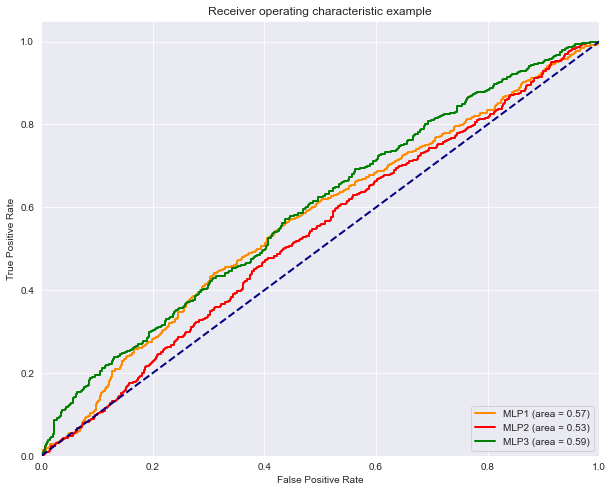

In [518]:
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(
    fpr1,
    tpr1,
    color="darkorange",
    lw=lw,
    label="MLP1 (area = %0.2f)" % roc_auc1,
)
plt.plot(
    fpr2,
    tpr2,
    color="red",
    lw=lw,
    label="MLP2 (area = %0.2f)" % roc_auc2,
)
plt.plot(
    fpr3,
    tpr3,
    color="green",
    lw=lw,
    label="MLP3 (area = %0.2f)" % roc_auc3,
)

# We want bigger AUC to justify which clasifier outpermorms

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [519]:

print_score(clf3, X_train, y_train, X_test, y_test, train=True)
print_score(clf3, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 66.49%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.647656     0.671855   0.66486     0.659756      0.661679
recall        0.445220     0.824240   0.66486     0.634730      0.664860
f1-score      0.527689     0.740287   0.66486     0.633988      0.650888
support    1862.000000  2566.000000   0.66486  4428.000000   4428.000000
_______________________________________________
Confusion Matrix: 
 [[ 829 1033]
 [ 451 2115]]

_______________________________________________
ROV CURVE SCORE 
 0.6347301278471762

Test Result:
Accuracy Score: 58.40%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.525381    0.605360  0.584011     0.565371      0.571006
recall       0.326498    0.777910  0.584011     0.552204      0.584011
f1-score     0.402724    

In [520]:
GradientBoosting = GradientBoostingClassifier( min_samples_leaf = 70, min_samples_split = 1000,learning_rate= 0.01 , n_estimators =60 , max_depth = 3)
gradient_fit = GradientBoosting.fit(X_train, y_train)

C:\Users\USER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


   CrossVal_Score_Means  CrossValerrors                    Algo
0              0.603878        0.010885  RandomForestClassifier
1              0.610879        0.015213      AdaBoostClassifier
2              0.615401        0.018509       Gradient Boosting
3              0.552165        0.016522  DecisionTreeClassifier


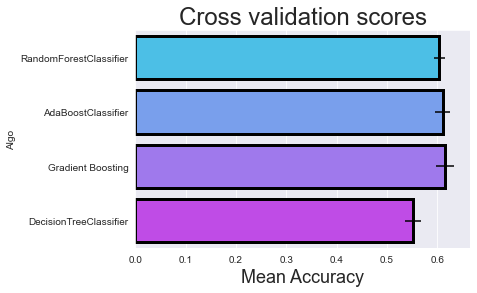

<Figure size 1080x504 with 0 Axes>

In [521]:
kfold = StratifiedKFold(n_splits=8,shuffle=True, random_state=42)

rs = 15
clrs = []

clrs.append(AdaBoostClassifier(random_state=rs))
clrs.append(GradientBoostingClassifier(random_state=rs))
clrs.append(RandomForestClassifier(random_state=rs))
clrs.append(DecisionTreeClassifier(random_state = rs))

cv_results = []
for clr in clrs :
    cv_results.append(cross_val_score(clr, X_train, y_train , scoring = 'accuracy', cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_df = pd.DataFrame({"CrossVal_Score_Means":cv_means,"CrossValerrors": cv_std,"Algo":["RandomForestClassifier","AdaBoostClassifier","Gradient Boosting",'DecisionTreeClassifier']})
g = sns.barplot("CrossVal_Score_Means","Algo",data = cv_df,orient = "h",**{'xerr':cv_std},palette='cool',edgecolor="black",linewidth=3)
g.set_xlabel("Mean Accuracy",fontsize = 18)
g = g.set_title("Cross validation scores",fontsize = 24)
plt.figure(figsize = (15,7))
print(cv_df)

In [522]:
from sklearn.linear_model import LogisticRegression

print_score(gradient_fit, X_train, y_train, X_test, y_test, train=True)
print_score(gradient_fit, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 58.36%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.725000     0.582270  0.583559     0.653635      0.642289
recall        0.015575     0.995713  0.583559     0.505644      0.583559
f1-score      0.030494     0.734829  0.583559     0.382662      0.438652
support    1862.000000  2566.000000  0.583559  4428.000000   4428.000000
_______________________________________________
Confusion Matrix: 
 [[  29 1833]
 [  11 2555]]

_______________________________________________
ROV CURVE SCORE 
 0.505643911582765

Test Result:
Accuracy Score: 57.66%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.846154    0.574163  0.576558     0.710158      0.690994
recall       0.017350    0.997625  0.576558     0.507487      0.576558
f1-score     0.034003    0

$\textbf{We are going to add for each step the exogenous features}$

* Uplift Account 1
* Uplift Account 2
* Uplift Account 3

In [162]:
Uplift_accounts = [features[6],features[7],features[8]]

x = combined_dataframes.drop([features[0],features[1],features[2],features[3],features[4],features[5],features[7],features[8],features[13],features[14],features[15],"Date"], axis=1)
x.tail()

y = combined_dataframes['Diff_direction']
y.value_counts()

1    3408
0    2496
Name: Diff_direction, dtype: int64

In [163]:
from holidays import Greece
greek_holidays = Greece()
# Have a look at all the holidays
[greek_holidays[date] for date in greek_holidays[datetime.date(2021,8,15):datetime.date(2022,4,17)]]
def get_holiday(date):
  try:
    day_type = greek_holidays[date]
  except KeyError:
    day_type = 'None'
  return day_type

x['Holidays'] = x.index.map(lambda x: get_holiday(x))

x.head()
holidays=[greek_holidays[date] for date in greek_holidays[datetime.date(2021,8,15):datetime.date(2022,4,17)]]


x.loc[x['Holidays'] =='None','Holidays'] = 0
x.loc[x["Holidays"].isin(holidays),'Holidays'] = 1
x.head()

x["Date"] = pd.to_datetime(x.index)
x["IsWeekend"] = x["Date"].dt.weekday >= 5

x.replace({False: 0, True: 1}, inplace=True)

x = x.drop("Date",axis=1)
# display the dataframe


x.head()

Uplift Account 1 (€/MWh)     RES    Load  \
2021-08-15 00:00:00                  2.738548  1820.0  5515.5   
2021-08-15 01:00:00                  2.375837  1930.0  5299.0   
2021-08-15 02:00:00                  2.143069  2000.0  5127.5   
2021-08-15 03:00:00                  2.043232  2035.0  5038.0   
2021-08-15 04:00:00                  2.227400  2055.0  4951.5   

                     Mandatory Hydro  Total FRR  Holidays  IsWeekend  
2021-08-15 00:00:00             50.0      914.0         1          1  
2021-08-15 01:00:00             50.0      939.0         1          1  
2021-08-15 02:00:00             50.0      949.0         1          1  
2021-08-15 03:00:00             63.0      939.0         1          1  
2021-08-15 04:00:00             76.0     1079.0         1          1

In [166]:
###### Add Total Imports Total Exports 
all_data = pd.read_csv('All_data.csv')

scada_data  = pd.read_csv('scada.csv')

scada_data.head(50)
columns_data_scada =  scada_data.columns
scada_data[columns_data_scada[0]] = pd.to_datetime(scada_data[columns_data_scada[0]])
scada_data.set_index(columns_data_scada[0], drop=True, inplace=True)
scada_data.index.name = None

scada_data.head()
total_imports = scada_data["TOTAL IMPORTS"]
total_exports = scada_data["TOTAL EXPORTS"]

scada_data.tail()

#scada_data = scada_data.loc[scada_data.index <= datetime.datetime(2022,4,17)]
scada_data.tail()


total_imports = scada_data["TOTAL IMPORTS"]
total_exports = scada_data["TOTAL EXPORTS"]


x["total_imports"] = total_imports
x["total_exports"] = total_exports



0 nan rows
nan values are:
Empty DataFrame
Columns: [Uplift Account 1 (€/MWh), RES, Load, Mandatory Hydro, Total FRR, Holidays, IsWeekend, total_imports, total_exports]
Index: []


Empty DataFrame
Columns: [Uplift Account 1 (€/MWh), RES, Load, Mandatory Hydro, Total FRR, Holidays, IsWeekend, total_imports, total_exports]
Index: []

In [167]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,y_test = train_test_split(x,y, test_size=0.25)

In [168]:
X_train.head()
X_test.head()

Uplift Account 1 (€/MWh)     RES    Load  \
2021-12-27 00:00:00                  3.844767  2365.0  4488.5   
2021-09-24 11:00:00                  3.261485  2825.0  6248.0   
2022-03-21 10:00:00                  5.309493  4825.0  7552.0   
2021-09-27 23:00:00                  5.705856   535.0  4696.5   
2022-03-14 00:00:00                  8.660333   405.0  5230.0   

                     Mandatory Hydro  Total FRR  Holidays  IsWeekend  \
2021-12-27 00:00:00            112.0      969.0         0          0   
2021-09-24 11:00:00             68.0     1529.0         0          0   
2022-03-21 10:00:00             27.0     1596.0         0          0   
2021-09-27 23:00:00              0.0      457.0         0          0   
2022-03-14 00:00:00              0.0      876.0         0          0   

                     total_imports  total_exports  
2021-12-27 00:00:00          746.0          633.0  
2021-09-24 11:00:00          824.0          894.0  
2022-03-21 10:00:00          412.0          590.0  
2021-09-27 23:00:00         1083.0          351.0  
2022-03-14 00:00:00          573.0          569.0

In [169]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

# cat_columns = []
num_columns = ["Uplift Account 1 (€/MWh)","RES","Load","Mandatory Hydro","Total FRR","total_imports","total_exports"]

ct = make_column_transformer(
    (MinMaxScaler(), num_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

$\textbf{Neural Network}$

In [172]:
####### I am going to use only the Neural Classifier with tanh activation function


clf3.fit(X_train, y_train.values.ravel())

fpr3, tpr3, threshold3 = roc_curve(y_test.values, clf3.predict_proba(X_test)[:,1])

0.8884372177055104
0.6869918699186992


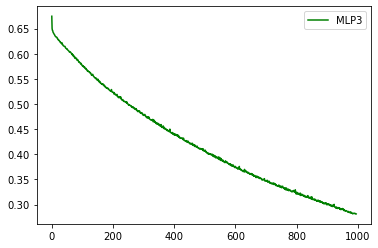

In [173]:
print(clf3.score(X_train, y_train.values.ravel()))
print(clf3.score(X_test, y_test.values.ravel()))


roc_auc3 = auc(fpr3, tpr3)


plt.plot(clf3.loss_curve_,color="green",label="MLP3")

#pyplot.plot(clf4.loss_curve_,color="purple" , label = "MLP4")
plt.legend(loc="upper right")
plt.show()

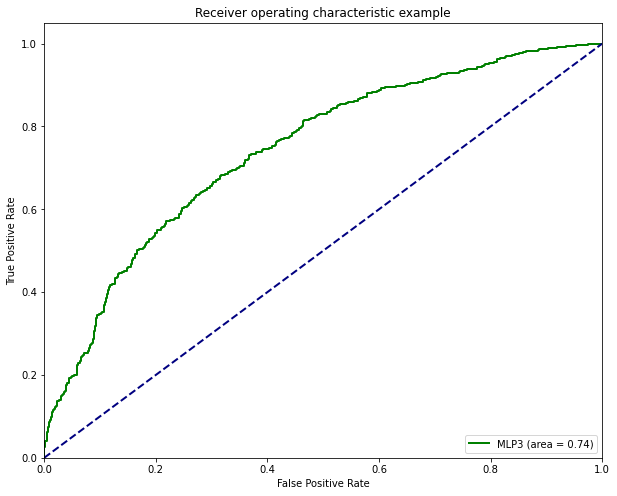

In [175]:
plt.figure(figsize=(10, 8))
lw = 2

plt.plot(
    fpr3,
    tpr3,
    color="green",
    lw=lw,
    label="MLP3 (area = %0.2f)" % roc_auc3,
)

# We want bigger AUC to justify which clasifier outpermorms

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

$\textbf{Gradient Boosting}$

C:\Users\USER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


   CrossVal_Score_Means  CrossValerrors                    Algo
0              0.626464        0.020296  RandomForestClassifier
1              0.653572        0.020847      AdaBoostClassifier
2              0.696700        0.025069       Gradient Boosting
3              0.606827        0.026861  DecisionTreeClassifier


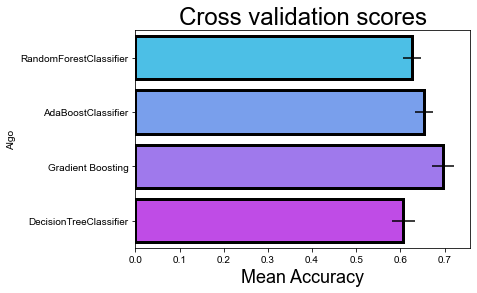

<Figure size 1080x504 with 0 Axes>

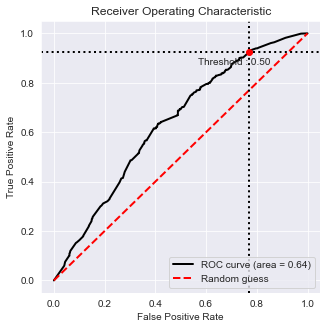

NameError: name 'print_score' is not defined

In [177]:
from sklearn.tree import DecisionTreeClassifier
from plot_metric.functions import BinaryClassification
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve ,KFold

GradientBoosting = GradientBoostingClassifier( min_samples_leaf = 70, min_samples_split = 1000,learning_rate= 0.01 , n_estimators =60 , max_depth = 3)
gradient_fit = GradientBoosting.fit(X_train, y_train)

kfold = StratifiedKFold(n_splits=8,shuffle=True, random_state=42)

rs = 15
clrs = []

clrs.append(AdaBoostClassifier(random_state=rs))
clrs.append(GradientBoostingClassifier(random_state=rs))
clrs.append(RandomForestClassifier(random_state=rs))
clrs.append(DecisionTreeClassifier(random_state = rs))

cv_results = []
for clr in clrs :
    cv_results.append(cross_val_score(clr, X_train, y_train , scoring = 'accuracy', cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_df = pd.DataFrame({"CrossVal_Score_Means":cv_means,"CrossValerrors": cv_std,"Algo":["RandomForestClassifier","AdaBoostClassifier","Gradient Boosting",'DecisionTreeClassifier']})
g = sns.barplot("CrossVal_Score_Means","Algo",data = cv_df,orient = "h",**{'xerr':cv_std},palette='cool',edgecolor="black",linewidth=3)
g.set_xlabel("Mean Accuracy",fontsize = 18)
g = g.set_title("Cross validation scores",fontsize = 24)
plt.figure(figsize = (15,7))
print(cv_df)

gradient_boost_roc = gradient_fit.predict_proba(X=X_test)
bc = BinaryClassification(y_test, gradient_boost_roc[:,1], labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

from sklearn.linear_model import LogisticRegression


In [179]:

print_score(gradient_fit, X_train, y_train, X_test, y_test, train=True)
print_score(gradient_fit, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 61.92%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.657709     0.611932  0.619241     0.634820      0.631667
recall        0.243583     0.903930  0.619241     0.573757      0.619241
f1-score      0.355505     0.729808  0.619241     0.542656      0.568438
support    1909.000000  2519.000000  0.619241  4428.000000   4428.000000
_______________________________________________
Confusion Matrix: 
 [[ 465 1444]
 [ 242 2277]]

_______________________________________________
ROV CURVE SCORE 
 0.5737565793837968

Test Result:
Accuracy Score: 64.77%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.665025    0.644933  0.647696     0.654979      0.652924
recall       0.229983    0.923510  0.647696     0.576746      0.647696
f1-score     0.341772    

$\textbf{Lets Try the classification to some data between 2022/04/26 and 2022/04/30}$

In [153]:
test_dataset = pd.read_csv('./Test/Test_dataset_classification.csv')

test_dataset.head()

test_dataset['Unnamed: 0'] = pd.to_datetime(test_dataset['Unnamed: 0'])
test_dataset.set_index('Unnamed: 0', drop=True, inplace=True)
test_dataset.index.name = None

In [154]:
test_dataset = test_dataset.drop("Date",axis=1)
Day_ahead_Balancing_diff = test_dataset["Day_ahead_Balancing_diff"]

In [155]:
test_dataset = test_dataset.drop("Day_ahead_Balancing_diff",axis=1)

In [156]:
test_dataset.head()

Uplift Account 1 (€/MWh)    RES    Load  Mandatory Hydro  \
2022-04-26 00:00:00                  9.139706  960.0  4196.0              0.0   
2022-04-26 01:00:00                  8.887252  910.0  4081.0              0.0   
2022-04-26 02:00:00                  8.544882  875.0  3999.5              0.0   
2022-04-26 03:00:00                  8.319490  840.0  4007.5             13.0   
2022-04-26 04:00:00                  8.380914  780.0  4083.5             86.0   

                     Total FRR  Diff_direction  
2022-04-26 00:00:00      841.0               1  
2022-04-26 01:00:00      846.0               1  
2022-04-26 02:00:00      846.0               1  
2022-04-26 03:00:00      861.0               1  
2022-04-26 04:00:00     1031.0               1

In [157]:
X_validation =test_dataset.drop("Diff_direction",axis=1)
#X_validation = X_validation.drop("Uplift Account 1 (€/MWh)",axis=1)

In [158]:
###### Add Holidays and week days

from holidays import Greece
greek_holidays = Greece()
# Have a look at all the holidays
[greek_holidays[date] for date in greek_holidays[datetime.date(2022,4,26):datetime.date(2022,4,30)]]
def get_holiday(date):
  try:
    day_type = greek_holidays[date]
  except KeyError:
    day_type = 'None'
  return day_type

X_validation['Holidays'] = X_validation.index.map(lambda x: get_holiday(x))

X_validation.head()
holidays=[greek_holidays[date] for date in greek_holidays[datetime.date(2022,4,26):datetime.date(2022,4,30)]]


X_validation.loc[X_validation['Holidays'] =='None','Holidays'] = 0
X_validation.loc[X_validation["Holidays"].isin(holidays),'Holidays'] = 1
X_validation.head()

X_validation["Date"] = pd.to_datetime(X_validation.index)
X_validation["IsWeekend"] = X_validation["Date"].dt.weekday >= 5

X_validation.replace({False: 0, True: 1}, inplace=True)

X_validation = X_validation.drop("Date",axis=1)
# display the dataframe




In [159]:
X_validation

Uplift Account 1 (€/MWh)     RES    Load  \
2022-04-26 00:00:00                  9.139706   960.0  4196.0   
2022-04-26 01:00:00                  8.887252   910.0  4081.0   
2022-04-26 02:00:00                  8.544882   875.0  3999.5   
2022-04-26 03:00:00                  8.319490   840.0  4007.5   
2022-04-26 04:00:00                  8.380914   780.0  4083.5   
2022-04-26 05:00:00                  8.498725   815.0  4414.0   
2022-04-26 06:00:00                  8.103607  1255.0  4928.0   
2022-04-26 07:00:00                  7.818591  2035.0  5380.0   
2022-04-26 08:00:00                  6.973623  2795.0  5645.5   
2022-04-26 09:00:00                  6.590259  3360.0  5781.0   
2022-04-26 10:00:00                  6.376805  3755.0  5881.0   
2022-04-26 11:00:00                  5.526633  3935.0  5929.5   
2022-04-26 12:00:00                  4.991943  3965.0  5869.5   
2022-04-26 13:00:00                  7.444045  3875.0  5635.5   
2022-04-26 14:00:00                  6.996030  3530.0  5277.5   
2022-04-26 15:00:00                  6.003663  2930.0  5087.0   
2022-04-26 16:00:00                  6.388556  2150.0  5022.5   
2022-04-26 17:00:00                  6.138139  1335.0  5073.0   
2022-04-26 18:00:00                  6.401778   820.0  5296.0   
2022-04-26 19:00:00                  8.320033   705.0  5548.0   
2022-04-26 20:00:00                  8.874262   615.0  5379.5   
2022-04-26 21:00:00                  7.978710   600.0  4910.5   
2022-04-26 22:00:00                  7.335541   600.0  4430.0   
2022-04-26 23:00:00                  6.914817   595.0  3999.5   
2022-04-27 00:00:00                  6.487040   620.0  3802.0   
2022-04-27 01:00:00                  7.601776   615.0  3725.0   
2022-04-27 02:00:00                  7.595296   620.0  3675.0   
2022-04-27 03:00:00                  8.033921   645.0  3699.5   
2022-04-27 04:00:00                  8.097858   665.0  3841.5   
2022-04-27 05:00:00                  8.041526   745.0  4241.5   
2022-04-27 06:00:00                  7.200336  1220.0  4806.0   
2022-04-27 07:00:00                  8.001824  1985.0  5325.5   
2022-04-27 08:00:00                  6.679069  2725.0  5721.0   
2022-04-27 09:00:00                  5.842390  3300.0  5920.0   
2022-04-27 10:00:00                  4.340053  3680.0  6048.5   
2022-04-27 11:00:00                  3.924639  3880.0  6115.5   
2022-04-27 12:00:00                  2.733254  3915.0  5965.5   
2022-04-27 13:00:00                  4.983062  3750.0  5694.0   
2022-04-27 14:00:00                  4.107158  3375.0  5365.0   
2022-04-27 15:00:00                  5.512656  2755.0  5148.0   
2022-04-27 16:00:00                  6.367805  1960.0  5024.0   
2022-04-27 17:00:00                  6.244192  1170.0  4996.5   
2022-04-27 18:00:00                  7.286009   680.0  5219.5   
2022-04-27 19:00:00                  8.091246   580.0  5497.5   
2022-04-27 20:00:00                  8.016801   550.0  5320.0   
2022-04-27 21:00:00                  7.343671   550.0  4827.0   
2022-04-27 22:00:00                  6.605346   555.0  4357.5   
2022-04-27 23:00:00                  6.830292   590.0  4019.0   
2022-04-28 00:00:00                  7.089702   650.0  3928.0   
2022-04-28 01:00:00                  9.688237   690.0  3838.0   
2022-04-28 02:00:00                 10.666071   740.0  3804.5   
2022-04-28 03:00:00                  9.129918   795.0  3828.0   
2022-04-28 04:00:00                  9.346982   845.0  3972.0   
2022-04-28 05:00:00                  9.800654   965.0  4354.5   
2022-04-28 06:00:00                  8.985468  1510.0  4900.5   
2022-04-28 07:00:00                  7.713366  2320.0  5384.5   
2022-04-28 08:00:00                  6.096168  3120.0  5741.0   
2022-04-28 09:00:00                  4.733696  3760.0  5933.0   
2022-04-28 10:00:00                  4.519509  4195.0  6070.5   
2022-04-28 11:00:00                  4.438536  4430.0  6119.5   
2022-04-28 12:00:00                  3.187139  4445.0  5

In [160]:
y_validation = test_dataset["Diff_direction"]

In [161]:
num_columns =  ["Uplift Account 1 (€/MWh)","RES","Load","Mandatory Hydro","Total FRR"]

ct = make_column_transformer(
    (MinMaxScaler(), num_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

X_validation_sc = ct.fit_transform(X_validation)

In [162]:
###### Neural Network evaluation with tanh activation Function
print_score(clf3, X_train, y_train, X_validation_sc, y_validation, train=False)
##### Gradient Boosting 
print_score(gradient_fit,X_train,y_train,X_validation_sc,y_validation,train = False)

Test Result:
Accuracy Score: 50.00%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy   macro avg  weighted avg
precision   0.586957   0.445946       0.5    0.516451      0.525852
recall      0.397059   0.634615       0.5    0.515837      0.500000
f1-score    0.473684   0.523810       0.5    0.498747      0.495405
support    68.000000  52.000000       0.5  120.000000    120.000000
_______________________________________________
Confusion Matrix: 
 [[27 41]
 [19 33]]

_______________________________________________
ROC CURVE SCORE :
 0.5158371040723981

Test Result:
Accuracy Score: 55.83%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy   macro avg  weighted avg
precision   0.674419   0.493506  0.558333    0.583963      0.596023
recall      0.426471   0.730769  0.558333    0.578620      0.558333
f1-score    0.522523   0.589147  0.558333    0.555835      0.551393

In [163]:
prediction_gradient_boosting = gradient_fit.predict(X_validation_sc)

In [168]:
test_dataset["Gradient_Boosting_Classification"] =  prediction_gradient_boosting
test_dataset['Neural_network_Classification'] = clf3.predict(X_validation_sc)
test_dataset["Holidays"] = X_validation["Holidays"]
test_dataset["IsWeekend"] = X_validation["IsWeekend"]
test_dataset["Day_ahead_Balancing_diff"] = Day_ahead_Balancing_diff
test_dataset["Date"] = test_dataset.index
test_dataset.to_csv('Data_classification.csv',index=True, encoding='utf-8')

0.8419150858175248
0.5


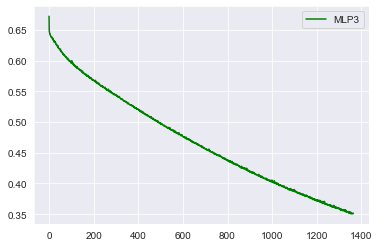

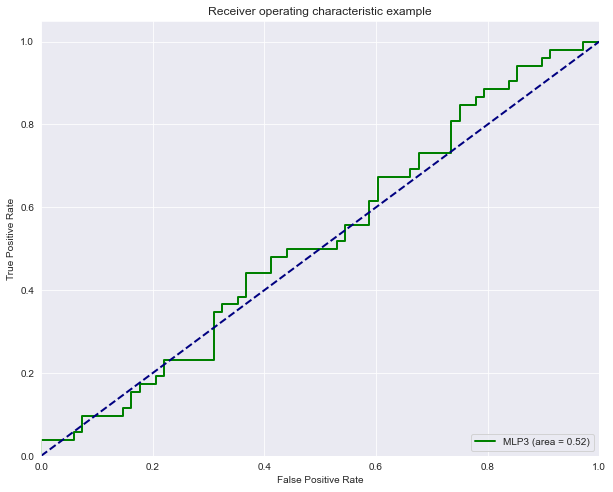

In [138]:
####### I am going to use only the Neural Classifier with tanh activation function



fpr3, tpr3, threshold3 = roc_curve(y_validation.values, clf3.predict_proba(X_validation_sc)[:,1])

print(clf3.score(X_train, y_train.values.ravel()))
print(clf3.score(X_validation_sc, y_validation.values.ravel()))


roc_auc3 = auc(fpr3, tpr3)


plt.plot(clf3.loss_curve_,color="green",label="MLP3")

#pyplot.plot(clf4.loss_curve_,color="purple" , label = "MLP4")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(10, 8))
lw = 2

plt.plot(
    fpr3,
    tpr3,
    color="green",
    lw=lw,
    label="MLP3 (area = %0.2f)" % roc_auc3,
)

# We want bigger AUC to justify which clasifier outpermorms

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

$\textbf{May Data Classification test}$

In [13]:
test_dataset_may = pd.read_csv('May_data_classification.csv')
test_dataset_may.head()

Unnamed: 0  Uplift Account 1 (€/MWh)     RES    Load  \
0  2022-05-01 00:00:00                  7.190630  1480.0  3741.0   
1  2022-05-01 01:00:00                  9.164002  1530.0  3621.5   
2  2022-05-01 02:00:00                  9.272240  1585.0  3546.5   
3  2022-05-01 03:00:00                  8.837913  1655.0  3516.0   
4  2022-05-01 04:00:00                  8.880369  1705.0  3491.0   

   Mandatory Hydro  Total FRR  Total_imports  Total_epxorts  \
0              0.0      896.0            0.0          321.0   
1              0.0      906.0            0.0          512.0   
2              0.0      906.0            0.0          510.0   
3             13.0      906.0            2.0          460.0   
4             81.0     1091.0            0.0          419.0   

   Day_ahead_Balancing_diff  Holidays  IsWeekend  
0                 60.985051         1          1  
1               -153.897500         1          1  
2               -202.380837         1          1  
3               -111.378457         1          1  
4               -119.081816         1          1

In [14]:
test_dataset_may['Unnamed: 0'] = pd.to_datetime(test_dataset_may['Unnamed: 0'])
test_dataset_may.set_index('Unnamed: 0', drop=True, inplace=True)
test_dataset_may.index.name = None

In [15]:
test_dataset_may["Diff_direction"] = [1 if int(x) >= 0 else 0 for x in test_dataset_may["Day_ahead_Balancing_diff"]]

In [16]:
test_dataset_may = test_dataset_may.drop("Day_ahead_Balancing_diff",axis=1)

In [17]:
X_validation_may = test_dataset_may.drop("Diff_direction",axis=1)
y_validation_may = test_dataset_may["Diff_direction"]

In [190]:
num_columns =  ["Uplift Account 1 (€/MWh)","RES","Load","Mandatory Hydro","Total FRR","Total_imports","Total_epxorts"]

ct = make_column_transformer(
    (MinMaxScaler(), num_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

X_validation_sc = ct.fit_transform(X_validation_may)

In [192]:
###### Neural Network evaluation with tanh activation Function
print_score(clf3, X_train, y_train, X_validation_sc, y_validation_may, train=False)
##### Gradient Boosting 
print_score(gradient_fit,X_train,y_train,X_validation_sc,y_validation_may,train = False)

Test Result:
Accuracy Score: 51.04%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.866667   0.282051  0.510417    0.574359      0.735737
recall       0.436242   0.767442  0.510417    0.601842      0.510417
f1-score     0.580357   0.412500  0.510417    0.496429      0.542764
support    149.000000  43.000000  0.510417  192.000000    192.000000
_______________________________________________
Confusion Matrix: 
 [[65 84]
 [10 33]]

_______________________________________________
ROC CURVE SCORE :
 0.6018417356016856

Test Result:
Accuracy Score: 40.62%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.857143   0.251748   0.40625    0.554446      0.721560
recall       0.281879   0.837209   0.40625    0.559544      0.406250
f1-score     0.424242   0.387097   0.40625    0.405670     

In [197]:
neural_network_data = clf3.predict(X_validation_sc)
gradient_boosting_pred = gradient_fit.predict(X_validation_sc)

In [194]:
neural_network_data

array([1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1], dtype=int64)

In [195]:
test_dataset_may["Prediction"] = neural_network_data

In [198]:
test_dataset_may["Prediction_gradient_boosting"] = gradient_boosting_pred

In [200]:
test_dataset_may.to_csv('Prediction_Classification.csv')

$\textbf{Multi Class Classification}$

Boxplot, IQR, qutliner for Total activated balancing energy up (mwh)


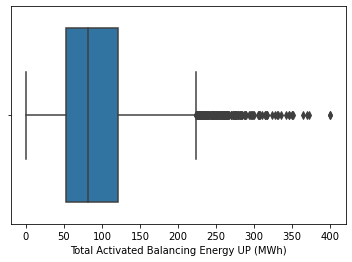

IQR For Total activated balancing energy up (mwh) Column :  68.00474374999999
There are 204 outliers out of 5904 data points.
There are many outliners in Total activated balancing energy up (mwh) columns
Boxplot, IQR, qutliner for Total activated balancing energy down (mwh)


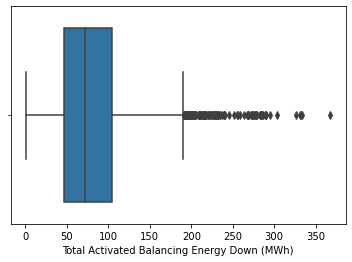

IQR For Total activated balancing energy down (mwh) Column :  57.50277062499999
There are 133 outliers out of 5904 data points.
There are many outliners in Total activated balancing energy down (mwh) columns
Boxplot, IQR, qutliner for Total activated balancing energy (mwh)


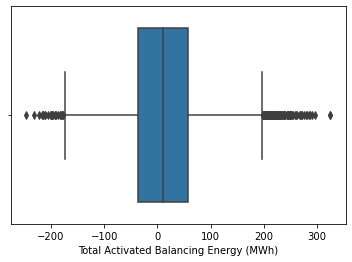

IQR For Total activated balancing energy (mwh) Column :  93.37087541666666
There are 139 outliers out of 5904 data points.
There are many outliners in Total activated balancing energy (mwh) columns
Boxplot, IQR, qutliner for Imbalance price  (€/mwh)


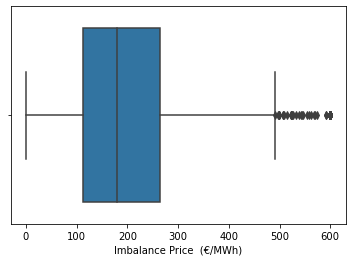

IQR For Imbalance price  (€/mwh) Column :  151.492796376875
There are 66 outliers out of 5904 data points.
There are many outliners in Imbalance price  (€/mwh) columns
Boxplot, IQR, qutliner for Mfrr price up (€/mwh)


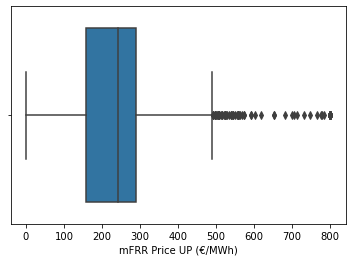

IQR For Mfrr price up (€/mwh) Column :  133.37062500000002
There are 81 outliers out of 5904 data points.
There are many outliners in Mfrr price up (€/mwh) columns
Boxplot, IQR, qutliner for Mfrr price down (€/mwh)


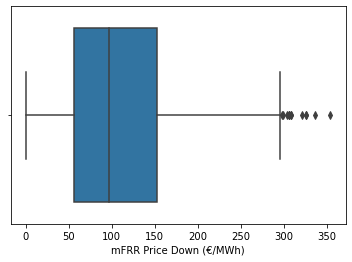

IQR For Mfrr price down (€/mwh) Column :  96.74124999999997
There are 13 outliers out of 5904 data points.
There are many outliners in Mfrr price down (€/mwh) columns
Boxplot, IQR, qutliner for Uplift account 1 (€/mwh)


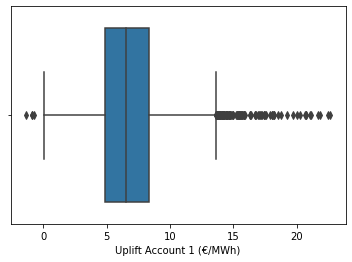

IQR For Uplift account 1 (€/mwh) Column :  3.505742676249998
There are 116 outliers out of 5904 data points.
There are many outliners in Uplift account 1 (€/mwh) columns
Boxplot, IQR, qutliner for Uplift account 2 (€/mwh)


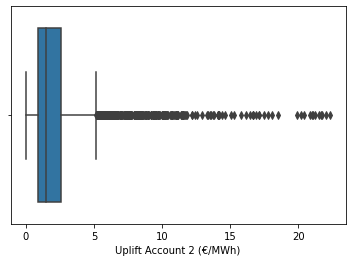

IQR For Uplift account 2 (€/mwh) Column :  1.7167358975
There are 395 outliers out of 5904 data points.
There are many outliners in Uplift account 2 (€/mwh) columns
Boxplot, IQR, qutliner for Uplift account 3 (€/mwh)


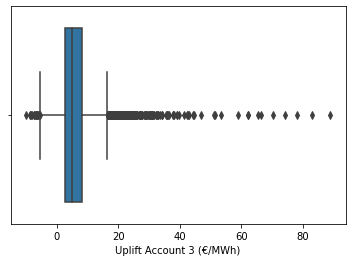

IQR For Uplift account 3 (€/mwh) Column :  5.504303299375
There are 325 outliers out of 5904 data points.
There are many outliners in Uplift account 3 (€/mwh) columns
Boxplot, IQR, qutliner for Res


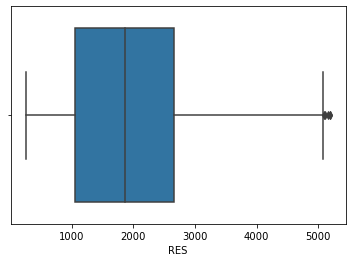

IQR For Res Column :  1610.0
There are 5 outliers out of 5904 data points.
There are many outliners in Res columns
Boxplot, IQR, qutliner for Load


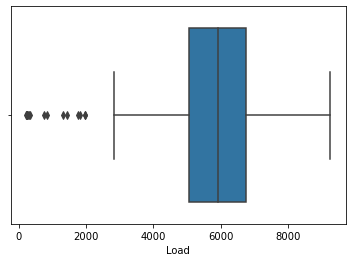

IQR For Load Column :  1709.75
There are 23 outliers out of 5904 data points.
There are many outliners in Load columns
Boxplot, IQR, qutliner for Mandatory hydro


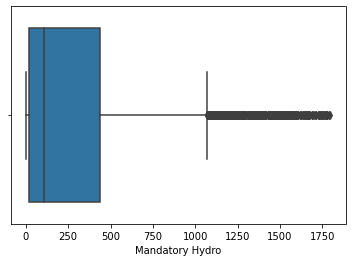

IQR For Mandatory hydro Column :  420.0
There are 598 outliers out of 5904 data points.
There are many outliners in Mandatory hydro columns
Boxplot, IQR, qutliner for Total frr


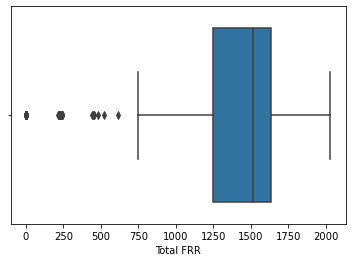

IQR For Total frr Column :  392.0
There are 168 outliers out of 5904 data points.
There are many outliners in Total frr columns
Boxplot, IQR, qutliner for Day_ahead_price


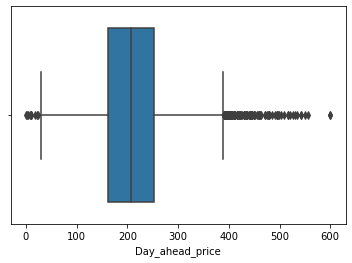

IQR For Day_ahead_price Column :  90.9325
There are 136 outliers out of 5904 data points.
There are many outliners in Day_ahead_price columns
Boxplot, IQR, qutliner for Day_ahead_balancing_diff


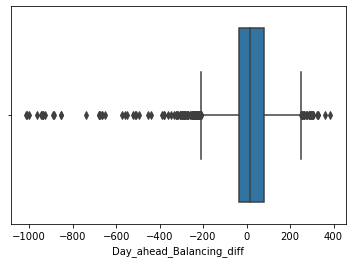

IQR For Day_ahead_balancing_diff Column :  114.85491436624999
There are 125 outliers out of 5904 data points.
There are many outliners in Day_ahead_balancing_diff columns
Boxplot, IQR, qutliner for Diff_direction


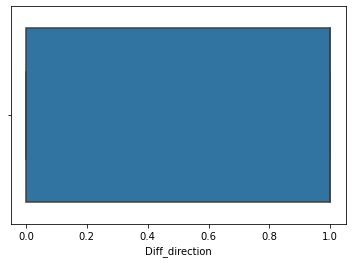

IQR For Diff_direction Column :  1.0
There are 0 outliers out of 5904 data points.


In [61]:
%matplotlib inline
from scipy import stats
n = combined_dataframes[features[0]].count()
new_df = combined_dataframes.copy()

for name in features: # this was "for name in names"
    print(f"Boxplot, IQR, qutliner for {name.capitalize()}")
    sns.boxplot(x=combined_dataframes[name])
    q1 = combined_dataframes[name].quantile(0.25)
    q3 = combined_dataframes[name].quantile(0.75)
    lower = q1 - 1.5 * stats.iqr(combined_dataframes[name],axis=0)
    upper = q3 + 1.5 * stats.iqr(combined_dataframes[name],axis=0)
    n_outliers = combined_dataframes[combined_dataframes[name] > upper][name].count() + combined_dataframes[combined_dataframes[name] < lower][name].count()
    plt.show()
    print(f"IQR For {name.capitalize()} Column : ",stats.iqr(combined_dataframes[name],axis=0))
    print(f"There are {n_outliers} outliers out of {n} data points.")
    if n_outliers != 0:
        p = n/n_outliers
        if p > 0.1:
            print(f"There are many outliners in {name.capitalize()} columns")
    
    new_df = new_df[new_df[name] < upper]
    new_df = new_df[new_df[name] > lower]

In [62]:
combined_dataframes[features[14]].loc[combined_dataframes[features[14]] <= -600 ] = -600

C:\Users\USER\anaconda3\lib\site-packages\pandas\core\indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [63]:
min(combined_dataframes[features[14]])

-600.0

In [64]:
combined_dataframes['Label'] = pd.cut(x=combined_dataframes[features[14]],
                     bins=[min(combined_dataframes[features[14]]),-20,65,max(combined_dataframes[features[14]])],
                     labels=['0','1','2'],include_lowest=True)

In [65]:
bin_labels = ['0', '1', '2']
combined_dataframes['Label_2'] = pd.qcut(combined_dataframes[features[14]],
                              q=3,
                              labels=bin_labels)

In [430]:
combined_dataframes.head()

Total Activated Balancing Energy UP (MWh)  \
2021-08-15 00:00:00                                  64.696300   
2021-08-15 01:00:00                                  47.823965   
2021-08-15 02:00:00                                  37.976322   
2021-08-15 03:00:00                                  36.129990   
2021-08-15 04:00:00                                  34.597000   

                     Total Activated Balancing Energy Down (MWh)  \
2021-08-15 00:00:00                                   162.704473   
2021-08-15 01:00:00                                   117.162650   
2021-08-15 02:00:00                                    56.592600   
2021-08-15 03:00:00                                   105.814593   
2021-08-15 04:00:00                                    90.711290   

                     Total Activated Balancing Energy (MWh)  \
2021-08-15 00:00:00                              -98.008173   
2021-08-15 01:00:00                              -69.338685   
2021-08-15 02:00:00                              -18.616278   
2021-08-15 03:00:00                              -69.684602   
2021-08-15 04:00:00                              -56.114290   

                     Imbalance Price  (€/MWh)  mFRR Price UP (€/MWh)  \
2021-08-15 00:00:00                 38.036567               141.3900   
2021-08-15 01:00:00                 23.803718                86.9275   
2021-08-15 02:00:00                 25.178707                27.8250   
2021-08-15 03:00:00                  0.010000                28.5925   
2021-08-15 04:00:00                 17.827500                28.5925   

                     mFRR Price Down (€/MWh)  Uplift Account 1 (€/MWh)  \
2021-08-15 00:00:00                  40.7625                  2.738548   
2021-08-15 01:00:00                  26.3325                  2.375837   
2021-08-15 02:00:00                   0.0100                  2.143069   
2021-08-15 03:00:00                   0.0100                  2.043232   
2021-08-15 04:00:00                  17.8275                  2.227400   

                     Uplift Account 2 (€/MWh)  Uplift Account 3 (€/MWh)  \
2021-08-15 00:00:00                  0.662670                  5.481142   
2021-08-15 01:00:00                  1.098814                  2.754350   
2021-08-15 02:00:00                  1.201918                  3.213499   
2021-08-15 03:00:00                  1.117085                  3.079745   
2021-08-15 04:00:00                  1.156230                  2.383576   

                        RES    Load  Mandatory Hydro  Total FRR  \
2021-08-15 00:00:00  1820.0  5515.5             50.0      914.0   
2021-08-15 01:00:00  1930.0  5299.0             50.0      939.0   
2021-08-15 02:00:00  2000.0  5127.5             50.0      949.0   
2021-08-15 03:00:00  2035.0  5038.0             63.0      939.0   
2021-08-15 04:00:00  2055.0  4951.5             76.0     1079.0   

                     Day_ahead_price  Day_ahead_Balancing_diff  \
2021-08-15 00:00:00            95.16                 57.123433   
2021-08-15 01:00:00           103.16                 79.356282   
2021-08-15 02:00:00            91.91                 66.731293   
2021-08-15 03:00:00            77.00                 76.990000   
2021-08-15 04:00:00            83.80                 65.972500   

                     Diff_direction                Date Label Label_2  
2021-08-15 00:00:00               1 2021-08-15 00:00:00     1       2  
2021-08-15 01:00:00               1 2021-08-15 01:00:00     2       2  
2021-08-15 02:00:00               1 2021-08-15 02:00:00     2       2  
2021-08-15 03:00:00               1 2021-08-15 03:00:00     2       2  
2021-08-15 04:00:00               1 2021-08-15 04:00:00     2       2

$\textbf{Split in:}$

* (-600.001, -19.653]
* (-19.653, 54.838]
*  (54.838, 385.131]

In [66]:
df_info(combined_dataframes)

type  \
Total Activated Balancing Energy UP (MWh)           float64   
Total Activated Balancing Energy Down (MWh)         float64   
Total Activated Balancing Energy (MWh)              float64   
Imbalance Price  (€/MWh)                            float64   
mFRR Price UP (€/MWh)                               float64   
mFRR Price Down (€/MWh)                             float64   
Uplift Account 1 (€/MWh)                            float64   
Uplift Account 2 (€/MWh)                            float64   
Uplift Account 3 (€/MWh)                            float64   
RES                                                 float64   
Load                                                float64   
Mandatory Hydro                                     float64   
Total FRR                                           float64   
Day_ahead_price                                     float64   
Day_ahead_Balancing_diff                            float64   
Diff_direction                                        int64   
Date                                         datetime64[ns]   
Label                                              category   
Label_2                                            category   

                                                                                        Sample  \
Total Activated Balancing Energy UP (MWh)    [64.6963, 47.823965, 37.976322499999995, 36.12...   
Total Activated Balancing Energy Down (MWh)  [162.7044725, 117.16265, 56.592600000000004, 1...   
Total Activated Balancing Energy (MWh)       [-98.00817250000001, -69.33868500000001, -18.6...   
Imbalance Price  (€/MWh)                     [38.0365670475, 23.803718415, 25.17870695, 0.0...   
mFRR Price UP (€/MWh)                        [141.39, 86.92750000000001, 27.825, 28.5925, 2...   
mFRR Price Down (€/MWh)                                [40.7625, 26.3325, 0.01, 0.01, 17.8275]   
Uplift Account 1 (€/MWh)                     [2.7385476725, 2.3758374875, 2.143069245000000...   
Uplift Account 2 (€/MWh)                     [0.662670305, 1.0988136525, 1.2019179125, 1.11...   
Uplift Account 3 (€/MWh)                     [5.48114178, 2.7543496524999997, 3.21349915, 3...   
RES                                                   [1820.0, 1930.0, 2000.0, 2035.0, 2055.0]   
Load                                                  [5515.5, 5299.0, 5127.5, 5038.0, 4951.5]   
Mandatory Hydro                                                 [50.0, 50.0, 50.0, 63.0, 76.0]   
Total FRR                                                 [914.0, 939.0, 949.0, 939.0, 1079.0]   
Day_ahead_price                                             [95.16, 103.16, 91.91, 77.0, 83.8]   
Day_ahead_Balancing_diff                     [57.123432952499996, 79.356281585, 66.73129305...   
Diff_direction                                                                 [1, 1, 1, 1, 1]   
Date                                         [Timestamp('2021-08-15 00:00:00'), Timestamp('...   
Label                                                                ['1', '2', '2', '2', '2']   
Label_2                                                              ['2', '2', '2', '2', '2']   

                                             % of NaN  Corr_with_y  \
Total Activated Balancing Energy UP (MWh)           0          NaN   
Total Activated Balancing Energy Down (MWh)         0          NaN   
Total Activated Balancing Energy (MWh)              0          NaN   
Imbalance Price  (€/MWh)                            0          NaN   
mFRR Price UP (€/MWh)                               0          NaN   
mFRR Price Down (€/MWh)                             0          NaN   
Uplift Account 1 (€/MWh)                            0          NaN   
Uplift Account 2 (€/MWh)                            0          NaN   
Uplift Account 3 (€/MWh)                            0          NaN   
RES                                                 0          NaN   
Load                                                0          

In [317]:
features = combined_dataframes.columns

x = combined_dataframes.drop([features[0],features[1],features[2],features[3],features[4],features[5],features[7],features[8],features[13],features[14],features[15],features[17],"Date","Label_2"], axis=1)
x.head()


y = combined_dataframes['Label_2']
y.value_counts()

0    1968
1    1968
2    1968
Name: Label_2, dtype: int64

In [318]:
###### Add Holidays and week days

from holidays import Greece
greek_holidays = Greece()
# Have a look at all the holidays
[greek_holidays[date] for date in greek_holidays[datetime.date(2021,8,15):datetime.date(2022,4,17)]]
def get_holiday(date):
  try:
    day_type = greek_holidays[date]
  except KeyError:
    day_type = 'None'
  return day_type

x['Holidays'] = x.index.map(lambda x: get_holiday(x))

In [319]:
x.head()
holidays=[greek_holidays[date] for date in greek_holidays[datetime.date(2021,8,15):datetime.date(2022,4,17)]]


x.loc[x['Holidays'] =='None','Holidays'] = 0
x.loc[x["Holidays"].isin(holidays),'Holidays'] = 1
x.head()

Uplift Account 1 (€/MWh)     RES    Load  \
2021-08-15 00:00:00                  2.738548  1820.0  5515.5   
2021-08-15 01:00:00                  2.375837  1930.0  5299.0   
2021-08-15 02:00:00                  2.143069  2000.0  5127.5   
2021-08-15 03:00:00                  2.043232  2035.0  5038.0   
2021-08-15 04:00:00                  2.227400  2055.0  4951.5   

                     Mandatory Hydro  Total FRR Holidays  
2021-08-15 00:00:00             50.0      914.0        1  
2021-08-15 01:00:00             50.0      939.0        1  
2021-08-15 02:00:00             50.0      949.0        1  
2021-08-15 03:00:00             63.0      939.0        1  
2021-08-15 04:00:00             76.0     1079.0        1

In [320]:
x["Date"] = pd.to_datetime(x.index)
x["IsWeekend"] = x["Date"].dt.weekday >= 5

x.replace({False: 0, True: 1}, inplace=True)

x = x.drop("Date",axis=1)
# display the dataframe


In [321]:
x.head()

Uplift Account 1 (€/MWh)     RES    Load  \
2021-08-15 00:00:00                  2.738548  1820.0  5515.5   
2021-08-15 01:00:00                  2.375837  1930.0  5299.0   
2021-08-15 02:00:00                  2.143069  2000.0  5127.5   
2021-08-15 03:00:00                  2.043232  2035.0  5038.0   
2021-08-15 04:00:00                  2.227400  2055.0  4951.5   

                     Mandatory Hydro  Total FRR  Holidays  IsWeekend  
2021-08-15 00:00:00             50.0      914.0         1          1  
2021-08-15 01:00:00             50.0      939.0         1          1  
2021-08-15 02:00:00             50.0      949.0         1          1  
2021-08-15 03:00:00             63.0      939.0         1          1  
2021-08-15 04:00:00             76.0     1079.0         1          1

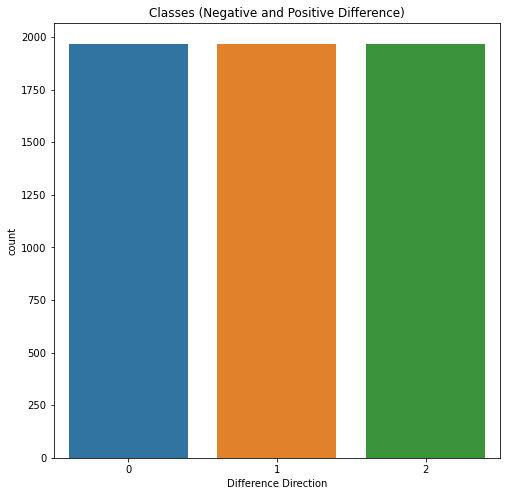

In [322]:
plt.figure(figsize=(8, 8))
sns.countplot(data=combined_dataframes, x='Label_2')
plt.title('Classes (Negative and Positive Difference)')
plt.xlabel("Difference Direction")
plt.show()

In [323]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,y_test = train_test_split(x,y, test_size=0.25)

In [324]:
###### Statistics for 
df_info(X_train)

type  \
Uplift Account 1 (€/MWh)  float64   
RES                       float64   
Load                      float64   
Mandatory Hydro           float64   
Total FRR                 float64   
Holidays                    int64   
IsWeekend                   int64   

                                                                     Sample  \
Uplift Account 1 (€/MWh)  [9.597468442499999, 2.4724315399999997, 9.9511...   
RES                                [1225.0, 3820.0, 1180.0, 1915.0, 1140.0]   
Load                               [6450.5, 8003.0, 6603.5, 6222.0, 8199.5]   
Mandatory Hydro                           [780.0, 76.0, 35.0, 475.0, 921.5]   
Total FRR                          [1504.0, 1409.0, 1414.0, 1656.0, 1696.0]   
Holidays                                                    [0, 0, 0, 0, 0]   
IsWeekend                                                   [1, 0, 0, 1, 0]   

                          % of NaN  Corr_with_y  Duplicates  Amount Uniques  \
Uplift Account 1 (€/MWh)         0          NaN           0            4428   
RES                              0          NaN           0             818   
Load                             0          NaN           0            3423   
Mandatory Hydro                  0          NaN           0            1324   
Total FRR                        0          NaN           0             462   
Holidays                         0          NaN           0               2   
IsWeekend                        0          NaN           0               2   

                          Uniques  Outliers  
Uplift Account 1 (€/MWh)  Several         0  
RES                       Several         0  
Load                      Several         0  
Mandatory Hydro           Several         0  
Total FRR                 Several         0  
Holidays                   [0, 1]         0  
IsWeekend                  [0, 1]         0

In [325]:
y_train.value_counts()

1    1492
2    1477
0    1459
Name: Label_2, dtype: int64

In [326]:
y_test.value_counts()

0    509
2    491
1    476
Name: Label_2, dtype: int64

In [327]:
num_columns = X_train.columns

In [328]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

# cat_columns = []


ct = make_column_transformer(
    (MinMaxScaler(), num_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [329]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        print("_______________________________________________")
        #print(f"ROV CURVE SCORE \n {roc_auc_score(y_train,pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")      
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")
        print("_______________________________________________")
        #print(f"ROC CURVE SCORE :\n {roc_auc_score(y_test,pred)}\n")

$\textbf{Logistic Regression Classifier}$

In [330]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)

print_score(lr_clf, X_train, y_train, X_test, y_test, train=True)
print_score(lr_clf, X_train, y_train, X_test, y_test, train=False)

#from plot_metric.functions import BinaryClassification
#logistic_prob = lr_clf.predict_proba(X=X_test)[:,1]
#bc = BinaryClassification(y_test, logistic_prob, labels=["Class 1", "Class 1"])

#bc.plot_roc_curve()
#plt.show()

Train Result:
Accuracy Score: 45.60%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1            2  accuracy    macro avg  \
precision     0.481613     0.426708     0.459364  0.455962     0.455895   
recall        0.556546     0.460456     0.352065  0.455962     0.456355   
f1-score      0.516375     0.442940     0.398620  0.455962     0.452645   
support    1459.000000  1492.000000  1477.000000  0.455962  4428.000000   

           weighted avg  
precision      0.455692  
recall         0.455962  
f1-score       0.452353  
support     4428.000000  
_______________________________________________
Confusion Matrix: 
 [[812 362 285]
 [478 687 327]
 [396 561 520]]

_______________________________________________
Test Result:
Accuracy Score: 45.46%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1           2  accuracy    macro avg  \
precision    0.484848    0.418895    0.46327

In [331]:
y_proba = lr_clf.predict_proba(X_test)
#roc auc score
roc_auc_score(y_test, y_proba, multi_class='ovo', average='weighted')

0.6262965527762173

In [332]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a treshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [333]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

In [334]:
def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

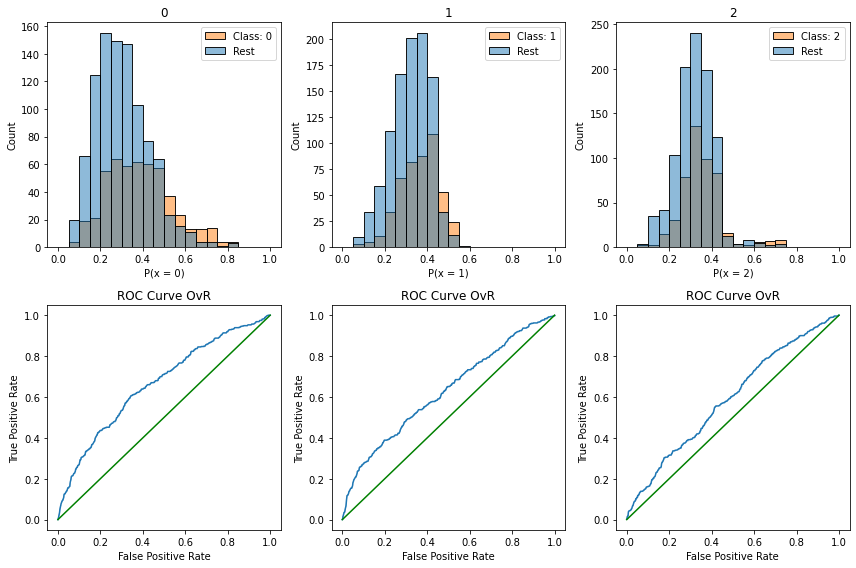

In [335]:
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
classes = lr_clf.classes_
roc_auc_ovr = {}
for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = pd.DataFrame(X_test.copy())
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 3, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 3, i+4)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()

In [336]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovr:
    avg_roc_auc += roc_auc_ovr[k]
    i += 1
    print(f"{k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
print(f"average ROC AUC OvR: {avg_roc_auc/i:.4f}")

0 ROC AUC OvR: 0.6638
1 ROC AUC OvR: 0.6259
2 ROC AUC OvR: 0.5900
average ROC AUC OvR: 0.6266


In [337]:
classes_combinations = []
class_list = list(classes)
for i in range(len(class_list)):
    for j in range(i+1, len(class_list)):
        classes_combinations.append([class_list[i], class_list[j]])
        classes_combinations.append([class_list[j], class_list[i]])

In [338]:
classes_combinations

[['0', '1'], ['1', '0'], ['0', '2'], ['2', '0'], ['1', '2'], ['2', '1']]

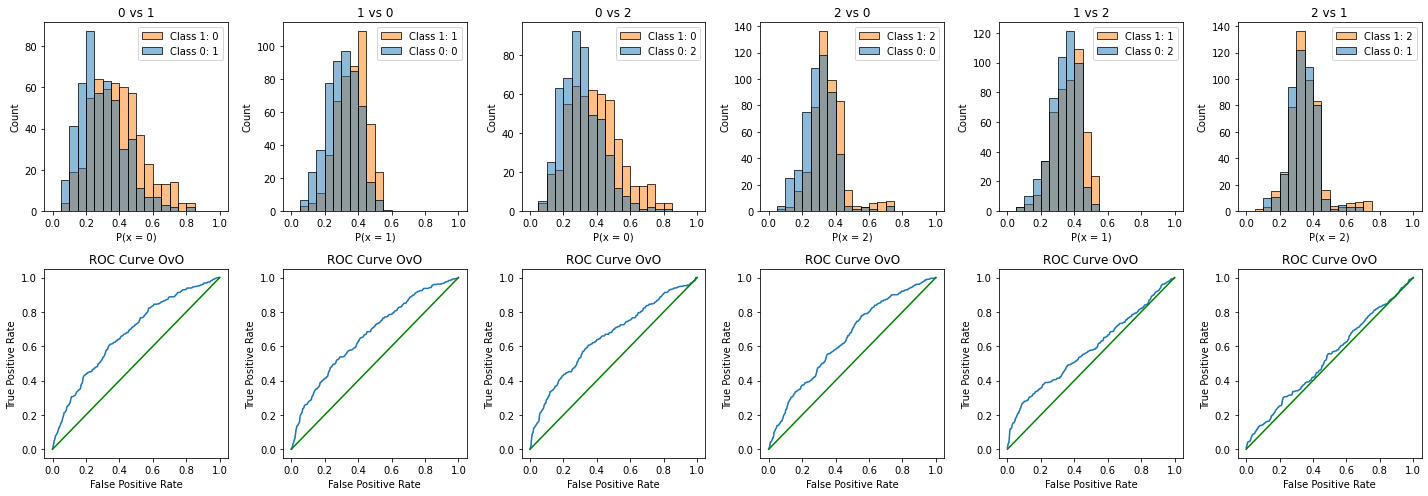

In [339]:
plt.figure(figsize = (20, 7))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovo = {}
for i in range(len(classes_combinations)):
    # Gets the class
    comb = classes_combinations[i]
    c1 = comb[0]
    c2 = comb[1]
    c1_index = class_list.index(c1)
    title = c1 + " vs " +c2
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = pd.DataFrame(X_test.copy())
    df_aux['class'] = y_test.values
    df_aux['prob'] = y_proba[:, c1_index]
    
    # Slices only the subset with both classes
    df_aux = df_aux[(df_aux['class'] == c1) | (df_aux['class'] == c2)]
    df_aux['class'] = [1 if y == c1 else 0 for y in df_aux['class']]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 6, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(title)
    ax.legend([f"Class 1: {c1}", f"Class 0: {c2}"])
    ax.set_xlabel(f"P(x = {c1})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 6, i+7)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvO")
    
    # Calculates the ROC AUC OvO
    roc_auc_ovo[title] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()

In [340]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovo:
    avg_roc_auc += roc_auc_ovo[k]
    i += 1
    print(f"{k} ROC AUC OvO: {roc_auc_ovo[k]:.4f}")
print(f"average ROC AUC OvO: {avg_roc_auc/i:.4f}")

0 vs 1 ROC AUC OvO: 0.6739
1 vs 0 ROC AUC OvO: 0.6667
0 vs 2 ROC AUC OvO: 0.6541
2 vs 0 ROC AUC OvO: 0.6433
1 vs 2 ROC AUC OvO: 0.5836
2 vs 1 ROC AUC OvO: 0.5330
average ROC AUC OvO: 0.6258


$\textbf{Support Vector Machine Grid Search CV}$

In [271]:
#from sklearn.svm import SVC
#from sklearn.metrics import confusion_matrix,classification_report
#from sklearn.model_selection import cross_val_score, GridSearchCV

#Libraries to Build Ensemble Model : Random Forest Classifier 
# Create the parameter grid based on the results of random search 
#params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
#                     'C': [1, 10, 100]},
#                    {'kernel': ['linear'], 'C': [1, 10, 100]}]

In [272]:
# Performing CV to tune parameters for best SVM fit 
#svm_model = GridSearchCV(SVC(), params_grid, cv=2)
#svm_model.fit(X_train, y_train)

In [273]:
# View the accuracy score
#print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
#print('Best C:',svm_model.best_estimator_.C,"\n") 
#print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
#print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

#final_model = svm_model.best_estimator_
#Y_pred = final_model.predict(X_test)
#Y_pred_label = list(encoder.inverse_transform(Y_pred))

In [274]:
# Making the Confusion Matrix
#print(pd.crosstab(Y_test_label, Y_pred_label, rownames=['Actual Activity'], colnames=['Predicted Activity']))
#print(confusion_matrix(y_test,Y_pred))
#print("\n")
#print(classification_report(y_test,Y_pred))

#print("Training set score for SVM: %f" % final_model.score(X_train , y_train))
#print("Testing  set score for SVM: %f" % final_model.score(X_test  , y_test))

#svm_model.score

In [275]:
from sklearn import svm
rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1).fit(X_train, y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1).fit(X_train, y_train)

In [276]:
poly_pred = poly.predict(X_test)
rbf_pred = rbf.predict(X_test)

In [277]:
from sklearn.linear_model import LogisticRegression


print_score(rbf, X_train, y_train, X_test, y_test, train=True)
print_score(rbf, X_train, y_train, X_test, y_test, train=False)

#from plot_metric.functions import BinaryClassification
#logistic_prob = lr_clf.predict_proba(X=X_test)[:,1]
#bc = BinaryClassification(y_test, logistic_prob, labels=["Class 1", "Class 1"])

#bc.plot_roc_curve()
#plt.show()

Train Result:
Accuracy Score: 51.99%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1            2  accuracy    macro avg  \
precision     0.521446     0.551043     0.503448  0.519874     0.525312   
recall        0.586088     0.337139     0.638198  0.519874     0.520475   
f1-score      0.551881     0.418333     0.562871  0.519874     0.511028   
support    1452.000000  1489.000000  1487.000000  0.519874  4428.000000   

           weighted avg  
precision      0.525355  
recall         0.519874  
f1-score       0.510663  
support     4428.000000  
_______________________________________________
Confusion Matrix: 
 [[851 191 410]
 [461 502 526]
 [320 218 949]]

_______________________________________________
Test Result:
Accuracy Score: 49.53%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1           2  accuracy    macro avg  \
precision    0.523726    0.517123    0.45853

In [428]:
from sklearn.linear_model import LogisticRegression


print_score(poly, X_train, y_train, X_test, y_test, train=True)
print_score(poly, X_train, y_train, X_test, y_test, train=False)

#from plot_metric.functions import BinaryClassification
#logistic_prob = lr_clf.predict_proba(X=X_test)[:,1]
#bc = BinaryClassification(y_test, logistic_prob, labels=["Class 1", "Class 1"])

#bc.plot_roc_curve()
#plt.show()

Train Result:
Accuracy Score: 33.27%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1            2  accuracy    macro avg  \
precision     0.347676     0.342916     0.324577  0.332656     0.338390   
recall        0.270053     0.114149     0.614023  0.332656     0.332742   
f1-score      0.303988     0.171282     0.424670  0.332656     0.299980   
support    1496.000000  1463.000000  1469.000000  0.332656  4428.000000   

           weighted avg  
precision      0.338440  
recall         0.332656  
f1-score       0.300179  
support     4428.000000  
_______________________________________________
Confusion Matrix: 
 [[404 154 938]
 [357 167 939]
 [401 166 902]]

_______________________________________________


$\textbf{Boosted Decision Trees Classification}$

   CrossVal_Score_Means  CrossValerrors                    Algo
0              0.470419        0.011919  RandomForestClassifier
1              0.506544        0.015624      AdaBoostClassifier
2              0.542684        0.016596       Gradient Boosting
3              0.456642        0.012696  DecisionTreeClassifier


C:\Users\USER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


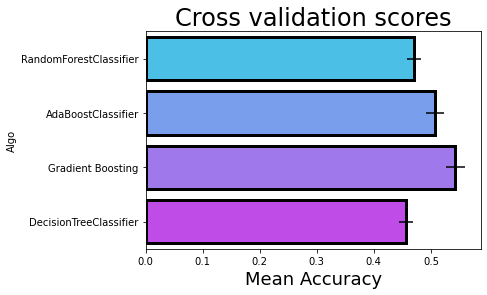

<Figure size 1080x504 with 0 Axes>

In [279]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve ,KFold

GradientBoosting = GradientBoostingClassifier( min_samples_leaf = 70, min_samples_split = 1000,learning_rate= 0.01 , n_estimators =60 , max_depth = 3)
gradient_fit = GradientBoosting.fit(X_train, y_train)

kfold = StratifiedKFold(n_splits=8,shuffle=True, random_state=42)

rs = 15
clrs = []

clrs.append(AdaBoostClassifier(random_state=rs))
clrs.append(GradientBoostingClassifier(random_state=rs))
clrs.append(RandomForestClassifier(random_state=rs))
clrs.append(DecisionTreeClassifier(random_state = rs))

cv_results = []
for clr in clrs :
    cv_results.append(cross_val_score(clr, X_train, y_train , scoring = 'accuracy', cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_df = pd.DataFrame({"CrossVal_Score_Means":cv_means,"CrossValerrors": cv_std,"Algo":["RandomForestClassifier","AdaBoostClassifier","Gradient Boosting",'DecisionTreeClassifier']})
g = sns.barplot("CrossVal_Score_Means","Algo",data = cv_df,orient = "h",**{'xerr':cv_std},palette='cool',edgecolor="black",linewidth=3)
g.set_xlabel("Mean Accuracy",fontsize = 18)
g = g.set_title("Cross validation scores",fontsize = 24)
plt.figure(figsize = (15,7))
print(cv_df)


In [280]:
print_score(gradient_fit, X_train, y_train, X_test, y_test, train=True)
print_score(gradient_fit, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 46.79%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1            2  accuracy    macro avg  \
precision     0.484006     0.487156     0.444737  0.467931     0.471966   
recall        0.479339     0.356615     0.568258  0.467931     0.468071   
f1-score      0.481661     0.411788     0.498967  0.467931     0.464138   
support    1452.000000  1489.000000  1487.000000  0.467931  4428.000000   

           weighted avg  
precision      0.471878  
recall         0.467931  
f1-score       0.463976  
support     4428.000000  
_______________________________________________
Confusion Matrix: 
 [[696 250 506]
 [409 531 549]
 [333 309 845]]

_______________________________________________
Test Result:
Accuracy Score: 47.56%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1           2  accuracy    macro avg  \
precision    0.513185    0.489614    0.43962

In [281]:
y_proba = gradient_fit.predict_proba(X_test)

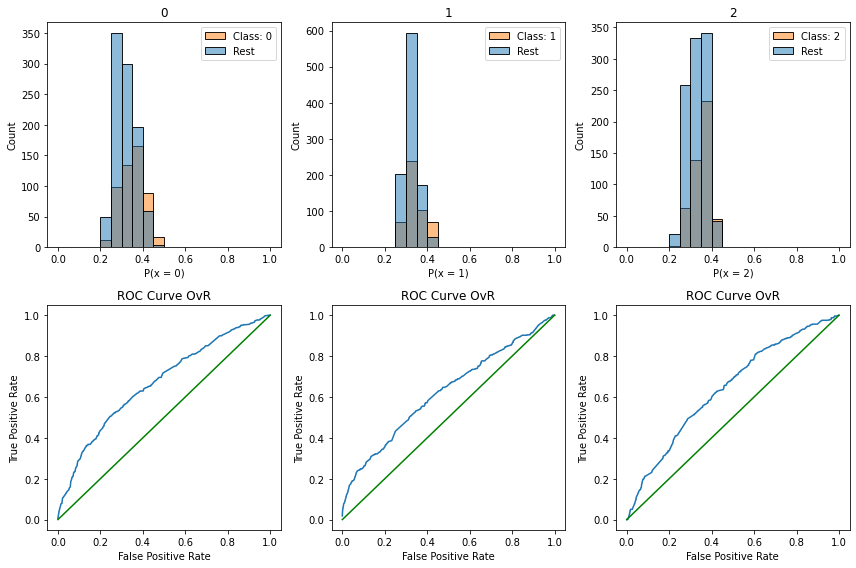

In [282]:
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
classes = gradient_fit.classes_
roc_auc_ovr = {}
for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = pd.DataFrame(X_test.copy())
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 3, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 3, i+4)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()

In [283]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovr:
    avg_roc_auc += roc_auc_ovr[k]
    i += 1
    print(f"{k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
print(f"average ROC AUC OvR: {avg_roc_auc/i:.4f}")

0 ROC AUC OvR: 0.6675
1 ROC AUC OvR: 0.6219
2 ROC AUC OvR: 0.6392
average ROC AUC OvR: 0.6429


$\textbf{Neural Network Classifier}$

In [284]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

clf1 = MLPClassifier(
    hidden_layer_sizes=(3),
    activation="relu",
    verbose=True,
    max_iter=1000
)
clf2 = MLPClassifier(
    hidden_layer_sizes=(10),
    activation="logistic",
    verbose=False,
    max_iter=10000
)

clf3 = MLPClassifier(
    hidden_layer_sizes=(50,25),
    activation="tanh",
    verbose=False,
    max_iter=10000
)

# Fitting MinMax Scaler to features
clf1.fit(X_train, y_train.values.ravel())
clf2.fit(X_train, y_train.values.ravel())
clf3.fit(X_train, y_train.values.ravel())


Iteration 1, loss = 1.15332567
Iteration 2, loss = 1.13191547
Iteration 3, loss = 1.11653030
Iteration 4, loss = 1.10528337
Iteration 5, loss = 1.09736520
Iteration 6, loss = 1.09102670
Iteration 7, loss = 1.08644608
Iteration 8, loss = 1.08334339
Iteration 9, loss = 1.08062598
Iteration 10, loss = 1.07849928
Iteration 11, loss = 1.07683916
Iteration 12, loss = 1.07506951
Iteration 13, loss = 1.07364638
Iteration 14, loss = 1.07232807
Iteration 15, loss = 1.07091834
Iteration 16, loss = 1.06982295
Iteration 17, loss = 1.06865561
Iteration 18, loss = 1.06748806
Iteration 19, loss = 1.06624067
Iteration 20, loss = 1.06495828
Iteration 21, loss = 1.06372312
Iteration 22, loss = 1.06274988
Iteration 23, loss = 1.06143462
Iteration 24, loss = 1.06039581
Iteration 25, loss = 1.05948812
Iteration 26, loss = 1.05857391
Iteration 27, loss = 1.05766354
Iteration 28, loss = 1.05688175
Iteration 29, loss = 1.05582310
Iteration 30, loss = 1.05496873
Iteration 31, loss = 1.05420368
Iteration 32, los

MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 25), max_iter=10000)

In [285]:
print_score(clf3, X_train, y_train, X_test, y_test, train=True)
print_score(clf3, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 66.15%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1            2  accuracy    macro avg  \
precision     0.702390     0.622143     0.660595  0.661472     0.661709   
recall        0.668044     0.584956     0.731675  0.661472     0.661558   
f1-score      0.684786     0.602977     0.694320  0.661472     0.660695   
support    1452.000000  1489.000000  1487.000000  0.661472  4428.000000   

           weighted avg  
precision      0.661370  
recall         0.661472  
f1-score       0.660478  
support     4428.000000  
_______________________________________________
Confusion Matrix: 
 [[ 970  272  210]
 [ 269  871  349]
 [ 142  257 1088]]

_______________________________________________
Test Result:
Accuracy Score: 51.22%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1           2  accuracy    macro avg  \
precision    0.549495    0.466216  

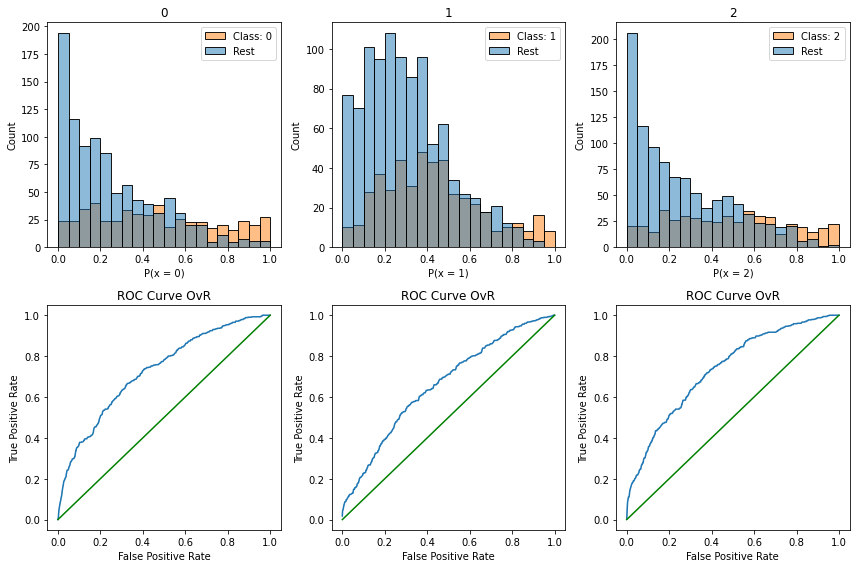

In [286]:
y_proba = clf3.predict_proba(X_test)


plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
classes = gradient_fit.classes_
roc_auc_ovr = {}
for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = pd.DataFrame(X_test.copy())
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 3, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 3, i+4)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()

In [287]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovr:
    avg_roc_auc += roc_auc_ovr[k]
    i += 1
    print(f"{k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
print(f"average ROC AUC OvR: {avg_roc_auc/i:.4f}")

0 ROC AUC OvR: 0.7261
1 ROC AUC OvR: 0.6591
2 ROC AUC OvR: 0.7347
average ROC AUC OvR: 0.7066


In [412]:
X =  x.drop("Uplift Account 1 (€/MWh)_Noise",axis=1)

$\textbf{Extra Trees Classifier}$

In [424]:
from sklearn.ensemble import ExtraTreesClassifier
etr = ExtraTreesClassifier()
etr_CV = GridSearchCV(estimator=etr, param_grid={'min_samples_leaf' : [11, 12, 13, 14]}, cv=5, verbose=False)
etr_CV.fit(X_train, y_train)
print(etr_CV.best_params_)
#acc_metrics_calc(12,etr_CV,X_train,X_test,y_train,y_test)

{'min_samples_leaf': 12}


In [425]:
extra_trees_cl = etr_CV.predict(X_test)

In [429]:
print_score(etr_CV, X_train, y_train, X_test, y_test, train=True)
print_score(etr_CV, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 59.71%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1            2  accuracy    macro avg  \
precision     0.578079     0.632945     0.592317  0.597109     0.601114   
recall        0.655749     0.483254     0.650783  0.597109     0.596595   
f1-score      0.614469     0.548062     0.620175  0.597109     0.594235   
support    1496.000000  1463.000000  1469.000000  0.597109  4428.000000   

           weighted avg  
precision      0.600930  
recall         0.597109  
f1-score       0.594421  
support     4428.000000  
_______________________________________________
Confusion Matrix: 
 [[981 216 299]
 [397 707 359]
 [319 194 956]]

_______________________________________________
Test Result:
Accuracy Score: 50.68%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1           2  accuracy    macro avg  \
precision    0.473413    0.546667    0.51544

$\textbf{I want to test the data in some unlabeled data of a consequtivbe Week}$

$\textbf{Adding Gaussian Noise to Uplift Account 1}$

In [374]:
#mu, sigma = 0, 0.2
#noise = np.random.normal(mu, sigma)
#x[features[6]+"_Noise"] = x[features[6]] + noise

In [405]:
mu=0.0
std = 0.2 * np.std(x[features[6]]) # for %5 Gaussian noise
def gaussian_noise(x,mu,std):
    noise = np.random.normal(mu, std, size = x.shape)
    x_noisy = x + noise
    return x_noisy 

In [406]:
x[features[6]+"_Noise"] = gaussian_noise(x[features[6]],mu,std)

In [407]:
x_with_noise = x.drop(features[6],axis=1)

In [408]:
x_with_noise.head()

RES    Load  Mandatory Hydro  Total FRR  Holidays  \
2021-08-15 00:00:00  1820.0  5515.5             50.0      914.0         1   
2021-08-15 01:00:00  1930.0  5299.0             50.0      939.0         1   
2021-08-15 02:00:00  2000.0  5127.5             50.0      949.0         1   
2021-08-15 03:00:00  2035.0  5038.0             63.0      939.0         1   
2021-08-15 04:00:00  2055.0  4951.5             76.0     1079.0         1   

                     IsWeekend  Uplift Account 1 (€/MWh)_Noise  
2021-08-15 00:00:00          1                        2.332456  
2021-08-15 01:00:00          1                        2.212691  
2021-08-15 02:00:00          1                        2.157055  
2021-08-15 03:00:00          1                        3.120284  
2021-08-15 04:00:00          1                        2.030714

In [409]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,y_test = train_test_split(x_with_noise,y, test_size=0.25)

###### Statistics for 
df_info(X_train)

y_train.value_counts()

y_test.value_counts()

num_columns = X_train.columns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

# cat_columns = []


ct = make_column_transformer(
    (MinMaxScaler(), num_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)


Iteration 1, loss = 1.15534415
Iteration 2, loss = 1.12878436
Iteration 3, loss = 1.11043563
Iteration 4, loss = 1.09854061
Iteration 5, loss = 1.09059216
Iteration 6, loss = 1.08470482
Iteration 7, loss = 1.08067183
Iteration 8, loss = 1.07745045
Iteration 9, loss = 1.07500971
Iteration 10, loss = 1.07321304
Iteration 11, loss = 1.07153113
Iteration 12, loss = 1.06986048
Iteration 13, loss = 1.06852763
Iteration 14, loss = 1.06720268
Iteration 15, loss = 1.06611507
Iteration 16, loss = 1.06509298
Iteration 17, loss = 1.06412500
Iteration 18, loss = 1.06308274
Iteration 19, loss = 1.06206723
Iteration 20, loss = 1.06122547
Iteration 21, loss = 1.06033301
Iteration 22, loss = 1.05957801
Iteration 23, loss = 1.05885807
Iteration 24, loss = 1.05813694
Iteration 25, loss = 1.05741614
Iteration 26, loss = 1.05655678
Iteration 27, loss = 1.05581456
Iteration 28, loss = 1.05501595
Iteration 29, loss = 1.05434378
Iteration 30, loss = 1.05355153
Iteration 31, loss = 1.05297612
Iteration 32, los

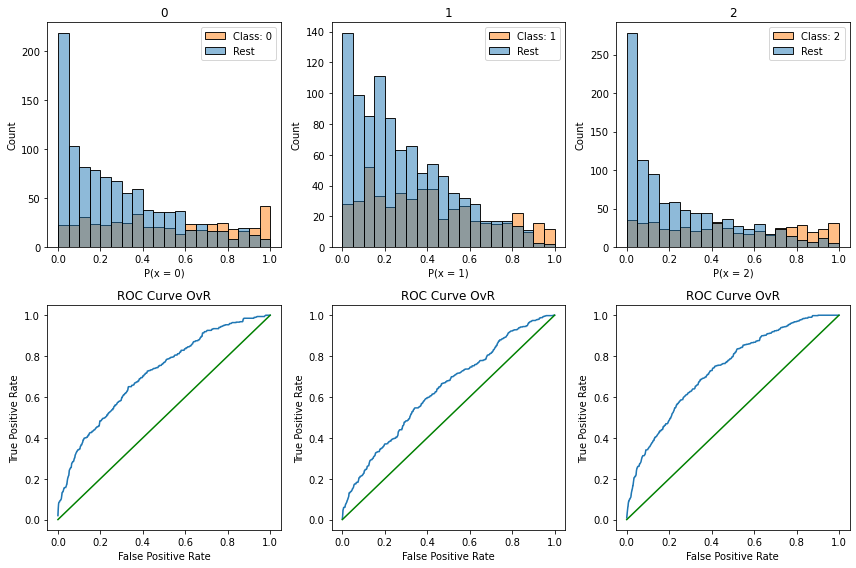

In [410]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

clf1 = MLPClassifier(
    hidden_layer_sizes=(3),
    activation="relu",
    verbose=True,
    max_iter=1000
)
clf2 = MLPClassifier(
    hidden_layer_sizes=(10),
    activation="logistic",
    verbose=False,
    max_iter=10000
)

clf3 = MLPClassifier(
    hidden_layer_sizes=(50,25),
    activation="tanh",
    verbose=False,
    max_iter=10000
)

# Fitting MinMax Scaler to features
clf1.fit(X_train, y_train.values.ravel())
clf2.fit(X_train, y_train.values.ravel())
clf3.fit(X_train, y_train.values.ravel())


print_score(clf3, X_train, y_train, X_test, y_test, train=True)
print_score(clf3, X_train, y_train, X_test, y_test, train=False)

y_proba = clf3.predict_proba(X_test)


plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
classes = gradient_fit.classes_
roc_auc_ovr = {}
for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = pd.DataFrame(X_test.copy())
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 3, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 3, i+4)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()

# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovr:
    avg_roc_auc += roc_auc_ovr[k]
    i += 1
    print(f"{k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
print(f"average ROC AUC OvR: {avg_roc_auc/i:.4f}")